In [1]:
import json
import statistics
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform
import sklearn.cluster as cluster
import time
import scipy
import seaborn as sns
import random
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha': 0.25, 's':80, 'linewidths':0}

# set up type of service

In [2]:
# user input
user_input = 'Restaurants'


# read in business file, compose business categories, business rating on category and business postal code dictionary

In [3]:
# initialize business data
bcmap = {}
with open('business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        
        key = l['business_id']
        state = l['city']
        #Business Category Dictionary
        category = l['categories']
        if state not in bcmap:
            bcmap[state] = {}
        bcmap[state][key] = category

# generate top categories
category = {}
for state in bcmap:
    category[state] = {}
    for i in bcmap[state]:
        if user_input in bcmap[state][i]:
            for j in bcmap[state][i]:
                if j not in category[state]:
                    category[state][j] = 1
                else:
                    category[state][j] += 1

tc = {}
for state in category:
    top_cate = sorted(category[state].items(), key=lambda x:(-x[1]))[1:21]
    tc[state] = []
    for i in top_cate:
        tc[state].append(i[0])
    
# initialize business data   
location = {}
bcrmap = {}
business_name = {}
with open('business.json','r') as bf:
    for line in bf:
        l = json.loads(line)
        key = l['business_id']
        category = l['categories']
        
        # Business City Dictionary
        city = l['city']
        location[key] = city
        
        # Business -> Category -> Star Dictionary
        stars = l['stars']
        valid = False
        number_of_tc = 0
        if city not in bcrmap:
            bcrmap[city] = {}
        if key not in bcrmap[city]:
            bcrmap[city][key] = {}
        for i in category:
            if i in tc[city]:
                number_of_tc += 1
                valid = True
                bcrmap[city][key].setdefault(i,[]).append(stars)
        if not valid or number_of_tc <3:
            del bcrmap[city][key]
            
            
        # Business name -> Address Dictionary
        name = l['name'] +','  + l['address'] +','  + l['city'] +',' + l['state']
        business_name[key] = name
        

# read in review file and generate user to category to rating map

In [4]:
# initialize user review data
# User -> Categories -> Stars
ucrmap = {}
test_urcmap = {}
user_rating = {}
with open('review.json', 'r') as rv:
    for line in rv:
        n1 = json.loads(line)
        
        okey = n1['user_id']
        year = n1['date']
        bid = n1['business_id']
        value = n1['stars']
        
        city = location[bid]
        
        ikeys = bcmap[city][bid]
        
        if city not in user_rating:
            user_rating[city] = {}
        user_rating[city].setdefault(okey, []).append(value)
        if city not in ucrmap:
            ucrmap[city]  = {}
        if city not in test_urcmap:
            test_urcmap[city]  = {}
        if int(n1['date'].split('-')[0]) < 2016:
            if okey not in ucrmap[city]:
                ucrmap[city][okey] = {}
            for ikey in ikeys:
                if ikey in tc[city]:
                    ucrmap[city][okey].setdefault(ikey, []).append(value)
        else:
            if okey not in test_urcmap:
                test_urcmap[city][okey] = {}
            test_urcmap[city][okey][bid] = value

In [5]:
listCity = {}
for i in ucrmap:
    if i in bcrmap:
        listCity[i] = {}
        listCity[i]['user'] = len(ucrmap[i])
        listCity[i]['business'] = len(bcrmap[i])

In [6]:
len(listCity)

1010

In [7]:
sorted_by_business = sorted(listCity.items(), key=lambda x: -x[1]['business'])
sorted_by_business[:15]

[('Las Vegas', {'business': 1427, 'user': 290813}),
 ('Toronto', {'business': 1325, 'user': 53905}),
 ('Phoenix', {'business': 1033, 'user': 114505}),
 ('Charlotte', {'business': 784, 'user': 39523}),
 ('Edinburgh', {'business': 676, 'user': 6869}),
 ('Pittsburgh', {'business': 671, 'user': 31715}),
 ('Montréal', {'business': 614, 'user': 21535}),
 ('Scottsdale', {'business': 542, 'user': 71454}),
 ('Cleveland', {'business': 409, 'user': 20653}),
 ('Madison', {'business': 368, 'user': 17121}),
 ('Stuttgart', {'business': 326, 'user': 7877}),
 ('Mesa', {'business': 285, 'user': 32842}),
 ('Tempe', {'business': 272, 'user': 44293}),
 ('Henderson', {'business': 227, 'user': 37913}),
 ('Mississauga', {'business': 210, 'user': 8450})]

In [8]:
sorted_by_user = sorted(listCity.items(), key=lambda x: -x[1]['user'])
sorted_by_user[:15]

[('Las Vegas', {'business': 1427, 'user': 290813}),
 ('Phoenix', {'business': 1033, 'user': 114505}),
 ('Scottsdale', {'business': 542, 'user': 71454}),
 ('Toronto', {'business': 1325, 'user': 53905}),
 ('Tempe', {'business': 272, 'user': 44293}),
 ('Charlotte', {'business': 784, 'user': 39523}),
 ('Henderson', {'business': 227, 'user': 37913}),
 ('Mesa', {'business': 285, 'user': 32842}),
 ('Pittsburgh', {'business': 671, 'user': 31715}),
 ('Chandler', {'business': 208, 'user': 30060}),
 ('Gilbert', {'business': 180, 'user': 23918}),
 ('Montréal', {'business': 614, 'user': 21535}),
 ('Glendale', {'business': 166, 'user': 21017}),
 ('Cleveland', {'business': 409, 'user': 20653}),
 ('Madison', {'business': 368, 'user': 17121})]

In [9]:
list_city = [ x[0] for x in sorted_by_business]

In [10]:
list_city[:15]

['Las Vegas',
 'Toronto',
 'Phoenix',
 'Charlotte',
 'Edinburgh',
 'Pittsburgh',
 'Montréal',
 'Scottsdale',
 'Cleveland',
 'Madison',
 'Stuttgart',
 'Mesa',
 'Tempe',
 'Henderson',
 'Mississauga']

In [11]:
def recommend_based_on_state(state):
    print('============================================')
    print('Recommendation info summary for : ', state)

    City_of_Data = state
   
    # pre-process data: build up user and business data set based on state
    filter_user = {}
    valid_user = {}
    valid_test_user = {}
    for i in user_rating[City_of_Data]:
        if len(user_rating[City_of_Data][i]) >= 20:
            filter_user[i] = len(user_rating[City_of_Data][i])
    raw = sorted(filter_user.items(), key=lambda x:-x[1])
    valid_list = []
    for k, v in raw:
        if k in ucrmap[City_of_Data] and k in test_urcmap[City_of_Data]:
            valid_list.append(k)
            valid_user[k] = ucrmap[City_of_Data][k]
            valid_test_user[k] = test_urcmap[City_of_Data][k]
            
    print('number of valid user: ', len(valid_user))
    print('number of valid test user: ', len(valid_user))
    
    #generate business category dict with pure vector
    def generate_nbcrmap(data):
        for business in data:
            for k, v in data[business].items():
                data[business][k] = statistics.mean(v)

        for business in data:
            for i in tc[state]:
                if i not in data[business]:
                    data[business][i] = 3.15

        nbcrmap = {}
        for k, v in data.items():
            nbcrmap[k] = []
            value = []
            for i in tc[state]:
                value.append(v[i])
            nbcrmap[k] = value
        return nbcrmap

    nbcrmp = generate_nbcrmap(bcrmap[City_of_Data])
    
    # Compose user category vector
    def generate_nucrmap(data):
        for user in data:
            for cate, value in data[user].items():
                data[user][cate] = statistics.mean(value)
        for user in data:
            for i in tc[state]:
                if i not in data[user]:
                    data[user][i] = 3.15

        nucrmap = {}
        for k, v in data.items():
            nucrmap[k] = []
            value = []
            for i in tc[state]:
                value.append(v[i])
            nucrmap[k] = value
        return nucrmap

    nucrmap = generate_nucrmap(valid_user)
    
    data = nucrmap
    listV = list(data.values())
    listK = list(data.keys())
    
    # Agglomerative clustering using scipy
    Z = scipy.cluster.hierarchy.linkage(listV[:300], method='average')
    plt.clf()
    fig = plt.figure(figsize=(100, 60), dpi=40, facecolor='w', edgecolor='k')
    dd = scipy.cluster.hierarchy.dendrogram(Z)
    plt.savefig('{}.pdf'.format('average'))
    plt.show()
    

    
    #agglomerative clustering using sklearn 
    data1 = []
    for k,v in nucrmap.items():
        data1.append(v)
    np.save('123', np.array(data1))
    data1 = np.load('123.npy')

    # get number of clusters from above plot and generate clusters dictionary
    model = cluster.AgglomerativeClustering(linkage='average', n_clusters=20)
    result = model.fit_predict(listV)
    clusters = {}
    for i in range(len(result)):
        k = result[i]
        v = data1[i]
        clusters.setdefault(k, []).append(v)

    # Average Vector for each cluster generated above

    average_vector = {}
    for i in list(clusters.keys()):
        average_vector[i] = np.mean(clusters[i], axis=0)

    def generate_recommendatioin(uid):
        index = listK.index(uid)
        uvector = average_vector[result[index]]
        r = {}
        for i in nbcrmp:
            r[i] = np.inner(uvector, nbcrmp[i])
        top_business = sorted(r.items(), key=lambda x:(-x[1]))[1:100]
        return [k for k,v in top_business]
    def cacluate_hr(uid, bids):
        score = 0
        count = 0
        for bid in bids:
            if bid in valid_test_user[uid]:
                count += 1
                if valid_test_user[uid][bid] > 3.7:
                    score += 1
                if valid_test_user[uid][bid] < 2.6:
                    score -= 1
        return np.array([score, count])
    
    def calculate_ndcg(uid, bids):
        gain = 0
        ind_list = []
        for i in range(len(bids)):
            bid = bids[i]
            if bid in valid_test_user[uid]:
                ind_list.append(i+1)
                gain += valid_test_user[uid][bid]/(i+1)
        idcg = 0
        for i in ind_list:
            idcg += 5/i
        if idcg == 0:
            return 0
        return np.array([gain,idcg])

    def evaluate(list_test):
        hr = np.array([0.,0.])
        ndcg = np.array([0.,0.])
        for uid in list_test:
            recs = generate_recommendatioin(uid)
            tmp = cacluate_hr(uid, recs)
            ndcg += calculate_ndcg(uid, recs)
            hr += tmp
        print('Hit Ratio: ', hr[0]/hr[1])
        print('NDCG: ', ndcg[0]/ndcg[1])
        print('============================================')
        print('\n\n\n\n')
        return (hr[0]/hr[1], ndcg[0]/ndcg[1])
    
    # user index corresponding to user vector dictionary
    index = random.randint(0,len(listK)-1)
    # Get the users cluster vector 
    user_vector = average_vector[result[index]]
    # Perfor inner dot product between user_vector and each business vector

    result_bcrmap = {}
    for i in nbcrmp:
        result_bcrmap[i] = np.inner(user_vector, nbcrmp[i])
    # Sort the business based on the minimum value of above operation. Keep top 20 businesses
    top_business = sorted(result_bcrmap.items(), key=lambda x:(-x[1]))[1:20]
    # print out the recommended businesses

    for k,v in top_business:
        print(business_name[k])
        
        
    return evaluate(valid_list)

Recommendation info summary for :  Las Vegas
number of valid user:  5896
number of valid test user:  5896


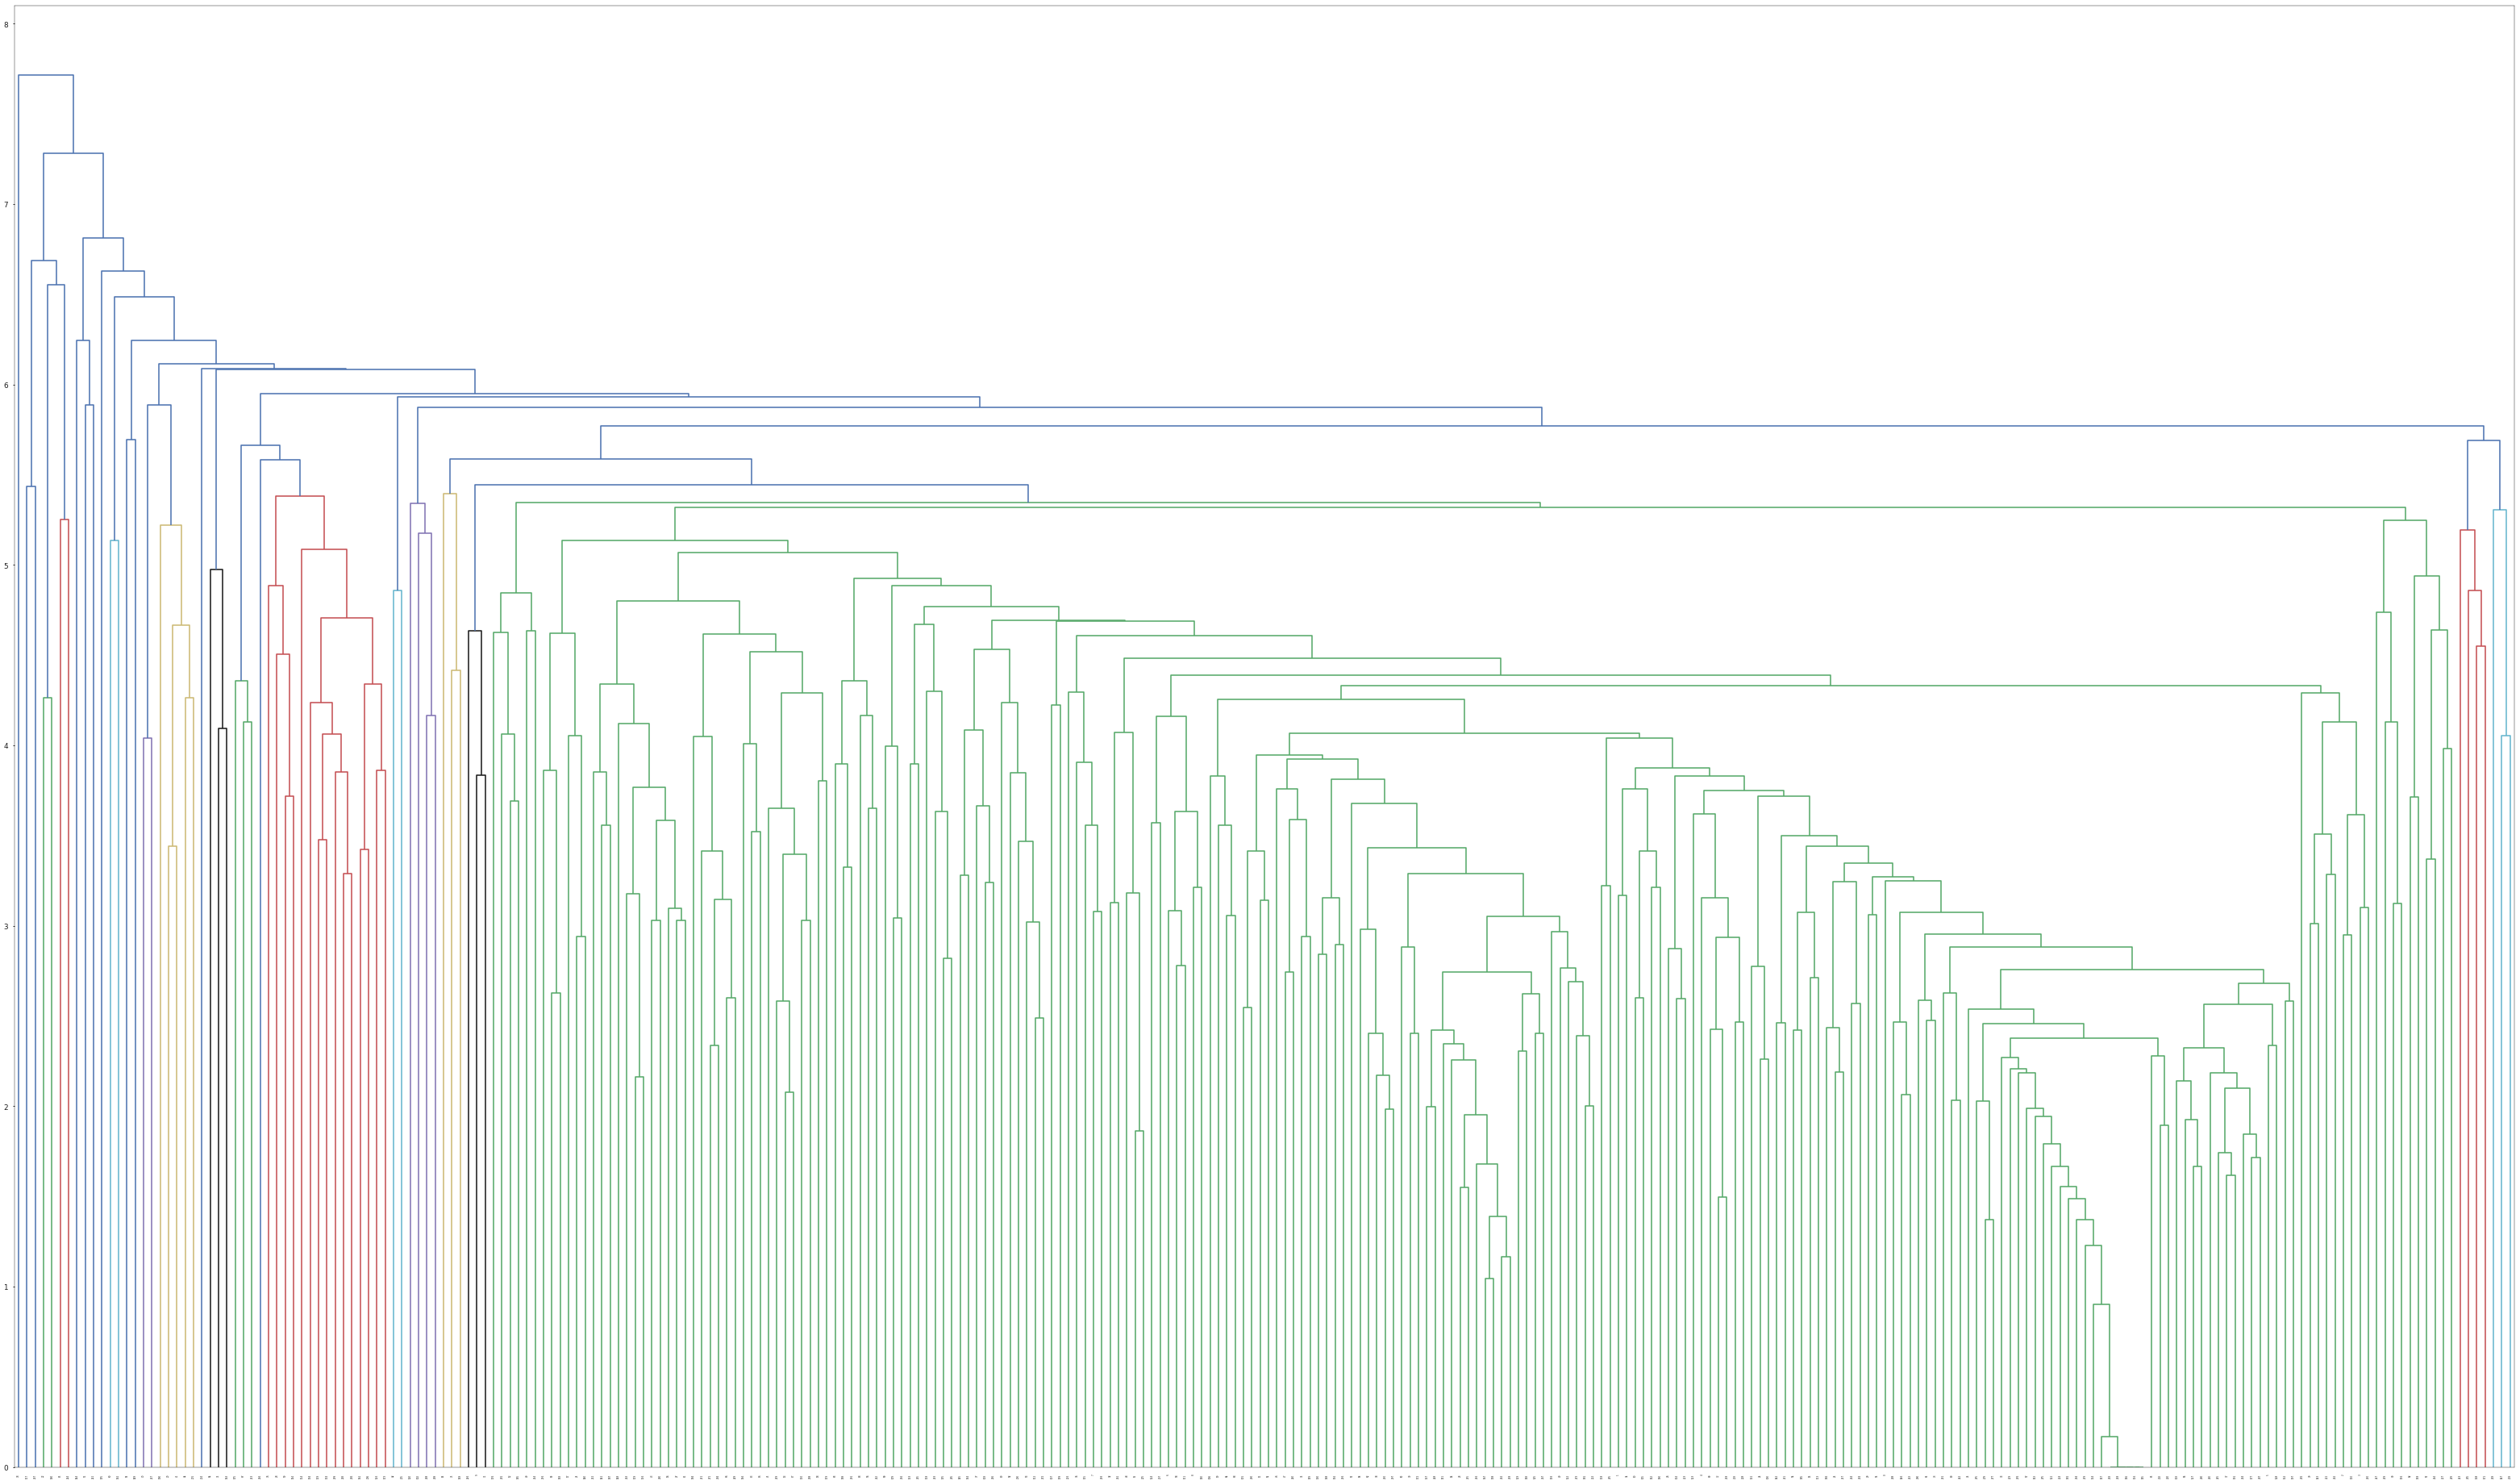

Jjanga Steak & Sushi,6125 S Fort Apache Rd, Ste 200,Las Vegas,NV
Gilligan's HideAway,2601 Atlantic St,Las Vegas,NV
Zest - Bistro & Bar,10670 Southern Highlands Pkwy, Ste 102,Las Vegas,NV
Pier 215,7060 S Durango Dr, Ste 101,Las Vegas,NV
Soho Sushi Burrito,6040 W Badura Ave, Ste 150,Las Vegas,NV
Mojito Hut,3570 S Las Vegas Blvd,Las Vegas,NV
Modern Proteins,6475 W Charleston Blvd, Ste 110,Las Vegas,NV
VIP Sushi and Karaoke,953 E Sahara Ave, Ste E-1A,Las Vegas,NV
J Karaoke Bar,3899 Spring Mountain Rd,Las Vegas,NV
Rachel's Kitchen,888 W Bonneville Ave,Las Vegas,NV
Toddy Shop,238 S Rainbow Blvd,Las Vegas,NV
Playa Papagayos,4760 W Sahara Ave, Ste 21,Las Vegas,NV
Snack Bar,1220 E Harmon Ave, Ste A,Las Vegas,NV
Aroma Cuisine of the World/Oscar Catering,6370 W Flamingo Rd, Ste 30,Las Vegas,NV
Yard House,11011 W Charleston Blvd,Las Vegas,NV
Greens and Proteins,8975 S Eastern Ave,Las Vegas,NV
The Steakhouse at Treasures,2801 Westwood Dr,Las Vegas,NV
Kaffe Live,5135 S Fort Apache Rd, Ste 145,Las Ve

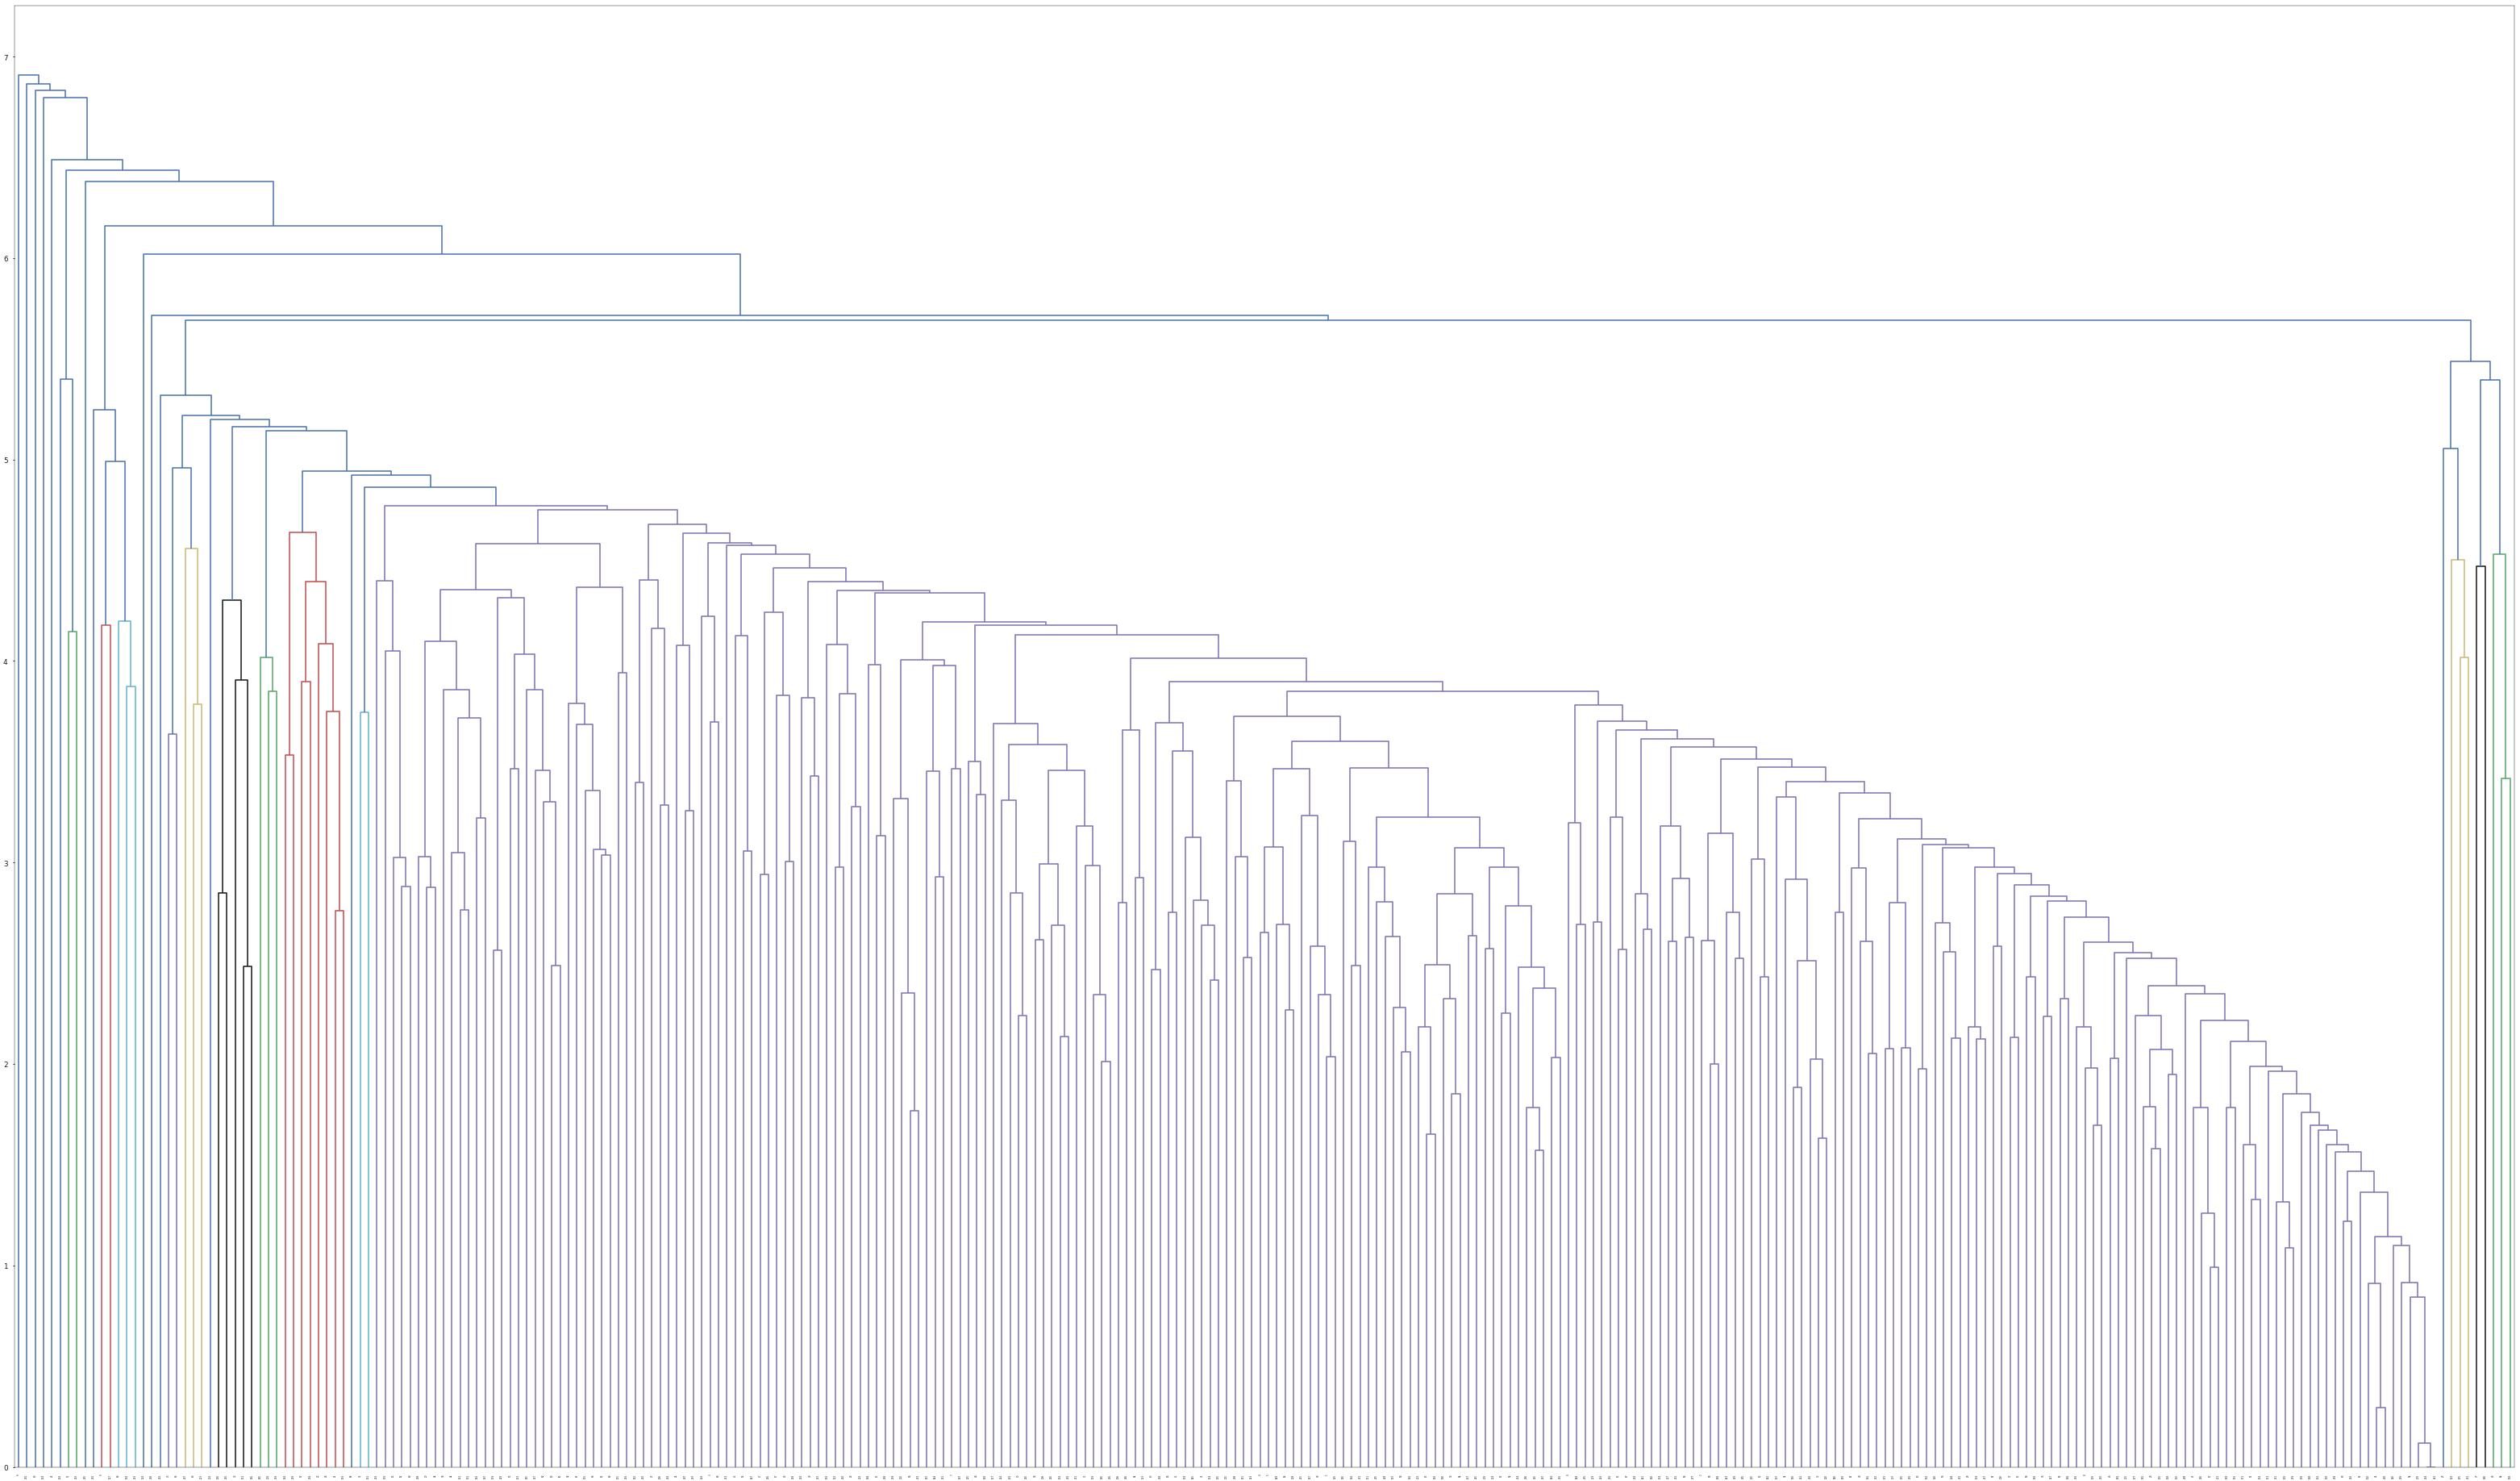

MoTo Coffee and Snack Bar,1321 Dundas Street W,Toronto,ON
Paint Cabin,723 Gerrard Street E,Toronto,ON
Tesla Cafe,690 Euclid Avenue,Toronto,ON
Haute Coffee,153 Dupont Street,Toronto,ON
The Porch Light,982 Kingston Road,Toronto,ON
Scout & Cash Caffe,146 Christie Street,Toronto,ON
Voodoo Child,388 College Street,Toronto,ON
Page One,106 Mutual Street,Toronto,ON
Ciao Europa Cafe,80 Western Battery Road,Toronto,ON
Green Republic Food,439 University Avenue, Unit 105,Toronto,ON
Raca Cafe and Bar,1704 Queen Street W,Toronto,ON
Bailey's Cafe,324 Bathurst Street,Toronto,ON
Noble Coffee,1421 Bloor Street W,Toronto,ON
The Merseyside,2413 Dundas Street W,Toronto,ON
Wraps On The Go,Cumberland Terrace, 2 Bloor Street W,Toronto,ON
Placebo Space,2877 Lakeshore Boulevard W,Toronto,ON
Livelihood Cafe,254 Augusta Avenue,Toronto,ON
East of York Gourmet Food,1904 Danforth Avenue,Toronto,ON
Zocalo,1426 Bloor Street W,Toronto,ON
Hit Ratio:  0.65
NDCG:  0.88883804579





Recommendation info summary for :  Phoe

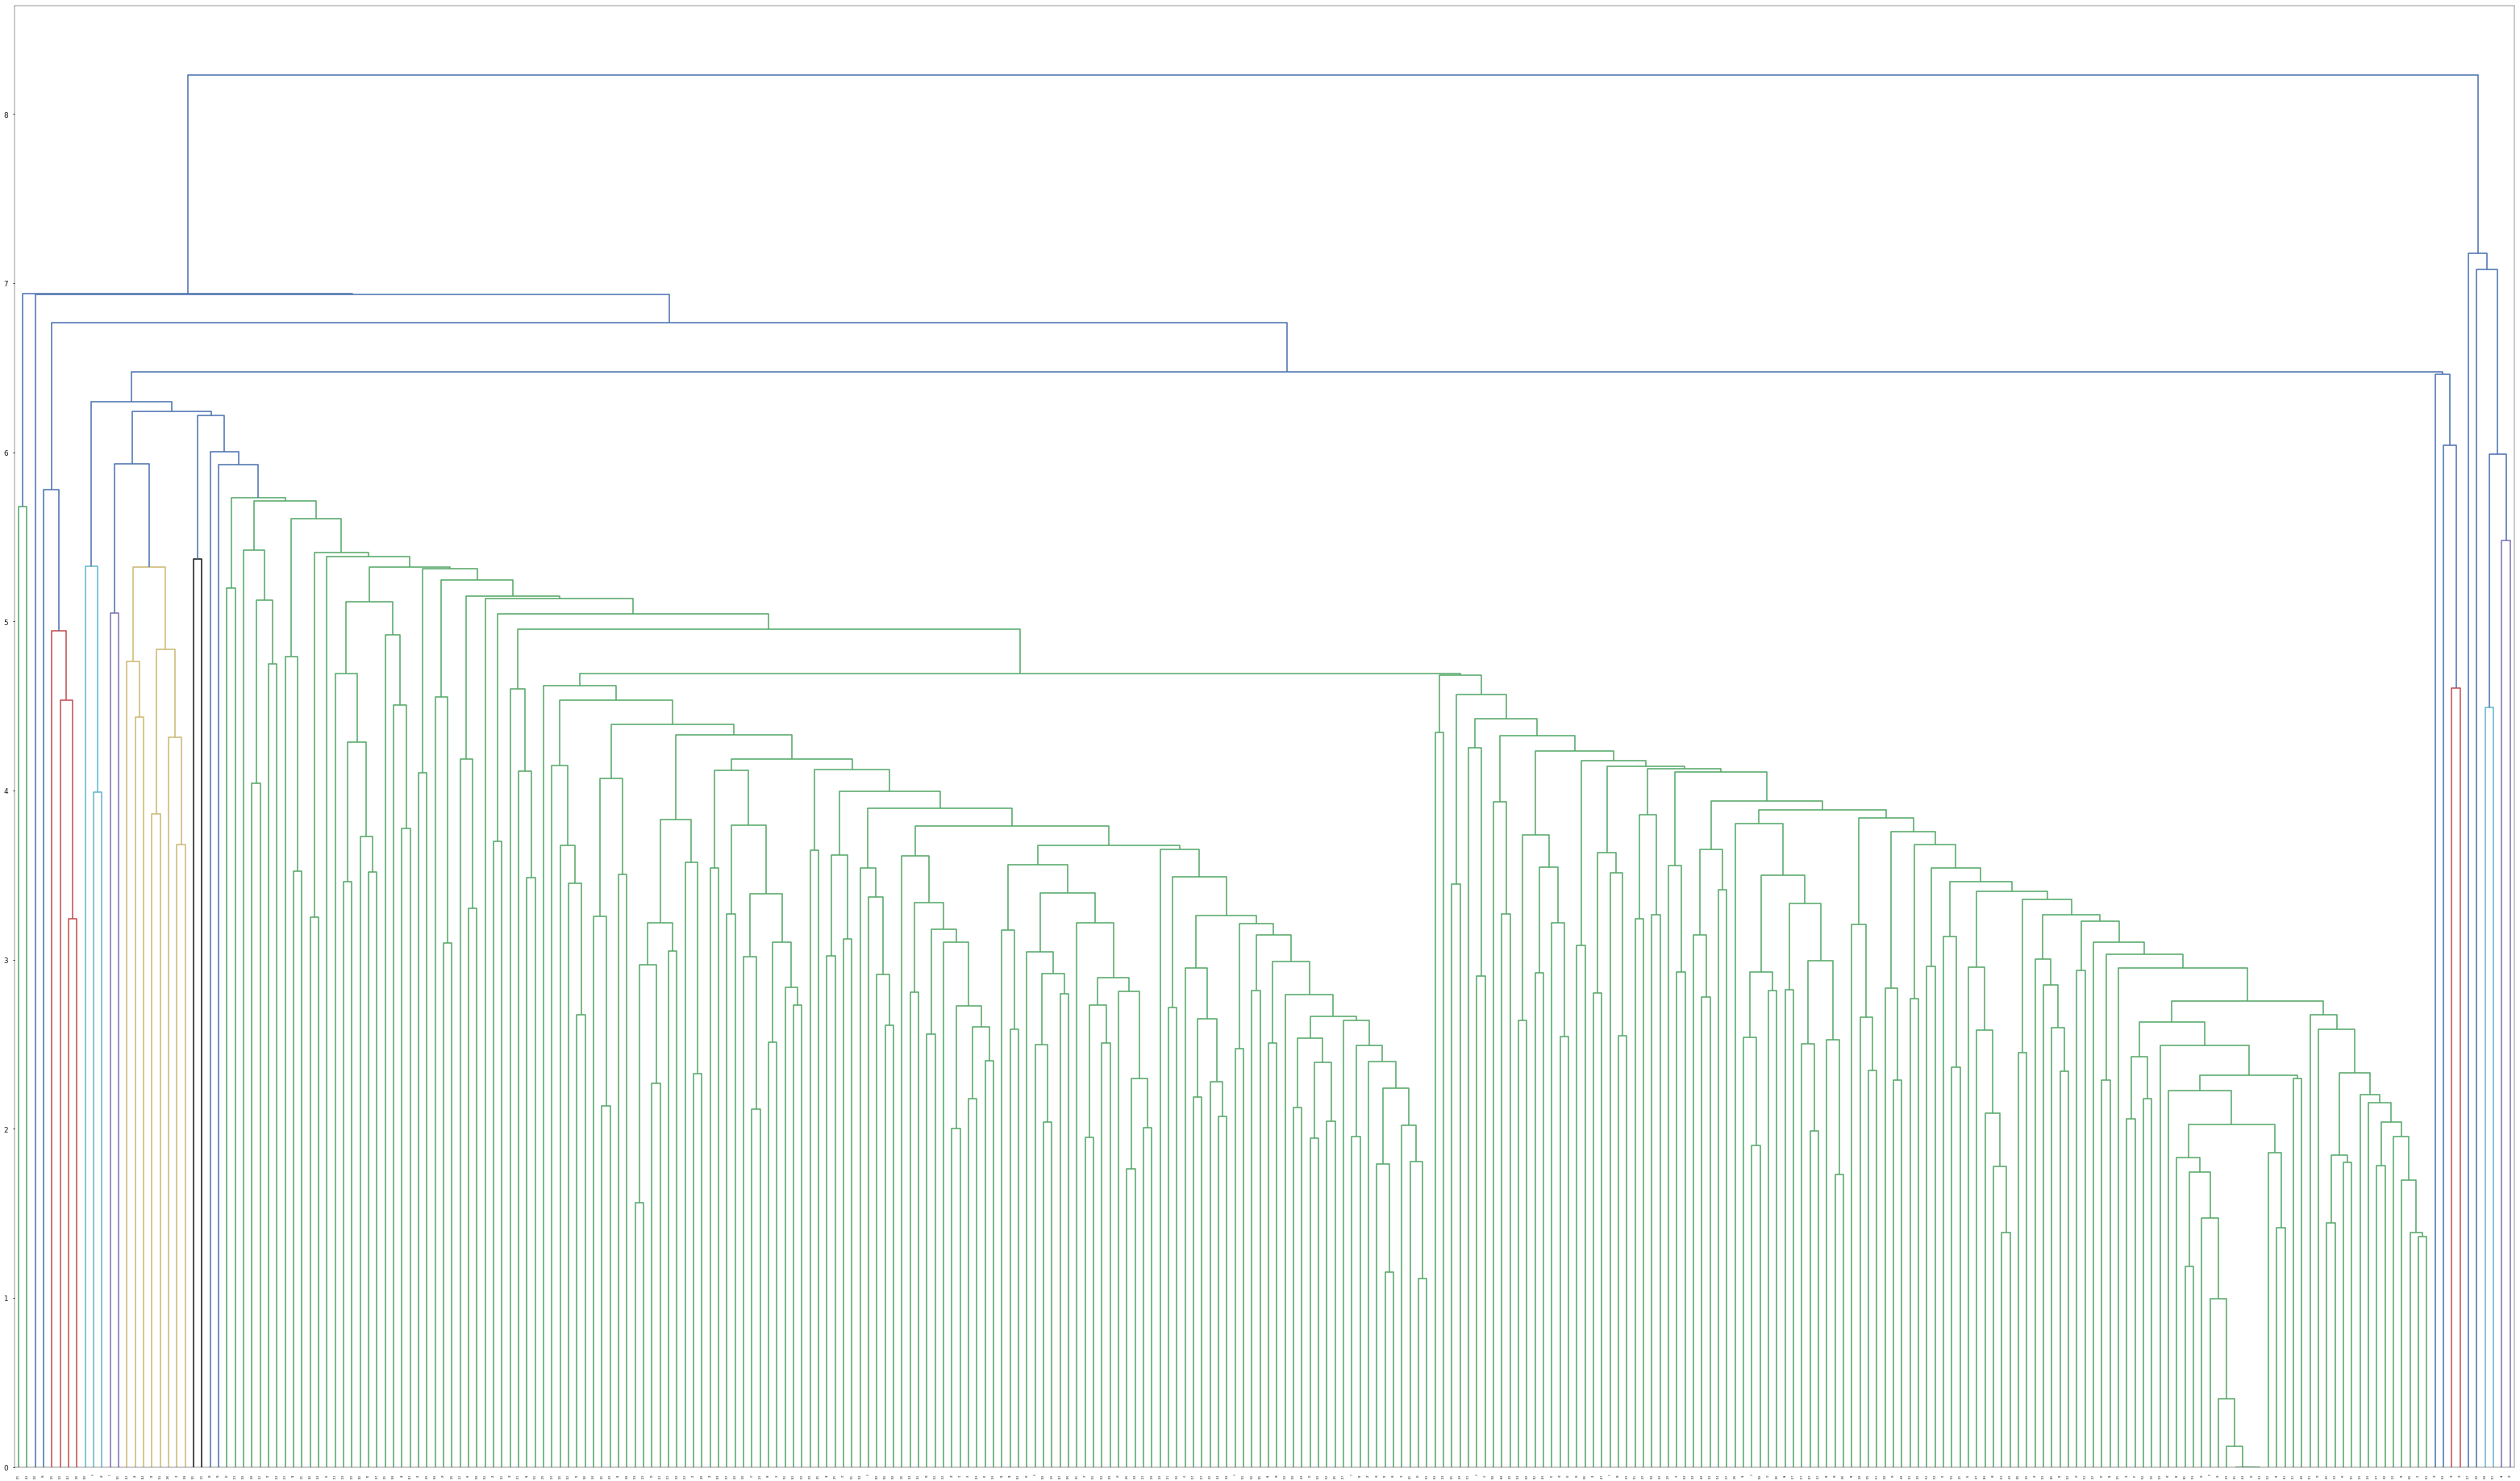

Presidio Cocina Mexicana,519 W Thomas Rd,Phoenix,AZ
Phoenix City Grille,5816 N 16th St,Phoenix,AZ
Lakeside Hideout Cafe,11225 N 28th Dr,Phoenix,AZ
Cafe 1010,1010 W Washington St,Phoenix,AZ
City Square Deli & Grill,22601 N 19th Ave, Ste 121,Phoenix,AZ
Helio Basin Brewing,3935 E Thomas Rd,Phoenix,AZ
Lux Central,4400 N Central Ave,Phoenix,AZ
The Coronado,2201 N 7th St,Phoenix,AZ
Ollie Vaughn's,1526 E McDowell Rd,Phoenix,AZ
Beneficial Beans,1221 N Central Ave,Phoenix,AZ
The Dressing Room,220 E Roosevelt St,Phoenix,AZ
Shorty's Sandwich Shop,3767 E Broadway Rd, Ste 8,Phoenix,AZ
Nana Tee's Hometown Dogs,4212 W Cactus Rd, Ste 1107,Phoenix,AZ
Ncounter,888 N 1st Ave, Ste 114,Phoenix,AZ
My Gal Sal Bakery & Catering,15820 N 35th Ave, Ste 18,Phoenix,AZ
Hidden Track Café,111 W Monroe St, Ste 121,Phoenix,AZ
Jacked Ice,,Phoenix,AZ
La Casita Cafe,6036 S 7th Ave, Ste 110,Phoenix,AZ
Tuck Shop,2245 N 12th St,Phoenix,AZ
Hit Ratio:  0.703296703297
NDCG:  0.824389753574





Recommendation info summary for :

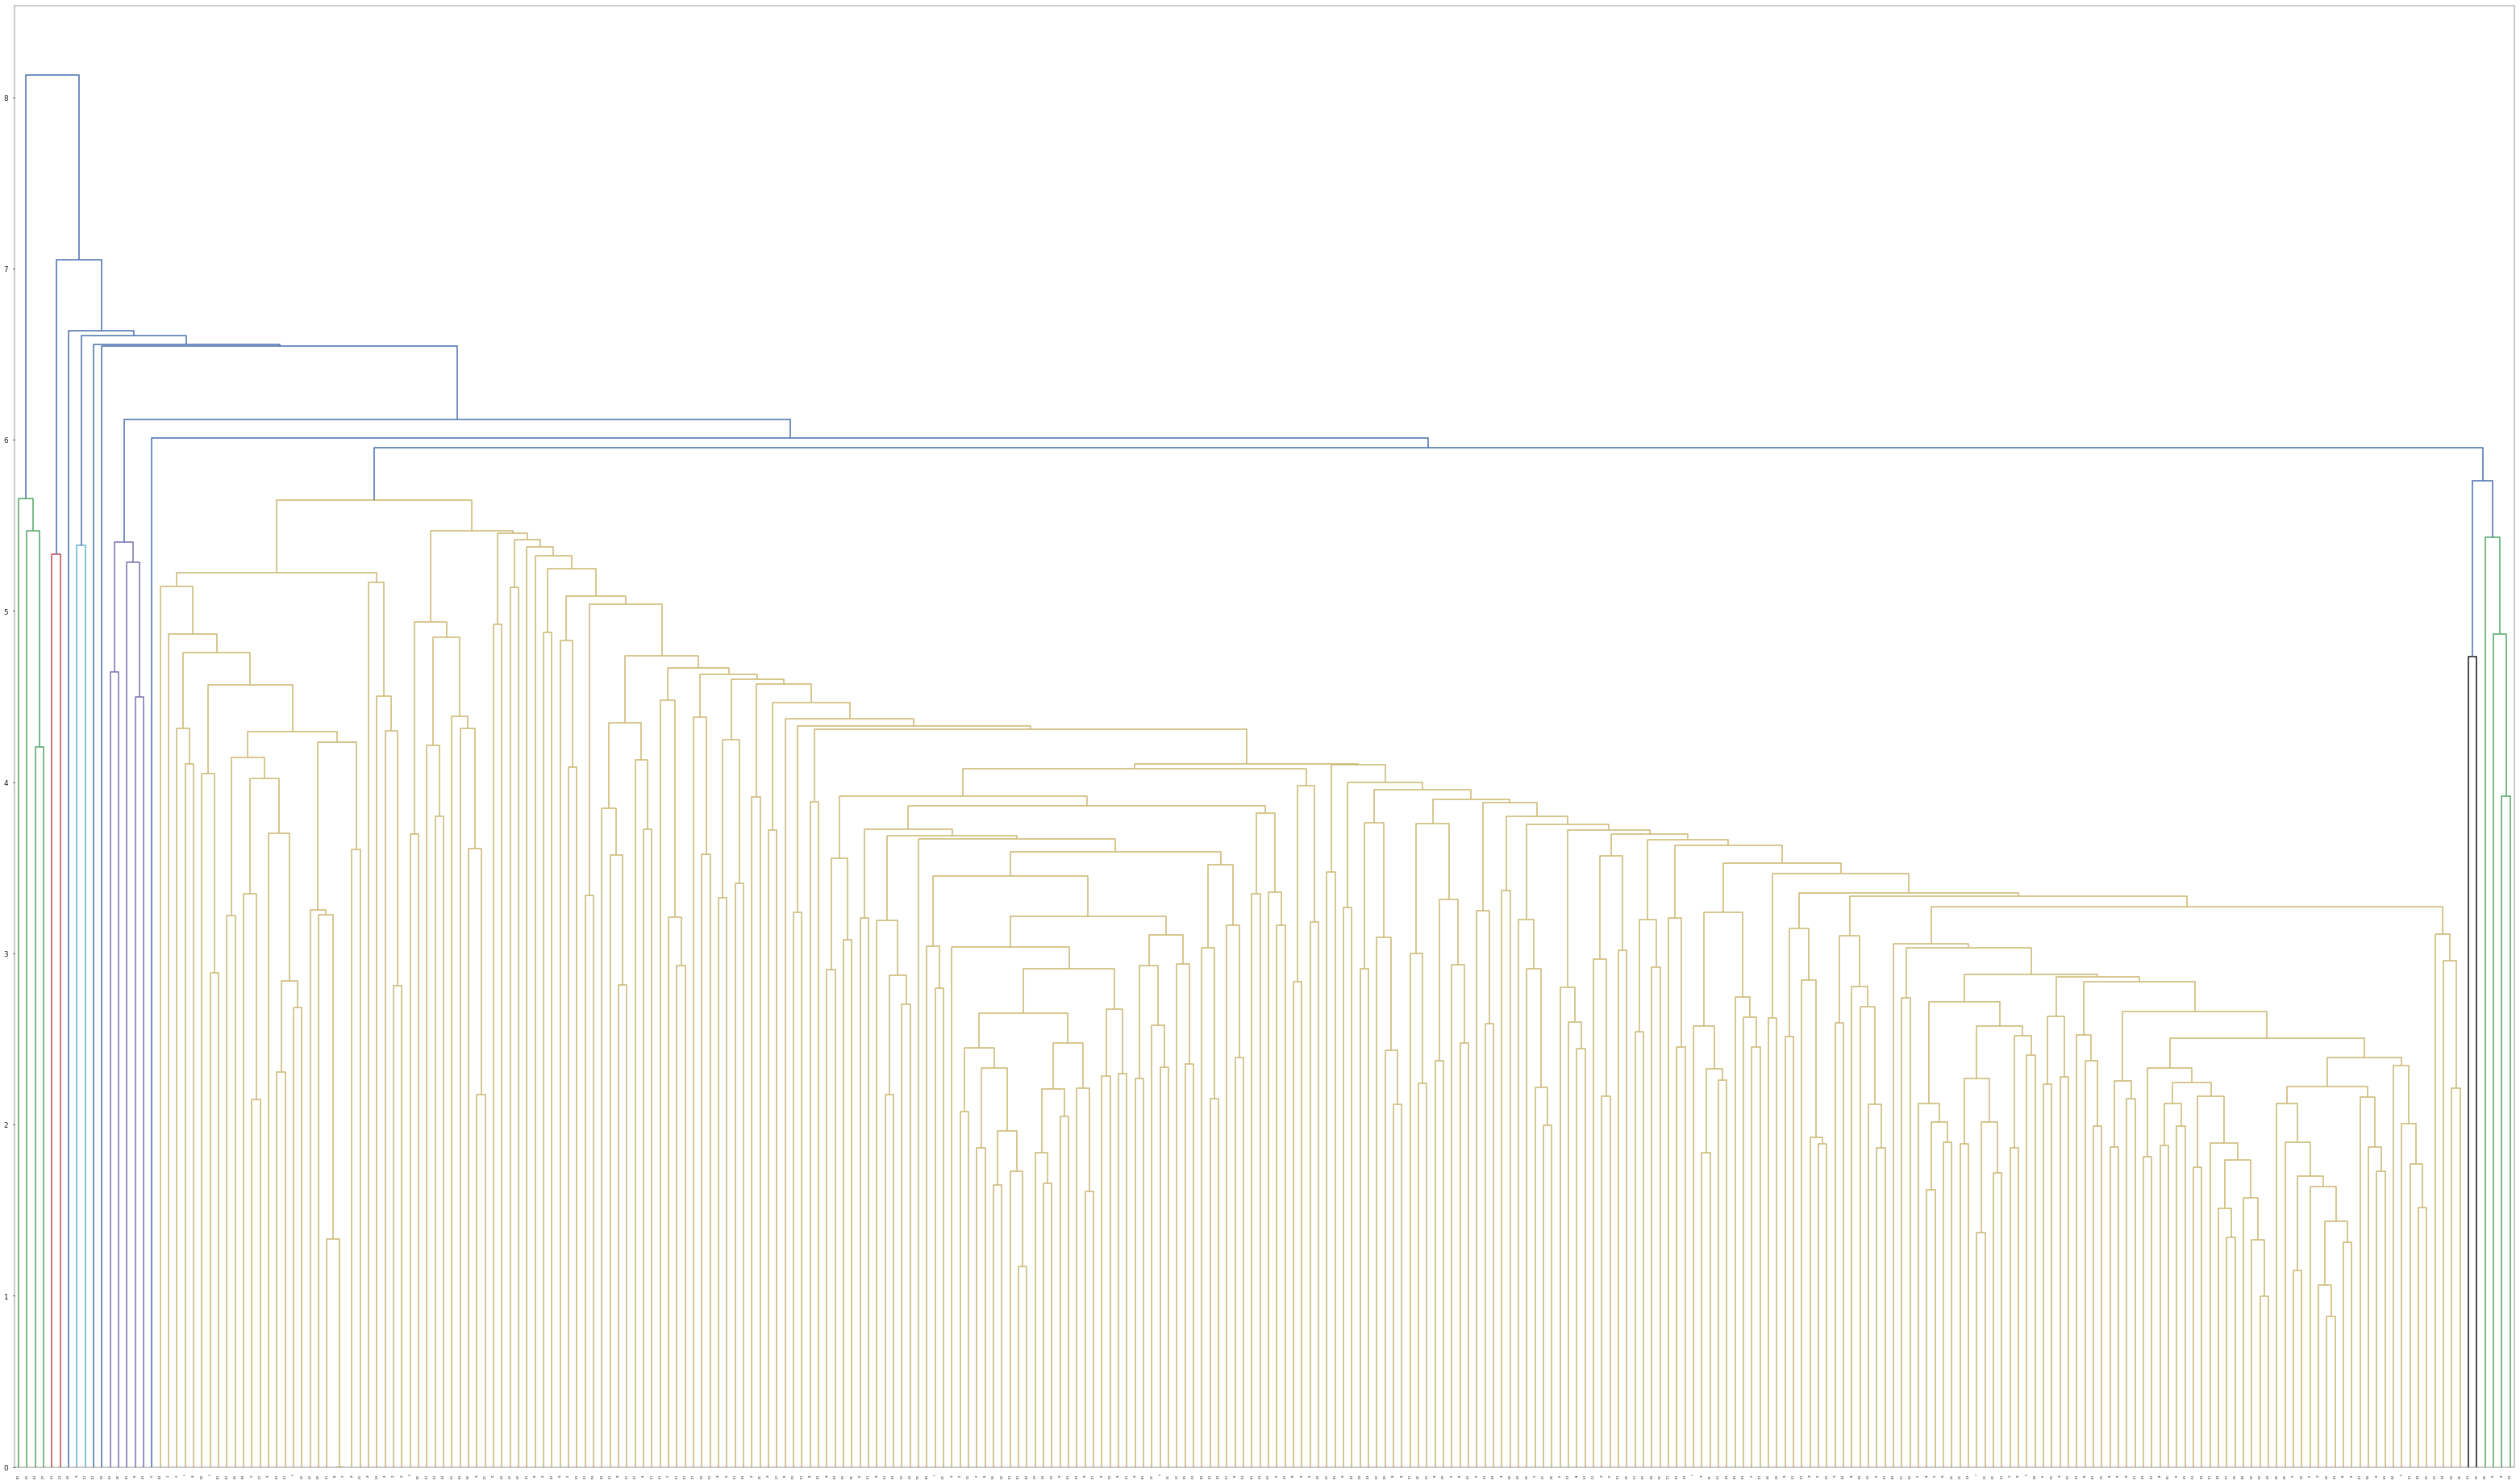

HoneyBaked Ham,5700 University Pointe Blvd, Suite 115,Charlotte,NC
The Cookin Coop,,Charlotte,NC
The Tasty Bowl Subs N Such,2900 Westinghouse Blvd, Ste 116,Charlotte,NC
Chicken King,3222 Rozzelles Ferry Rd,Charlotte,NC
Circles Grill and Market,8129 Ardrey Kell Rd,Charlotte,NC
Rhino Market & Deli,1500 W Morehead St, Ste E,Charlotte,NC
The Turnhouse Grille,1600 E Woodlawn Rd, Ste 100,Charlotte,NC
Murphy's Kitchen & Tap,445 W Trade St,Charlotte,NC
Bedder Bedder & Moore Montford-Abbey,1730 Abbey Pl, Ste 4,Charlotte,NC
300 East,300 East Blvd,Charlotte,NC
Chicken Salad Chick,7617-C Pineville-Matthews Rd,Charlotte,NC
Whooli's Grill,7146 E Independence Blvd,Charlotte,NC
The Great Wagon Road Distilling Co,227 Southside Dr,Charlotte,NC
The Peace Pipe,204 W Woodlawn Rd, Ste H,Charlotte,NC
My Camille's,9211 N Tryon St, Ste 9,Charlotte,NC
Rush Espresso Cafe and Wine Bar,14825 Ballantyne Village Way, Ste 135,Charlotte,NC
Great Harvest Bread,1824 E Arbors Dr, Ste 390,Charlotte,NC
Studio Cellar,1800 C

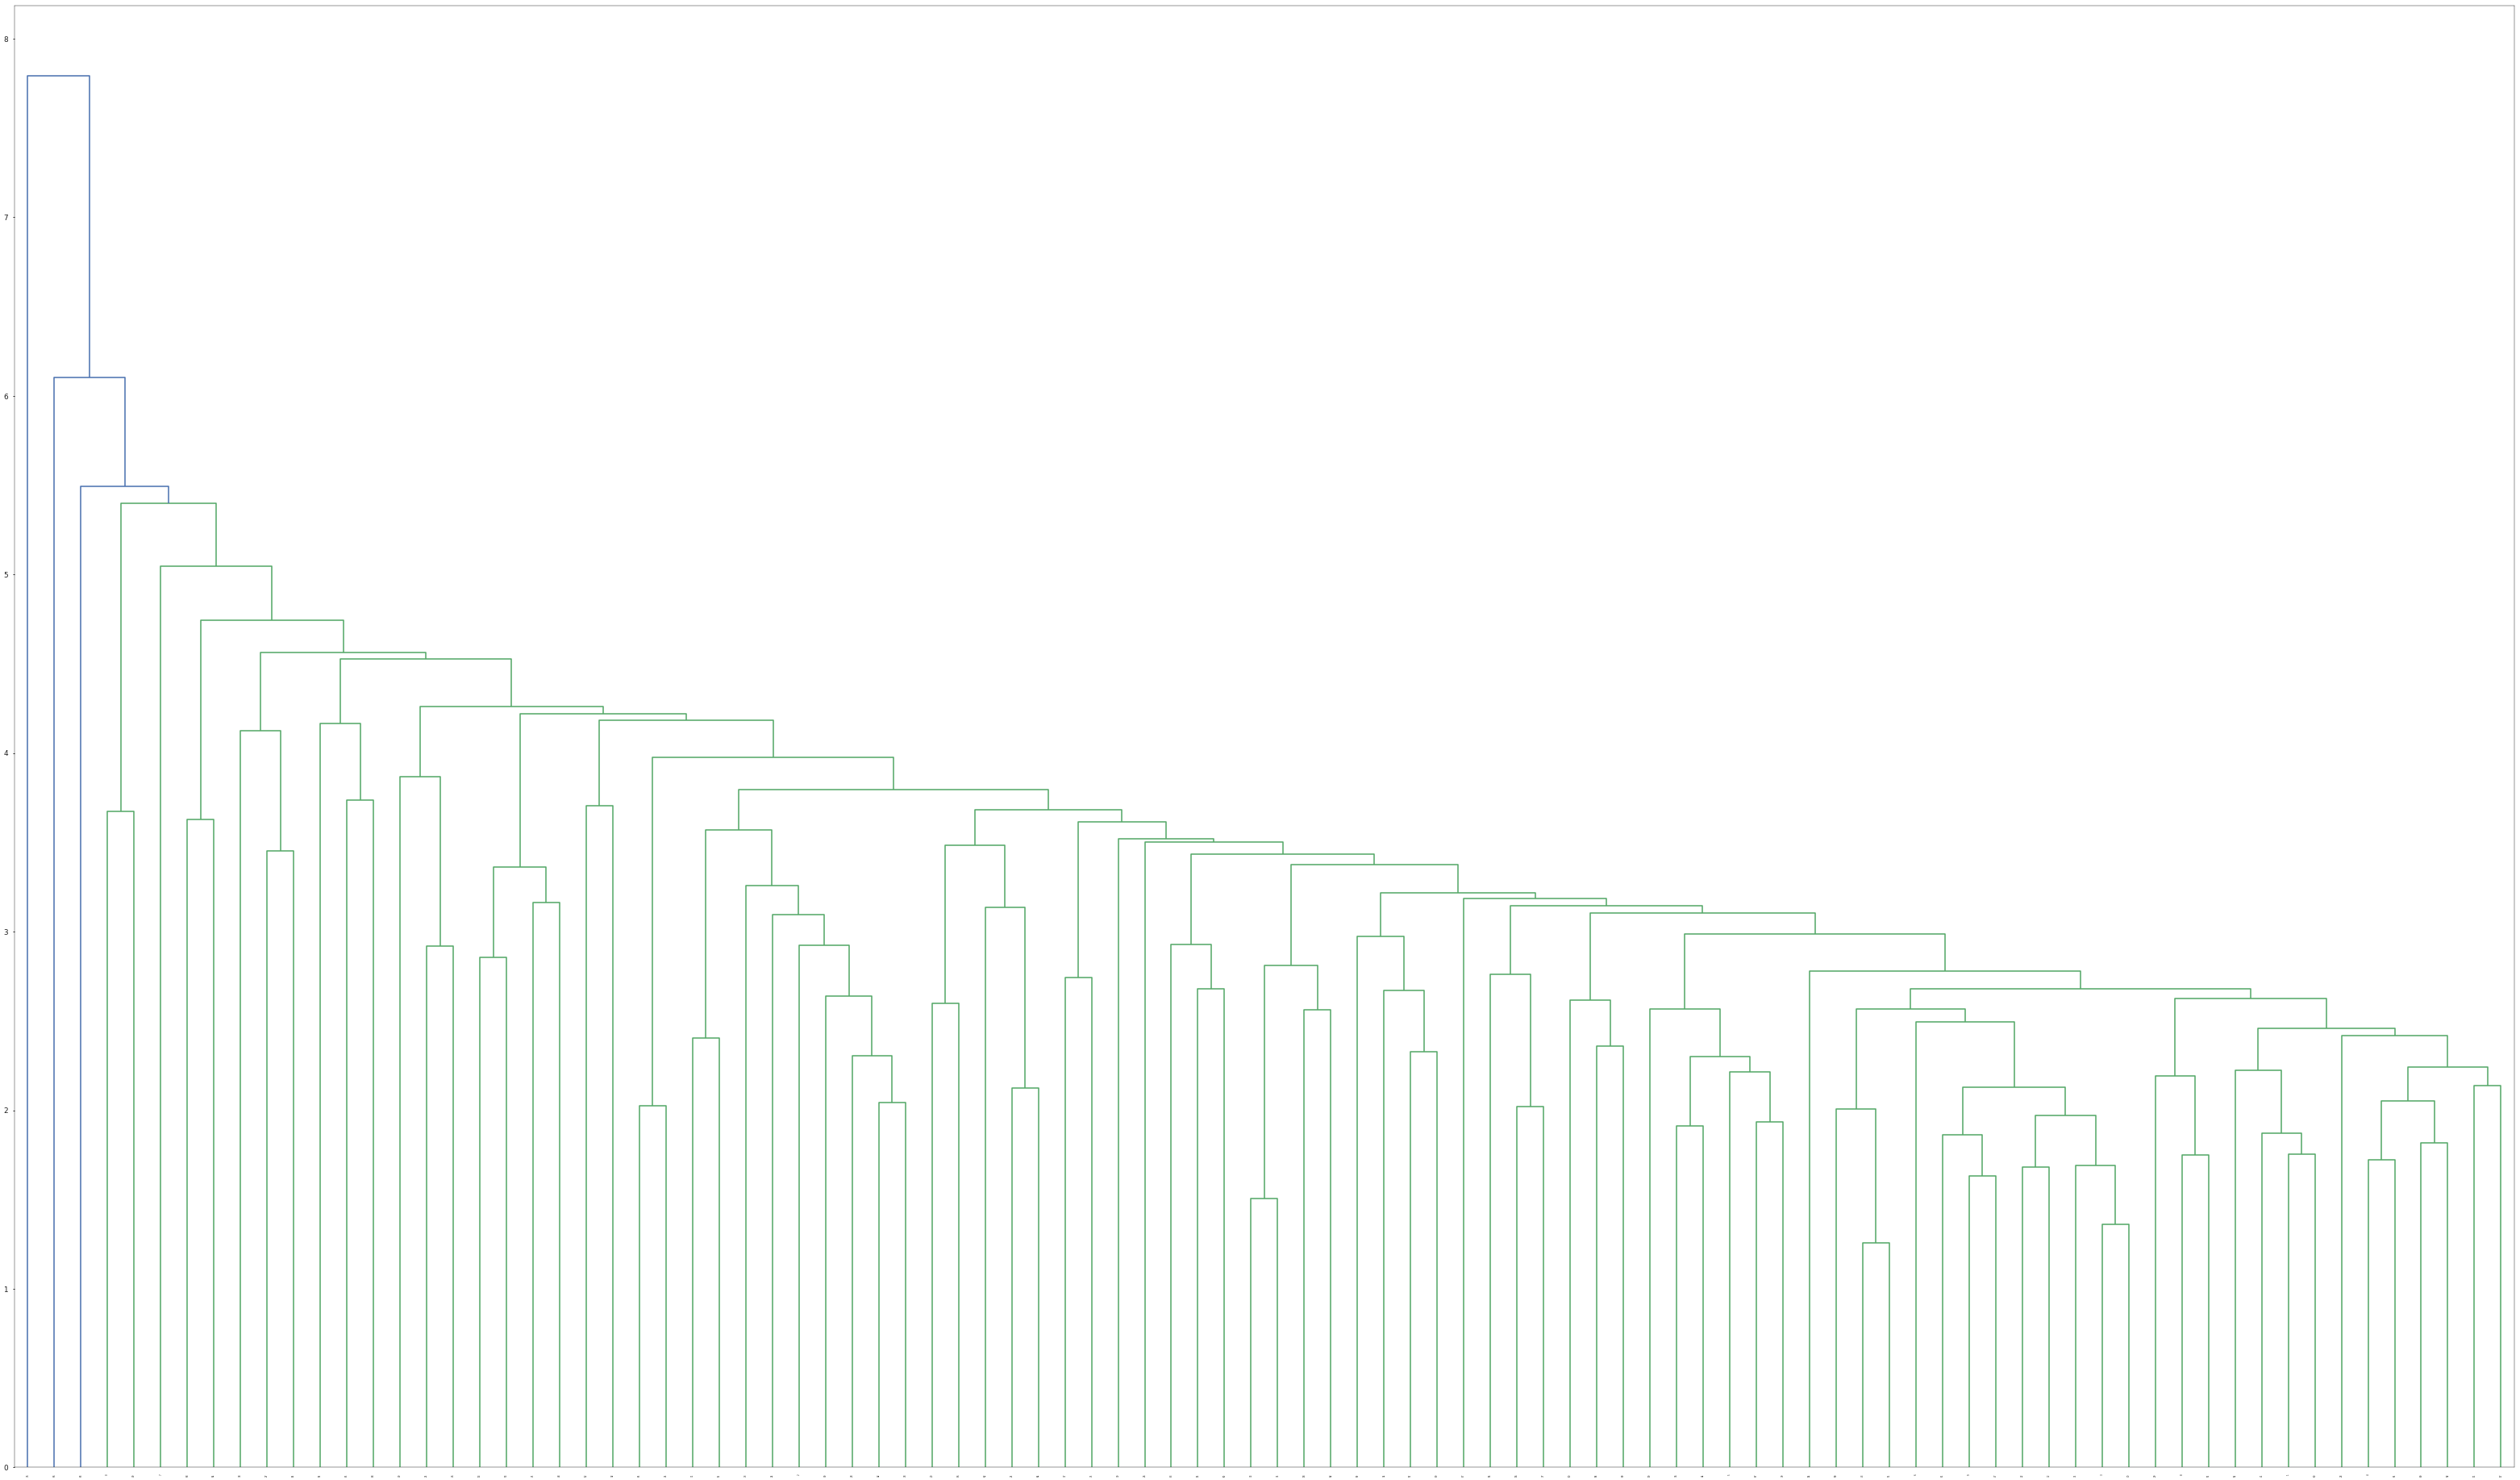

Colonnades,The Signet Library, Parliament Square, The Royal Mile,Edinburgh,EDH
Uncle T's,8 Forrest Road,Edinburgh,EDH
Colonial House,305 Leith Walk,Edinburgh,EDH
Black Dutch Cafe Bar,91 Montgomery Street,Edinburgh,EDH
Sala Cafe Bar,58a Broughton Street,Edinburgh,EDH
Filament Coffee,5 India Buildings, Victoria Street,Edinburgh,EDH
Cafe Cassis,43-45 Salisbury Road,Edinburgh,EDH
The Safari Lounge,21 Cadzow Place, London Road,Edinburgh,EDH
Gannet and Guga,Unit 2-3 The Arches, East Market Street,Edinburgh,EDH
The Grain Store,30 Victoria Street,Edinburgh,EDH
Badger & Co.,32 Castle Street,Edinburgh,EDH
Nobles Cafe Bar & Venue,44a Constitution Street, Leith,Edinburgh,EDH
Joseph Pearce,23 Elm Row,Edinburgh,EDH
Edinburgh Coffee Cake,18 S Clerk Street,Edinburgh,EDH
Patisserie Madeleine,27b Raeburn Place,Edinburgh,EDH
The Cocktail Emporium,44 Broughton Street,Edinburgh,EDH
Stockbridge Kitchen,7 Bakers Place,Edinburgh,EDH
Bollywood The Coffee Box,99A Bruntsfield Place,Edinburgh,EDH
Graze On Grassma

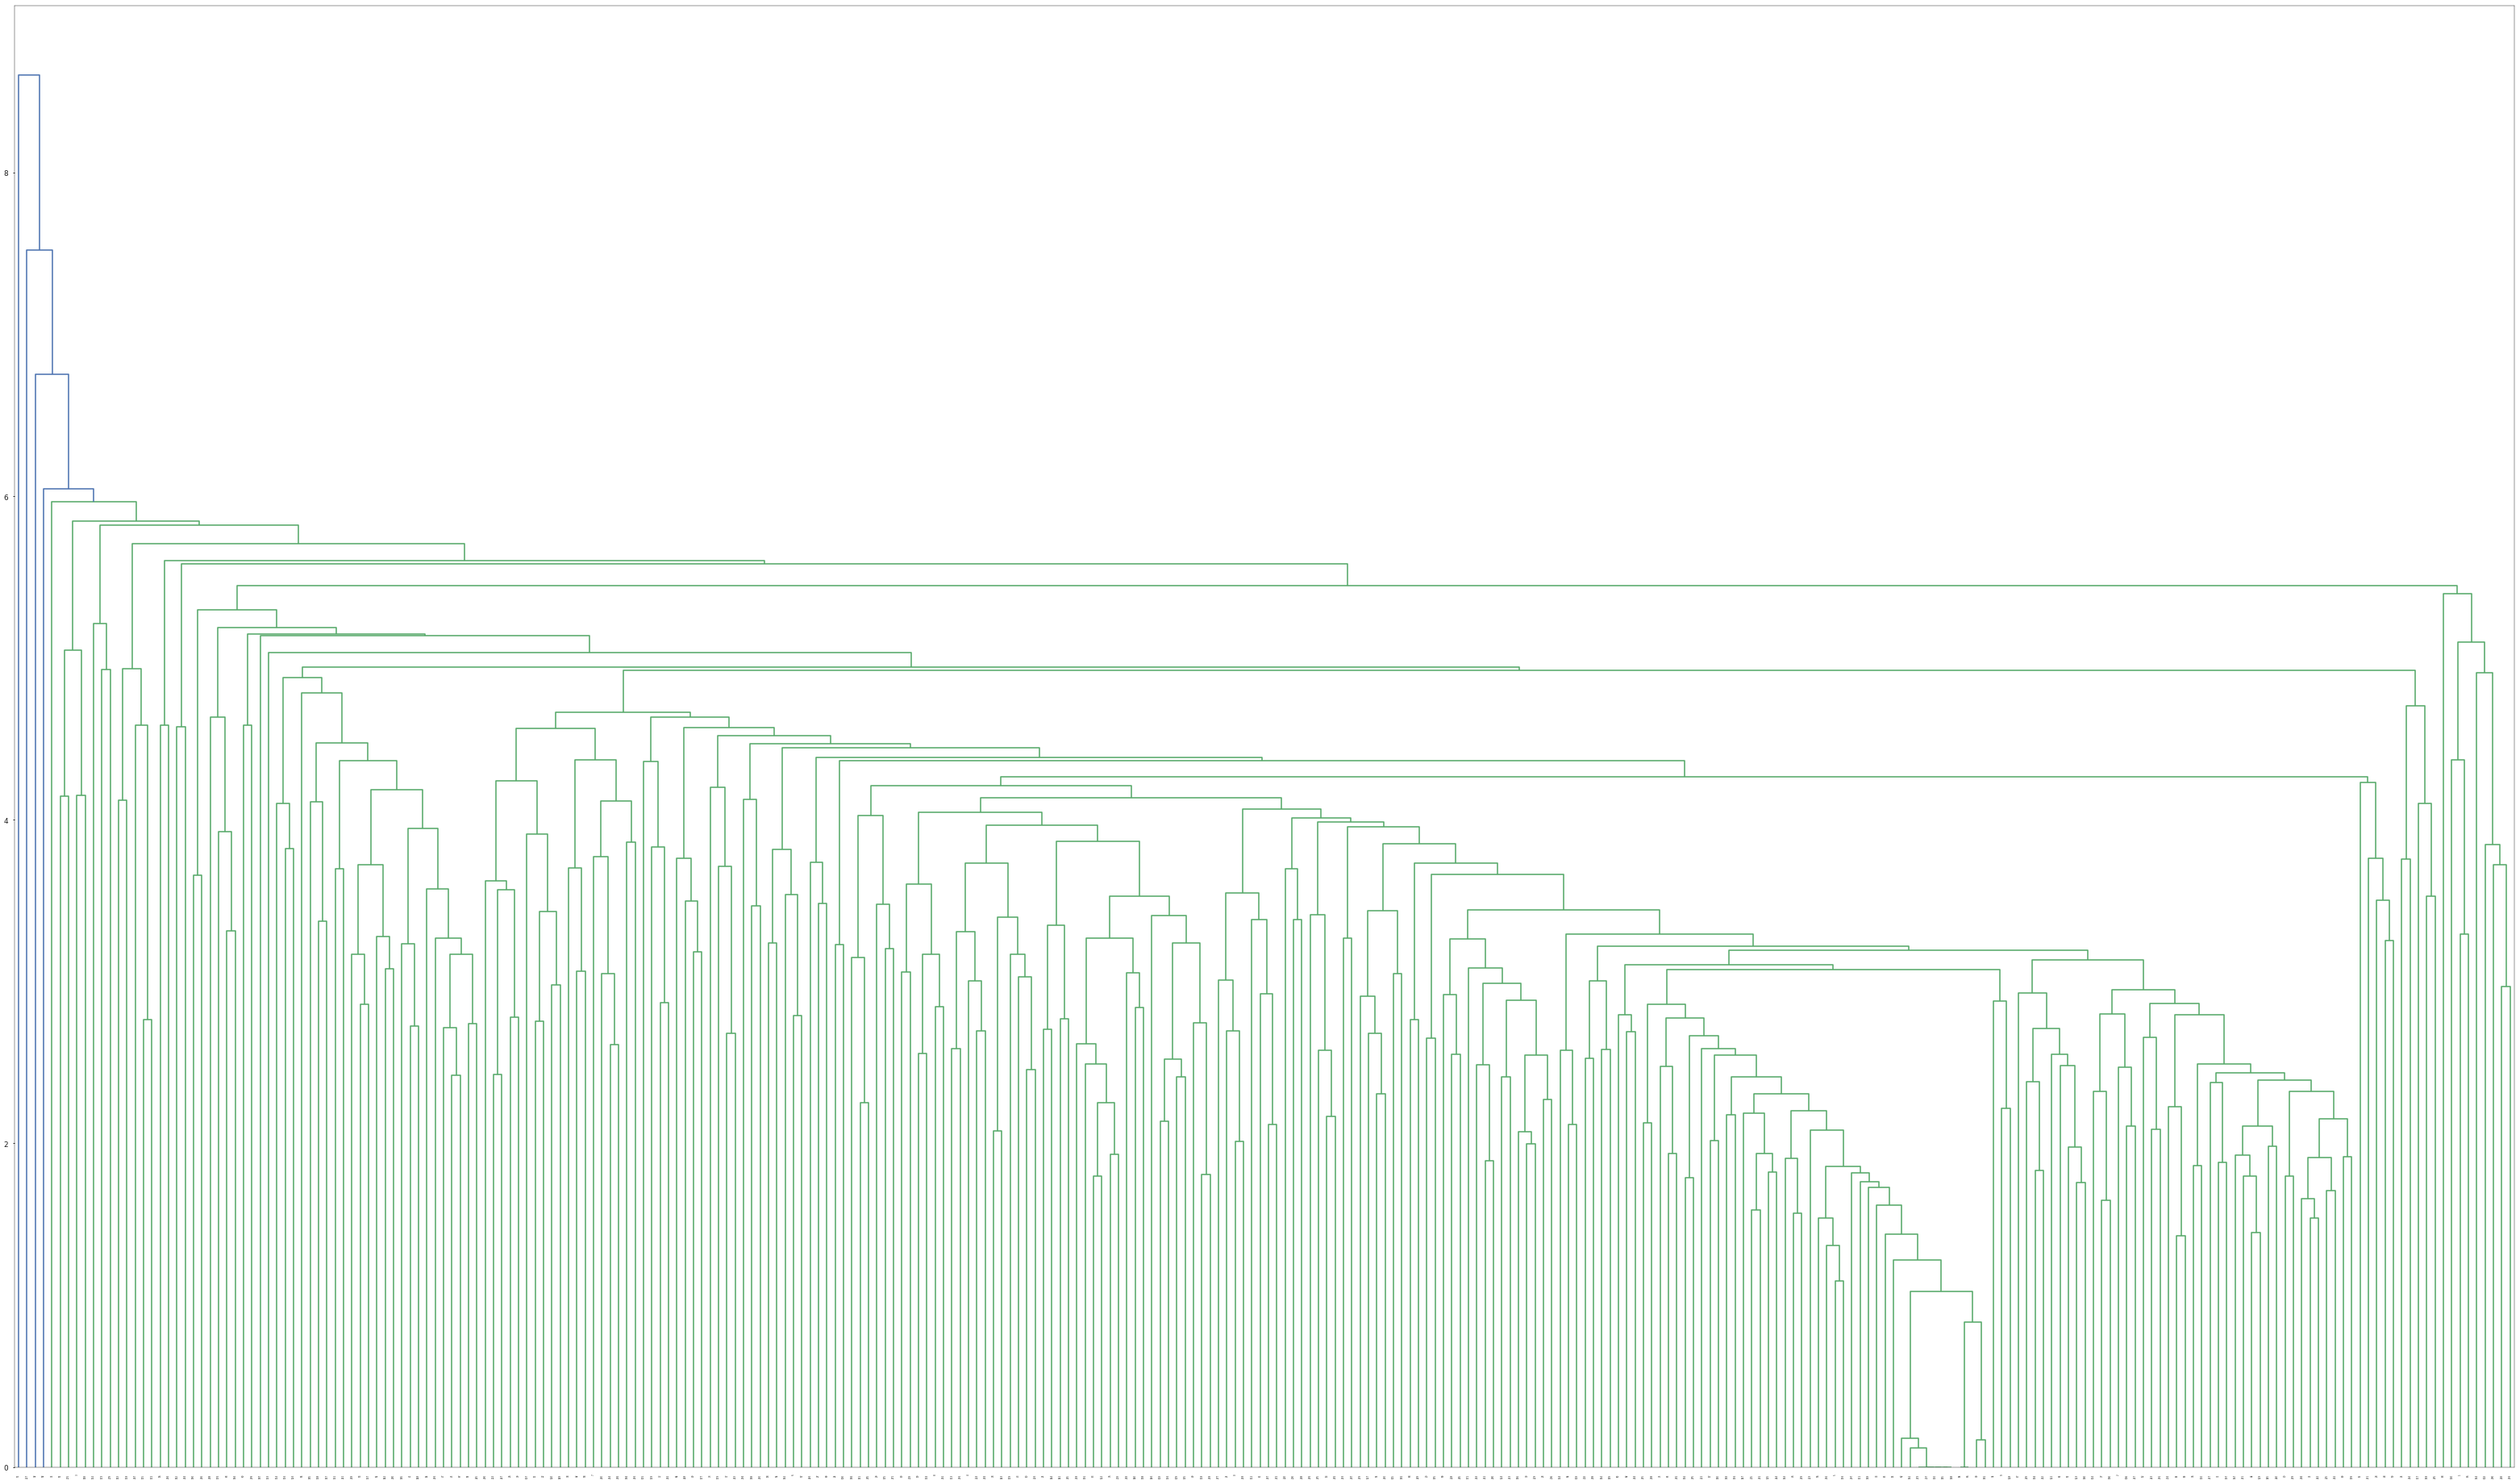

Arancini House,615 Washington Rd,Pittsburgh,PA
Skinny Pete's Kitchen,538 California Ave,Pittsburgh,PA
Proper Brick Oven & Tap Room,139 7th St,Pittsburgh,PA
Joey D's in the Park, RIDC,180 Gamma Dr,Pittsburgh,PA
Mixtape,4907 Penn Ave,Pittsburgh,PA
Marketplace Cafe,Nordstrom, 1000 Ross Park Mall Dr,Pittsburgh,PA
The Alcove,875 Greentree Rd, Ste 6, Bldg 4,Pittsburgh,PA
Leaf and Plate,5884 Ellsworth Ave, 1st Fl,Pittsburgh,PA
Redwood Cafe,698 Washington Rd,Pittsburgh,PA
Smallman Galley,54 21st St,Pittsburgh,PA
Carson Street Deli & Craft Beer Bar,1507 E Carson St,Pittsburgh,PA
Perspolis Hookah Lounge,304 N Craig St,Pittsburgh,PA
S&D Cafe,1425 Forbes Ave,Pittsburgh,PA
Lexus Club at PNC Park,115 Federal St,Pittsburgh,PA
Wood Fired Flatbreads,625 Lowries Run Rd, Ste 200,Pittsburgh,PA
Altius,1230 Grandview Ave,Pittsburgh,PA
Verde Good Beans,412 First Ave,Pittsburgh,PA
Bakersfield Penn Ave,940 Penn Ave,Pittsburgh,PA
Subway,4721 Mcknight Rd,Pittsburgh,PA
Hit Ratio:  0.739130434783
NDCG:  0.84471952

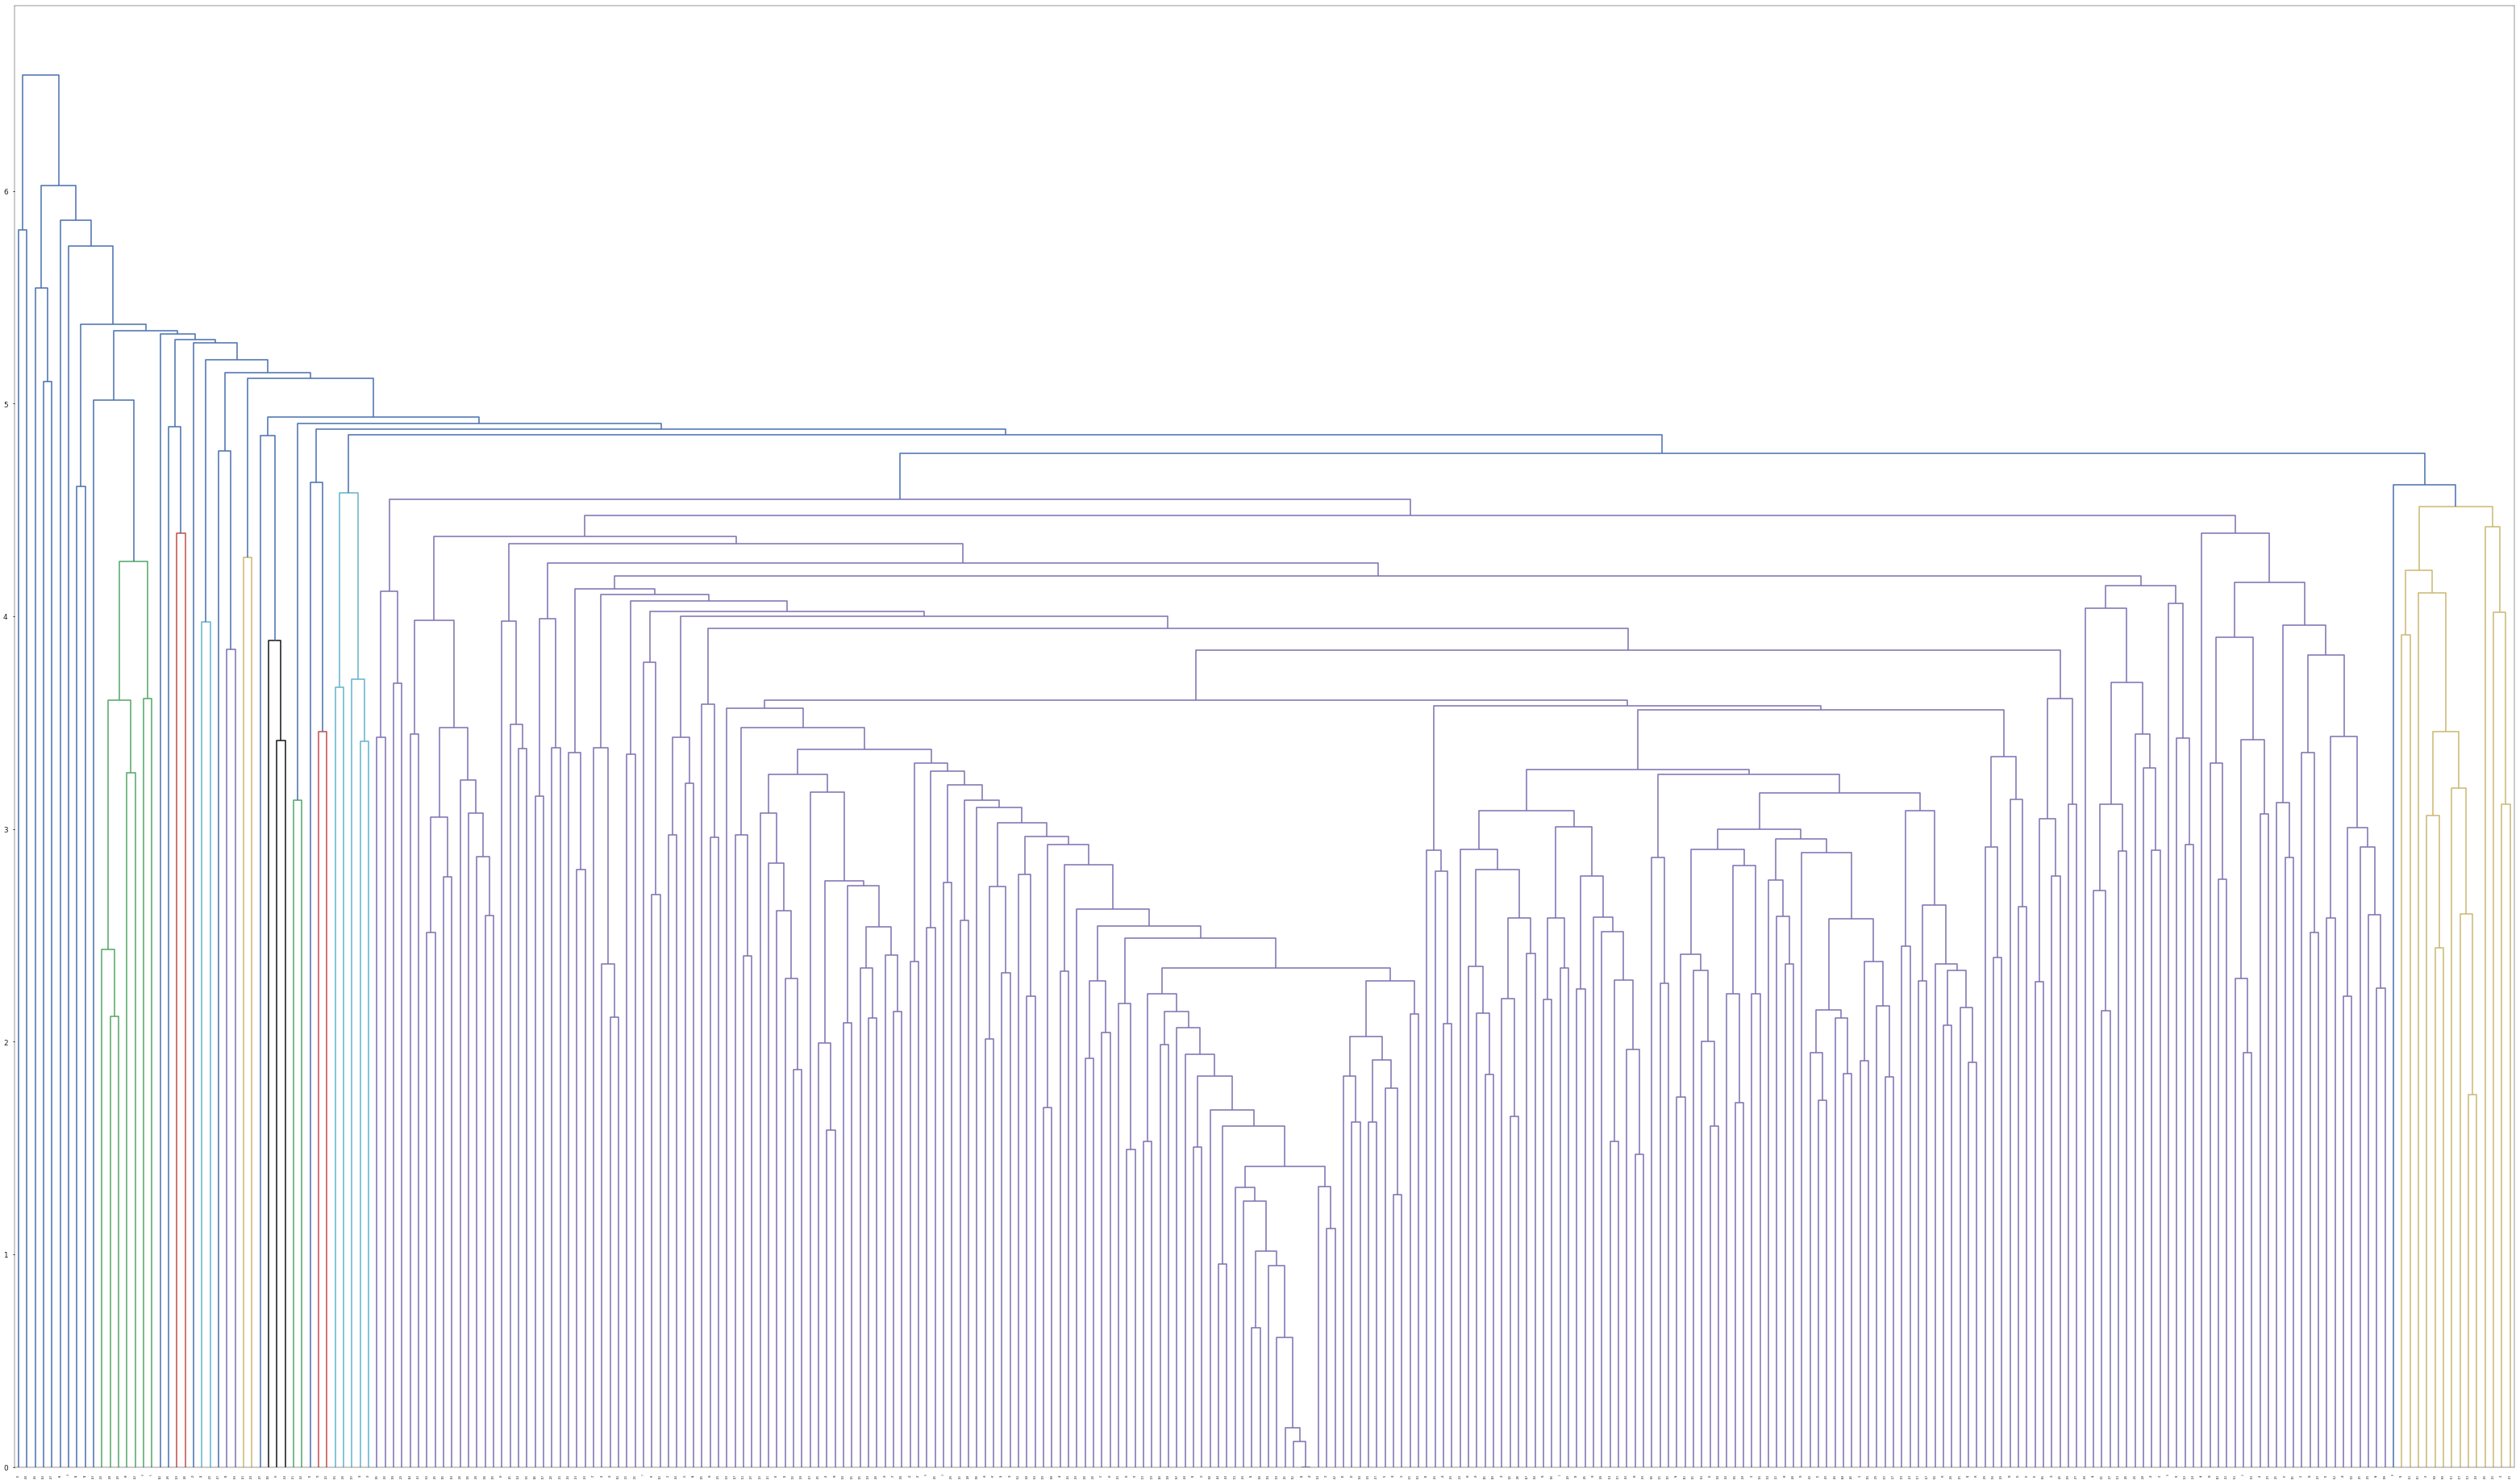

Bouffe Dave Plant Food,1206 Boulevard de Maisonneuve E,Montréal,QC
Café de' Mercanti,350 Rue Notre-Dame Est,Montréal,QC
Novanta Café,90 Avenue Laurier O,Montréal,QC
Café Tuyo,370 Rue Marie-Anne,Montréal,QC
Farine,102 Saint-Viateur Ouest,Montréal,QC
Yummy2Go,Métro Atwater, 3015 Boulevard de Maisonneuve Ouest,Montréal,QC
Green,443 Avenue Viger O,Montréal,QC
Café Aléatoire,1964 rue Notre-Dame ouest,Montréal,QC
Kiffin,3439 Rue Saint-Denis,Montréal,QC
Belém Café & Yoga - L'Espace Café,4409 Boulevard Saint-Laurent,Montréal,QC
Salerno,2411 Avenue Charland,Montréal,QC
Chez Lavigne,4280 Rue Notre-Dame O,Montréal,QC
Un Autre Restaurant,200 Rue Saint-Viateur Ouest,Montréal,QC
Dans la Gueule du Loup,2055 Avenue Laurier E,Montréal,QC
La Rouladerie,1205 Avenue Bernard,Montréal,QC
Le Pier 66,361 Rue Bernard O,Montréal,QC
Le Majestique,4105 Boulevard Saint-Laurent,Montréal,QC
Auberge du Dragon Rouge,8870 Rue Lajeunesse,Montréal,QC
Kaiji Sushi,2115 Jean-Talon Est,Montréal,QC
Hit Ratio:  0.625
NDCG:  0.

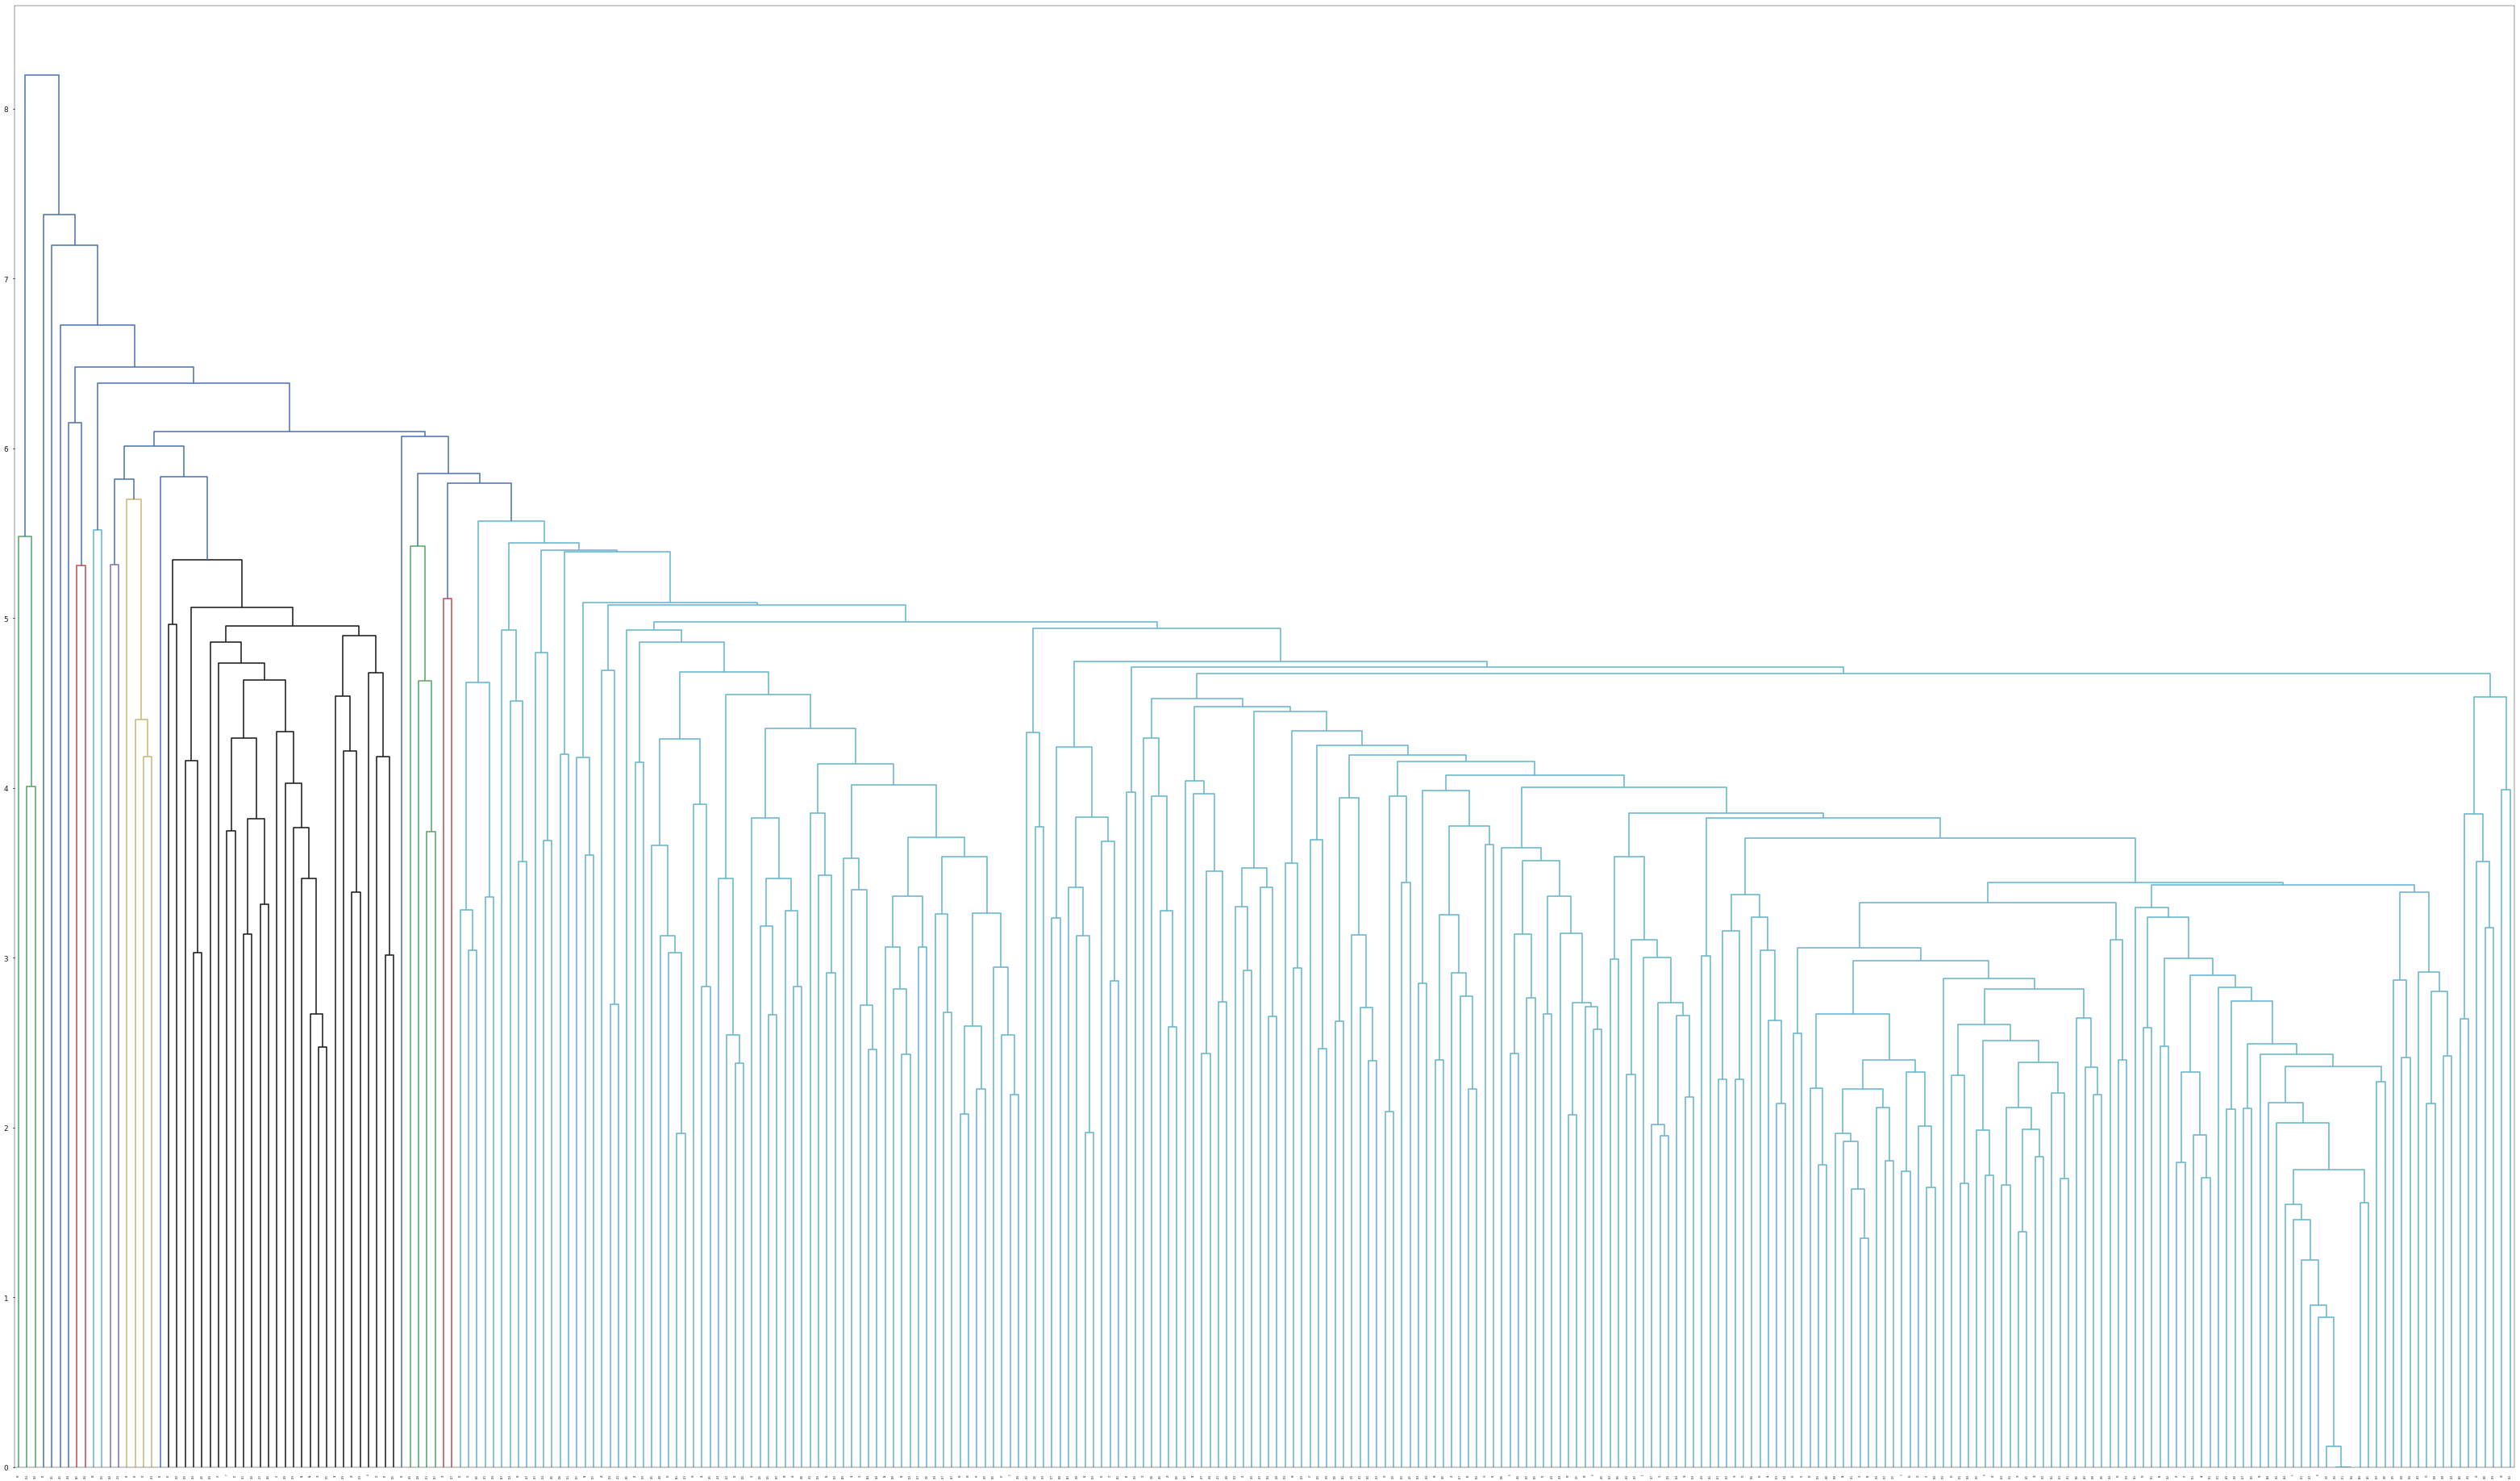

The Original Marketplace,7272 E Indian School Rd, Ste 105,Scottsdale,AZ
Sorso Wine Room,15323 N Scottsdale Rd, Ste 150,Scottsdale,AZ
B&R Wine - Food,7366 E Shea Blvd, Ste 112,Scottsdale,AZ
CM2 Pizzeria & Bakeshop,11485 N 136th St,Scottsdale,AZ
Sugar Jam Bake Shop & Bistro,7950 E Redfield Rd,Scottsdale,AZ
Starfire Grille,11500 N Hayden Rd,Scottsdale,AZ
Snooze An AM Eatery,15054 N Scottsdale Rd, Ste 110 D18,Scottsdale,AZ
D'Lite Healthy On The Go,7337 E Shea Blvd, Ste 100,Scottsdale,AZ
Cafe Monarch,6934 E 1st Ave, Ste 102,Scottsdale,AZ
Tommy V's Urban Kitchen & Bar,7303 E Indian School Rd,Scottsdale,AZ
Pasto di Forno,7116 E Mercer Ln, Ste 101,Scottsdale,AZ
Turquoise Bar @ The Andaz,6114 North Scottsdale Rd,Scottsdale,AZ
East & West Cafe,8880 E Via Linda,Scottsdale,AZ
Street Cafe and Coffee Lounge,10435 N Scottsdale Rd,Scottsdale,AZ
Second Story Liquor Bar,4166 N Scottsdale Rd,Scottsdale,AZ
D'Lite Healthy On The Go,2613 N Scottsdale Rd,Scottsdale,AZ
Bubbles,6990 E Shea Blvd, Ste 107,Scotts

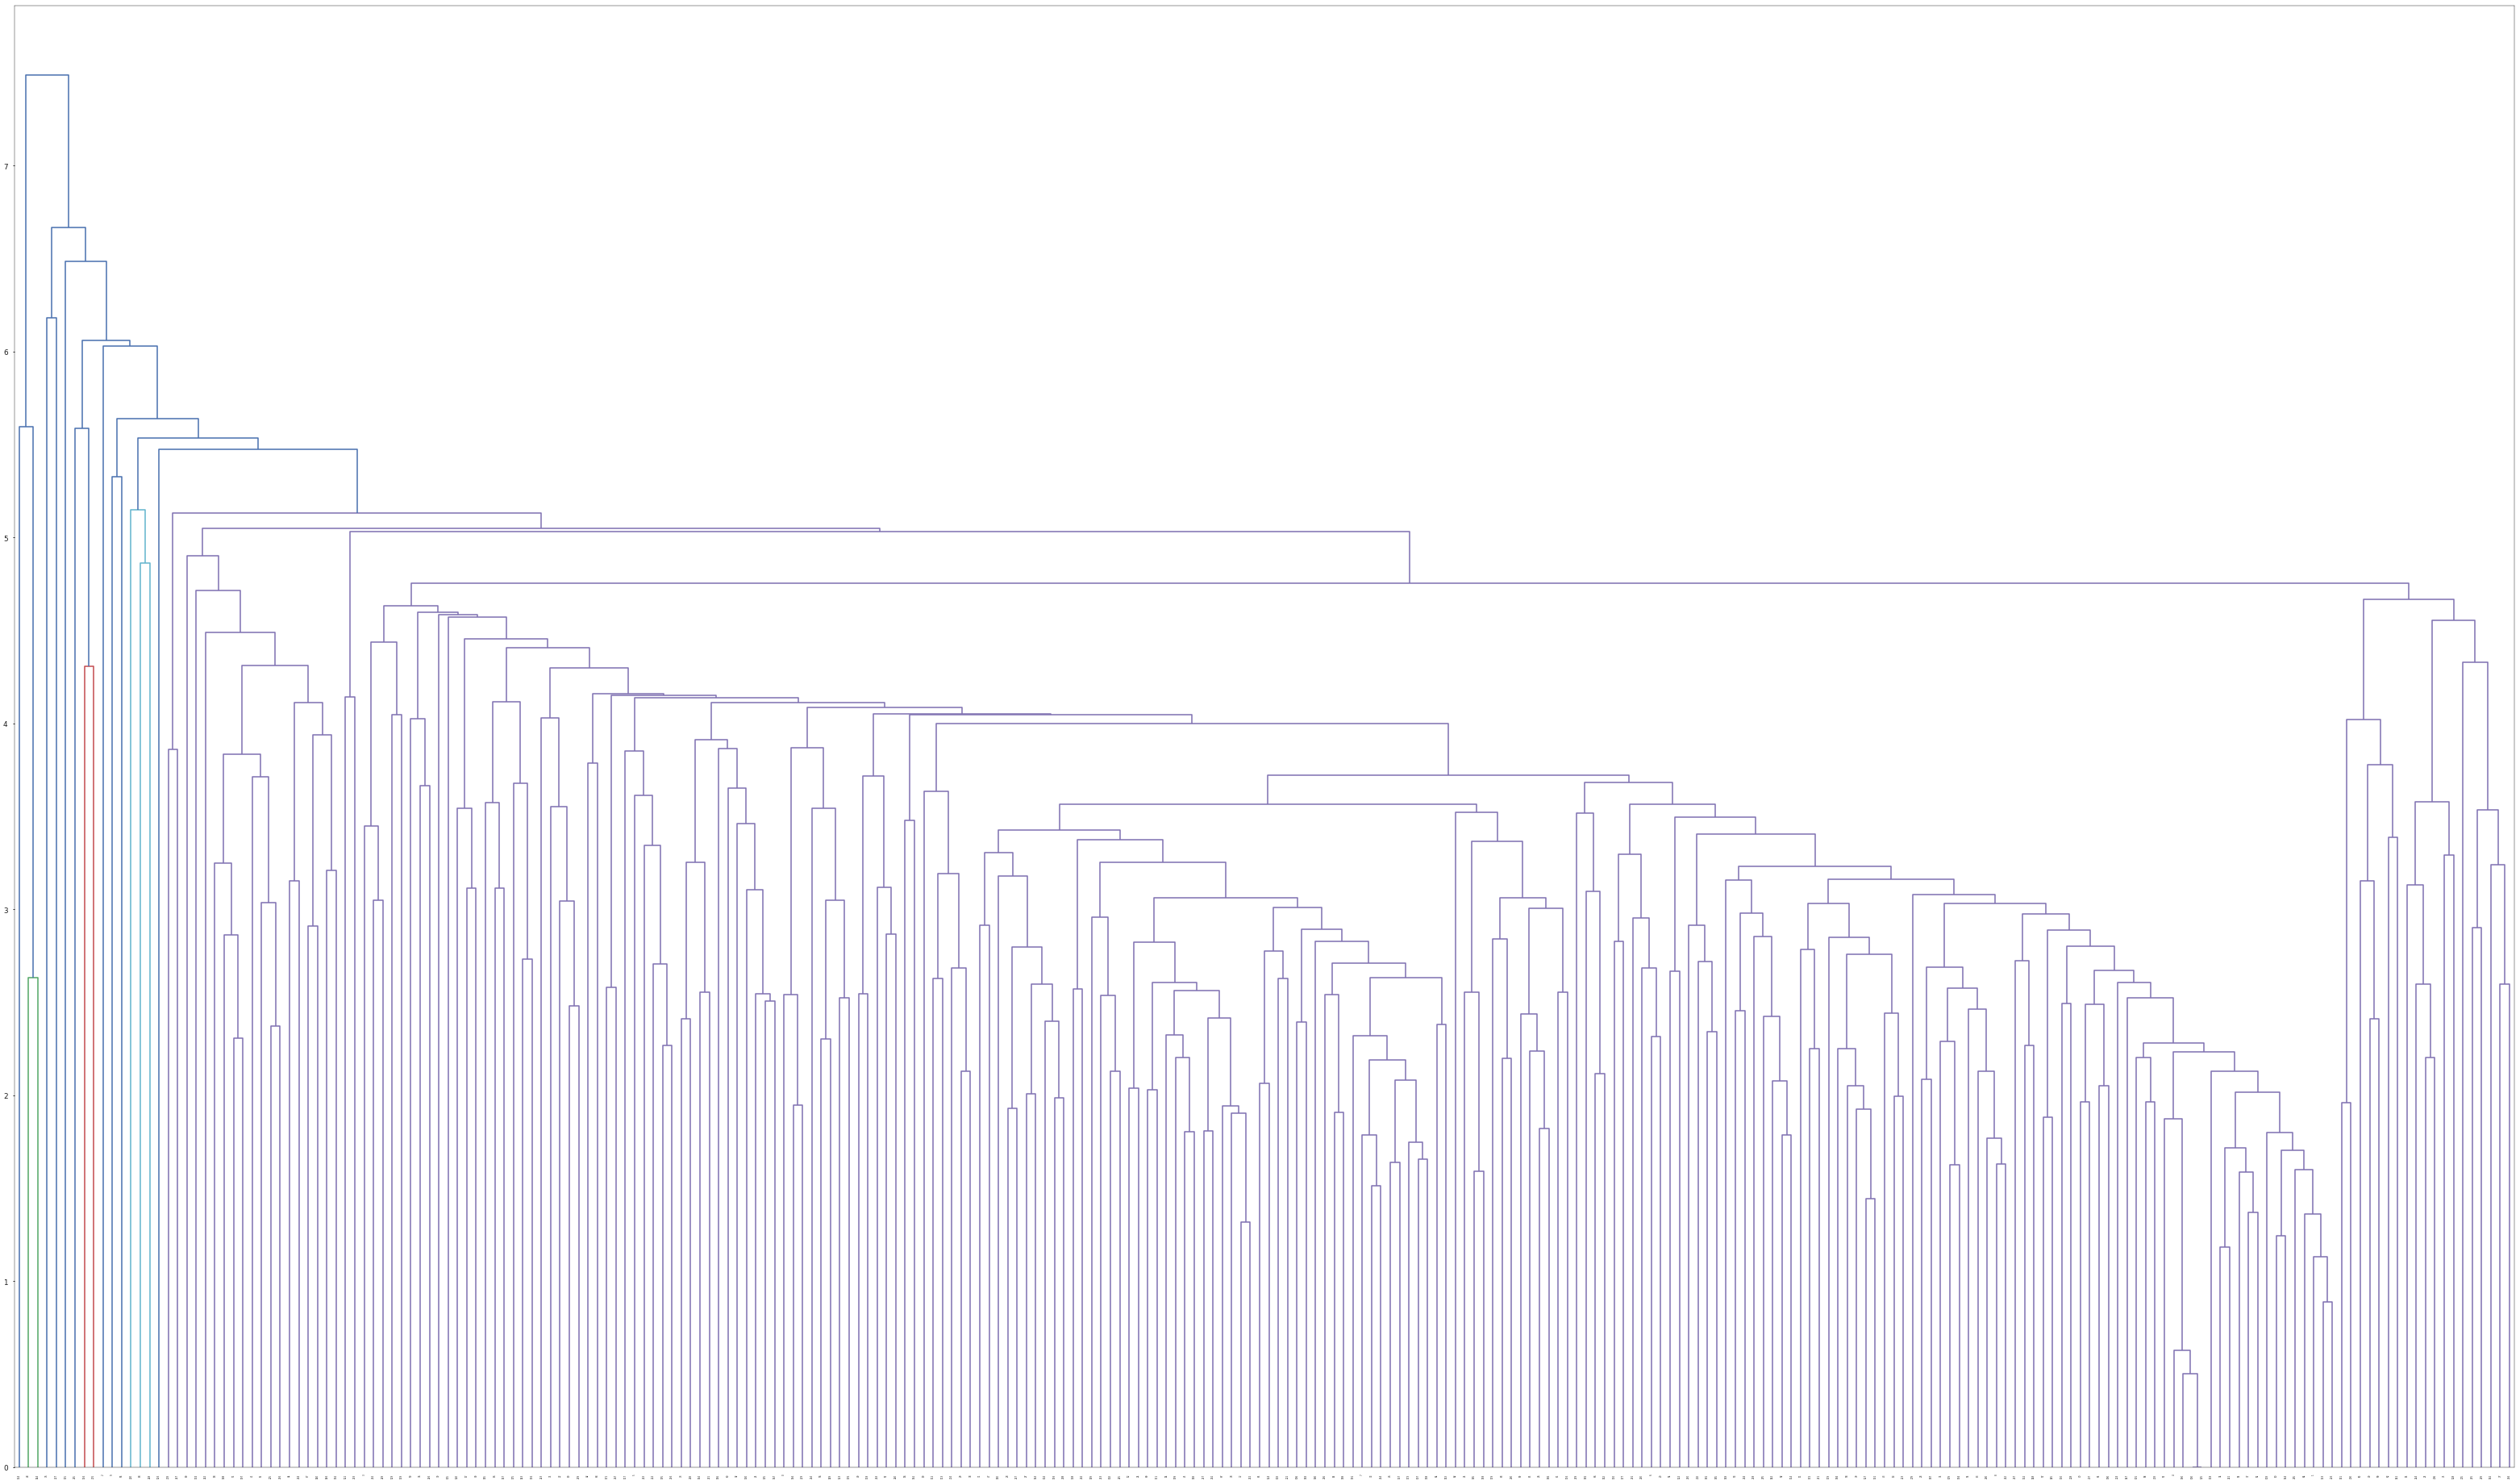

Rowley Inn,1104 Rowley Ave,Cleveland,OH
Speedys Grub Shack,14001 Lakewood Heights Blvd,Cleveland,OH
Marjees Bar & Grill,3604 Superior Ave,Cleveland,OH
Ontario Street Cafe,2053 Ontario St,Cleveland,OH
Distefano's Authentic Italian Foods,5600 Highland Rd,Cleveland,OH
Barristers Deli,1424 Hamilton Ave,Cleveland,OH
Tabletop Board Game Cafe,1810 W 25th St,Cleveland,OH
Applebee's,20705 Center Ridge Rd,Cleveland,OH
Knuckleheads,2115 Brookpark Rd,Cleveland,OH
Coffee Bean Cafe & Bakery,2901 Euclid Ave,Cleveland,OH
Murray Hill Market,2072 Murray Hill Rd,Cleveland,OH
The Plum Cafe & Kitchen,4133 Lorain Ave,Cleveland,OH
Good To Go,1360 E 9th St,Cleveland,OH
Leader Bar And Grill,526 Superior Ave,Cleveland,OH
Iron City Cafe,4002 Jennings Rd,Cleveland,OH
Thirst & Ten,15299 Sheldon Rd,Cleveland,OH
Cleveland Beer Cellars,11500 Euclid Ave,Cleveland,OH
Crop Bistro,2537 Lorain Ave,Cleveland,OH
Potbelly Sandwich Shop,5300 Riverside Dr,Cleveland,OH
Hit Ratio:  0.80487804878
NDCG:  0.878474686068





Recomm

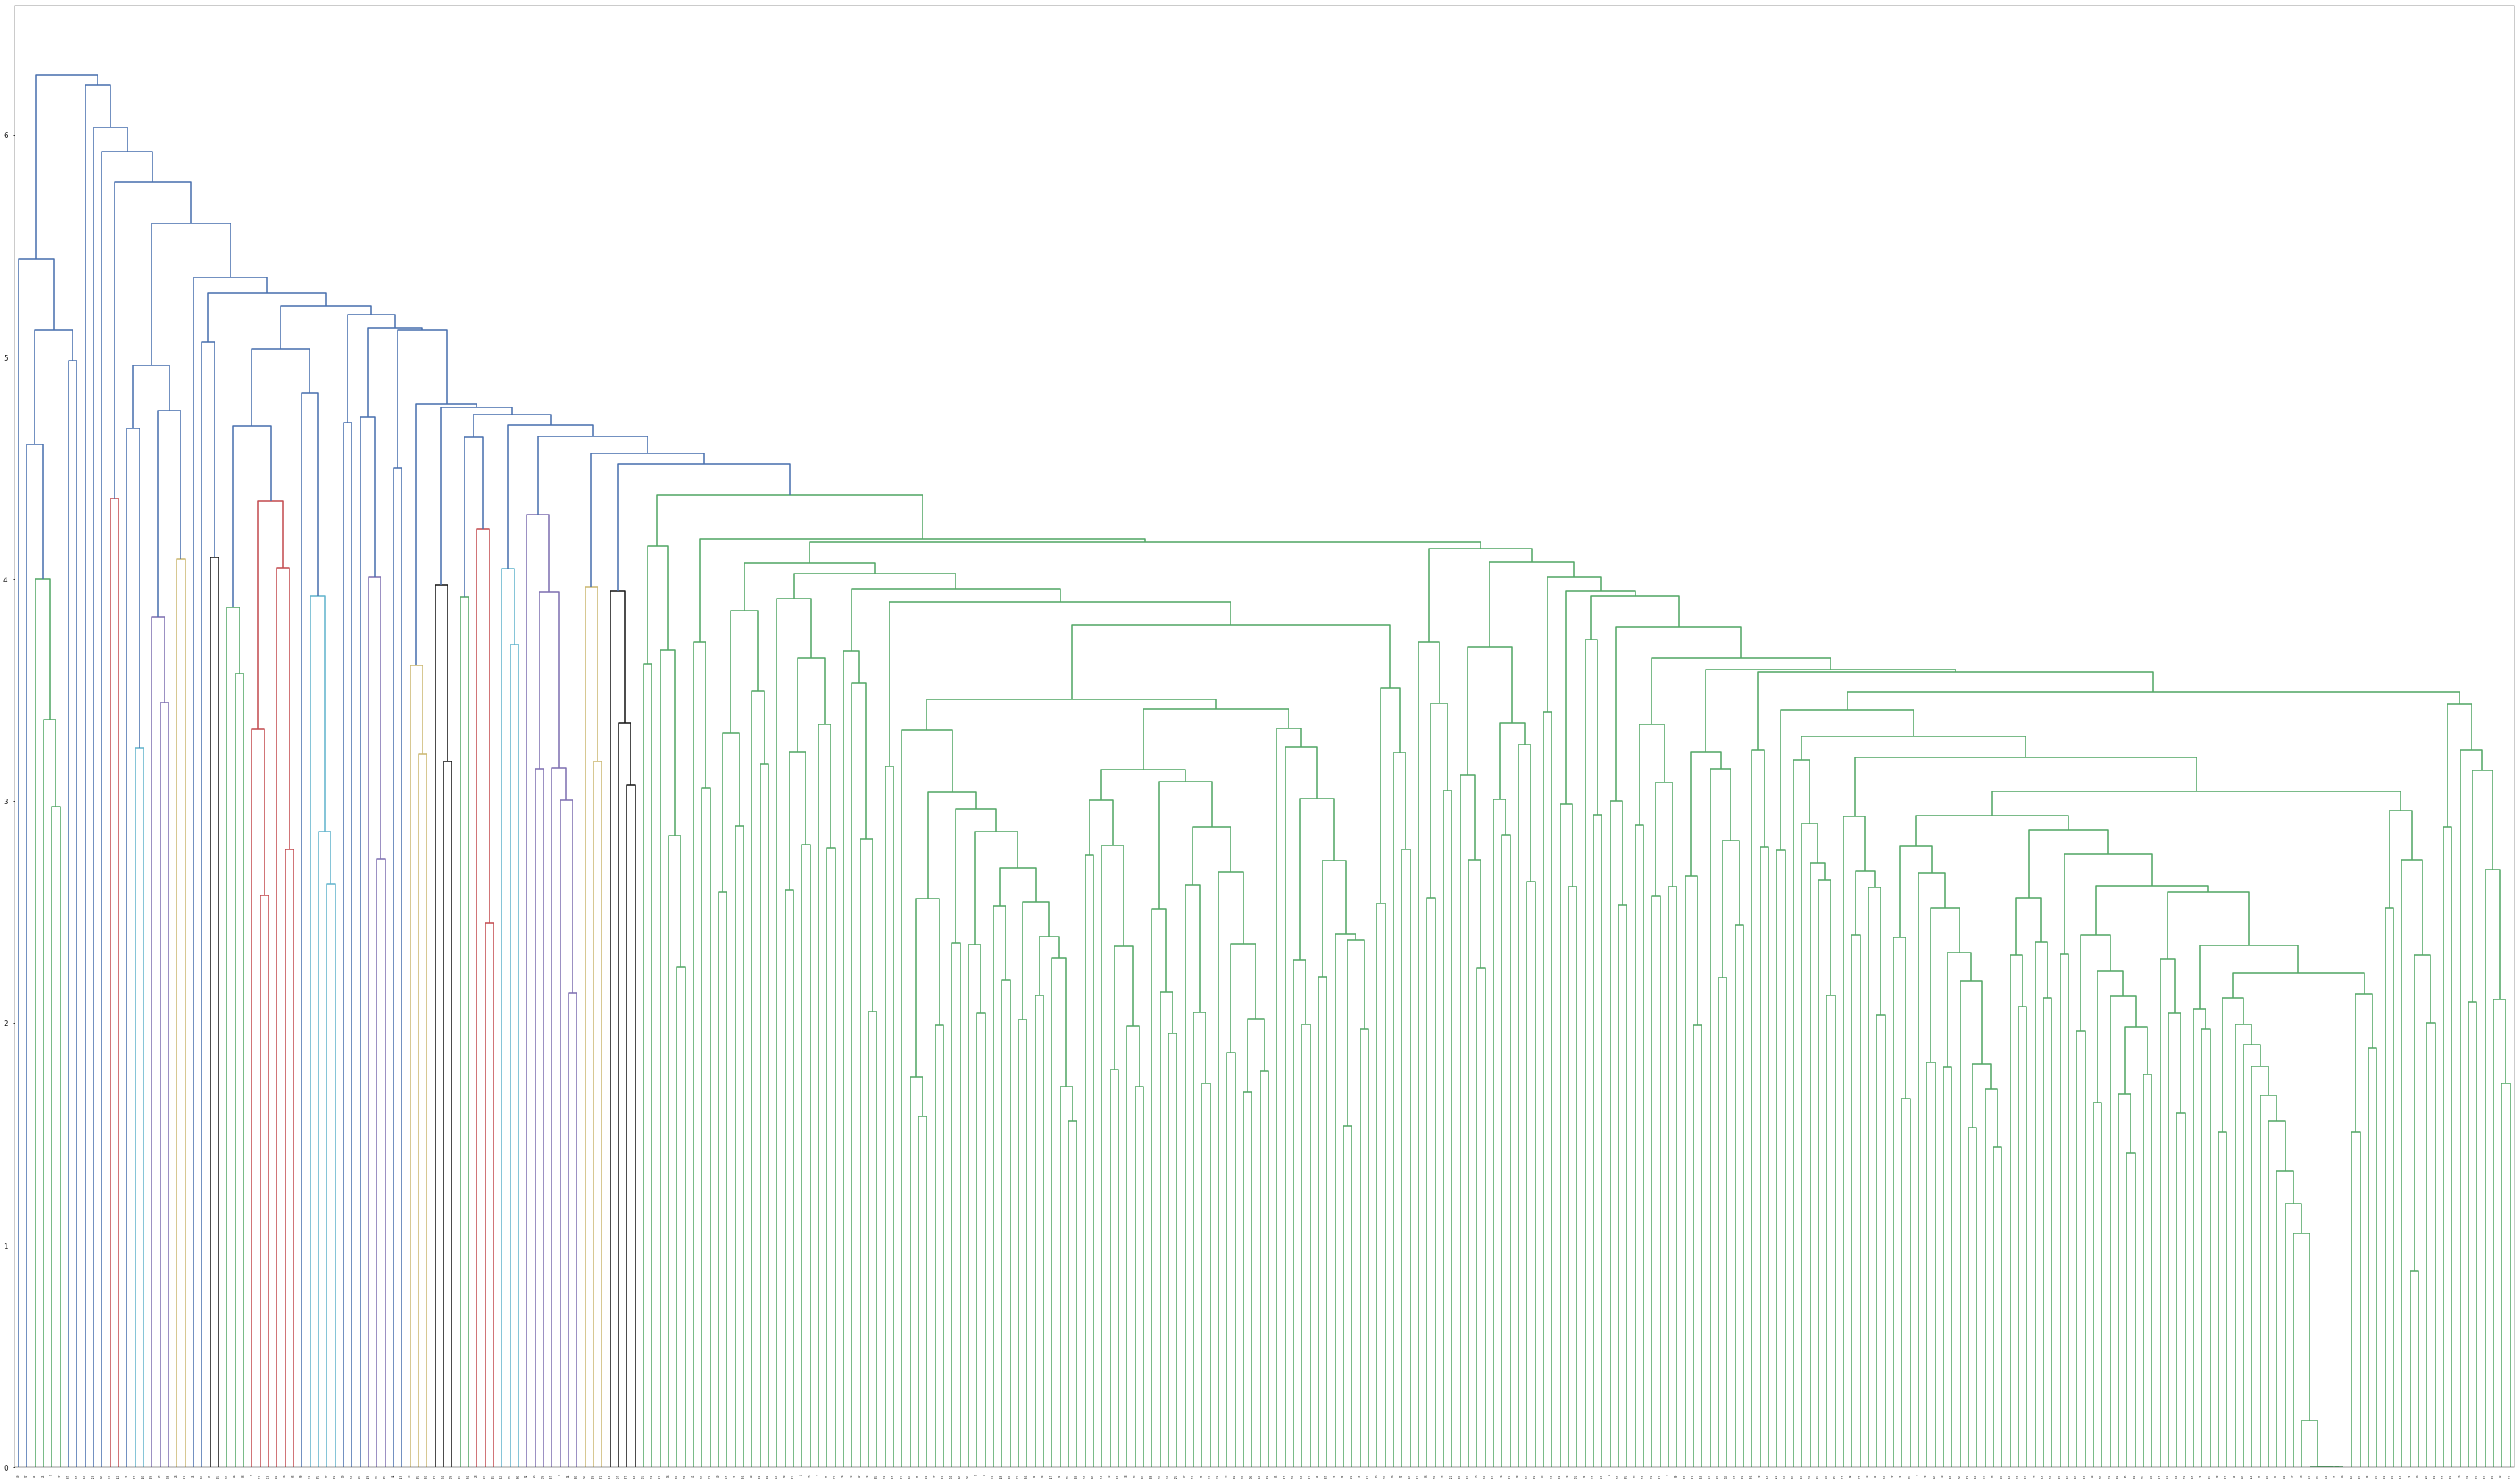

Players Sports Bar,2013 Winnebago St,Madison,WI
Manna Cafe & Bakery,611 N Sherman Ave,Madison,WI
Madison Food Explorers,2406 Upham St,Madison,WI
Sí Café,117 S Pinckney St,Madison,WI
Highland Espresso Bar,45 S Bassett St,Madison,WI
Great Harvest Bread,3258 University Ave,Madison,WI
Village Bar,3801 Mineral Point Rd,Madison,WI
Hail Mary Sports Grill,401 E Washington Ave,Madison,WI
Jordan's Big Ten Pub,1330 Regent St,Madison,WI
Growlers To Go-Go,2927 E Washington Ave,Madison,WI
Cambridge Winery - Madison Tasting Room,1001 S Whitney Way,Madison,WI
Salted Root Coffee House,11 N Allen St,Madison,WI
Leia's Lunchbox,44 E Mifflin St,Madison,WI
4&20 Bakery & Cafe,305 N 4th St,Madison,WI
Pan y Pan,3737 Milwaukee St,Madison,WI
Mermaid Cafe,1929 Winnebago St,Madison,WI
PaintBar Madison,1224 Williamson St,Madison,WI
Indie Coffee,1225 Regent St,Madison,WI
Black Locust Cafe,829 E Washington Ave,Madison,WI
Hit Ratio:  0.74358974359
NDCG:  0.83869340848





Recommendation info summary for :  Stuttgart


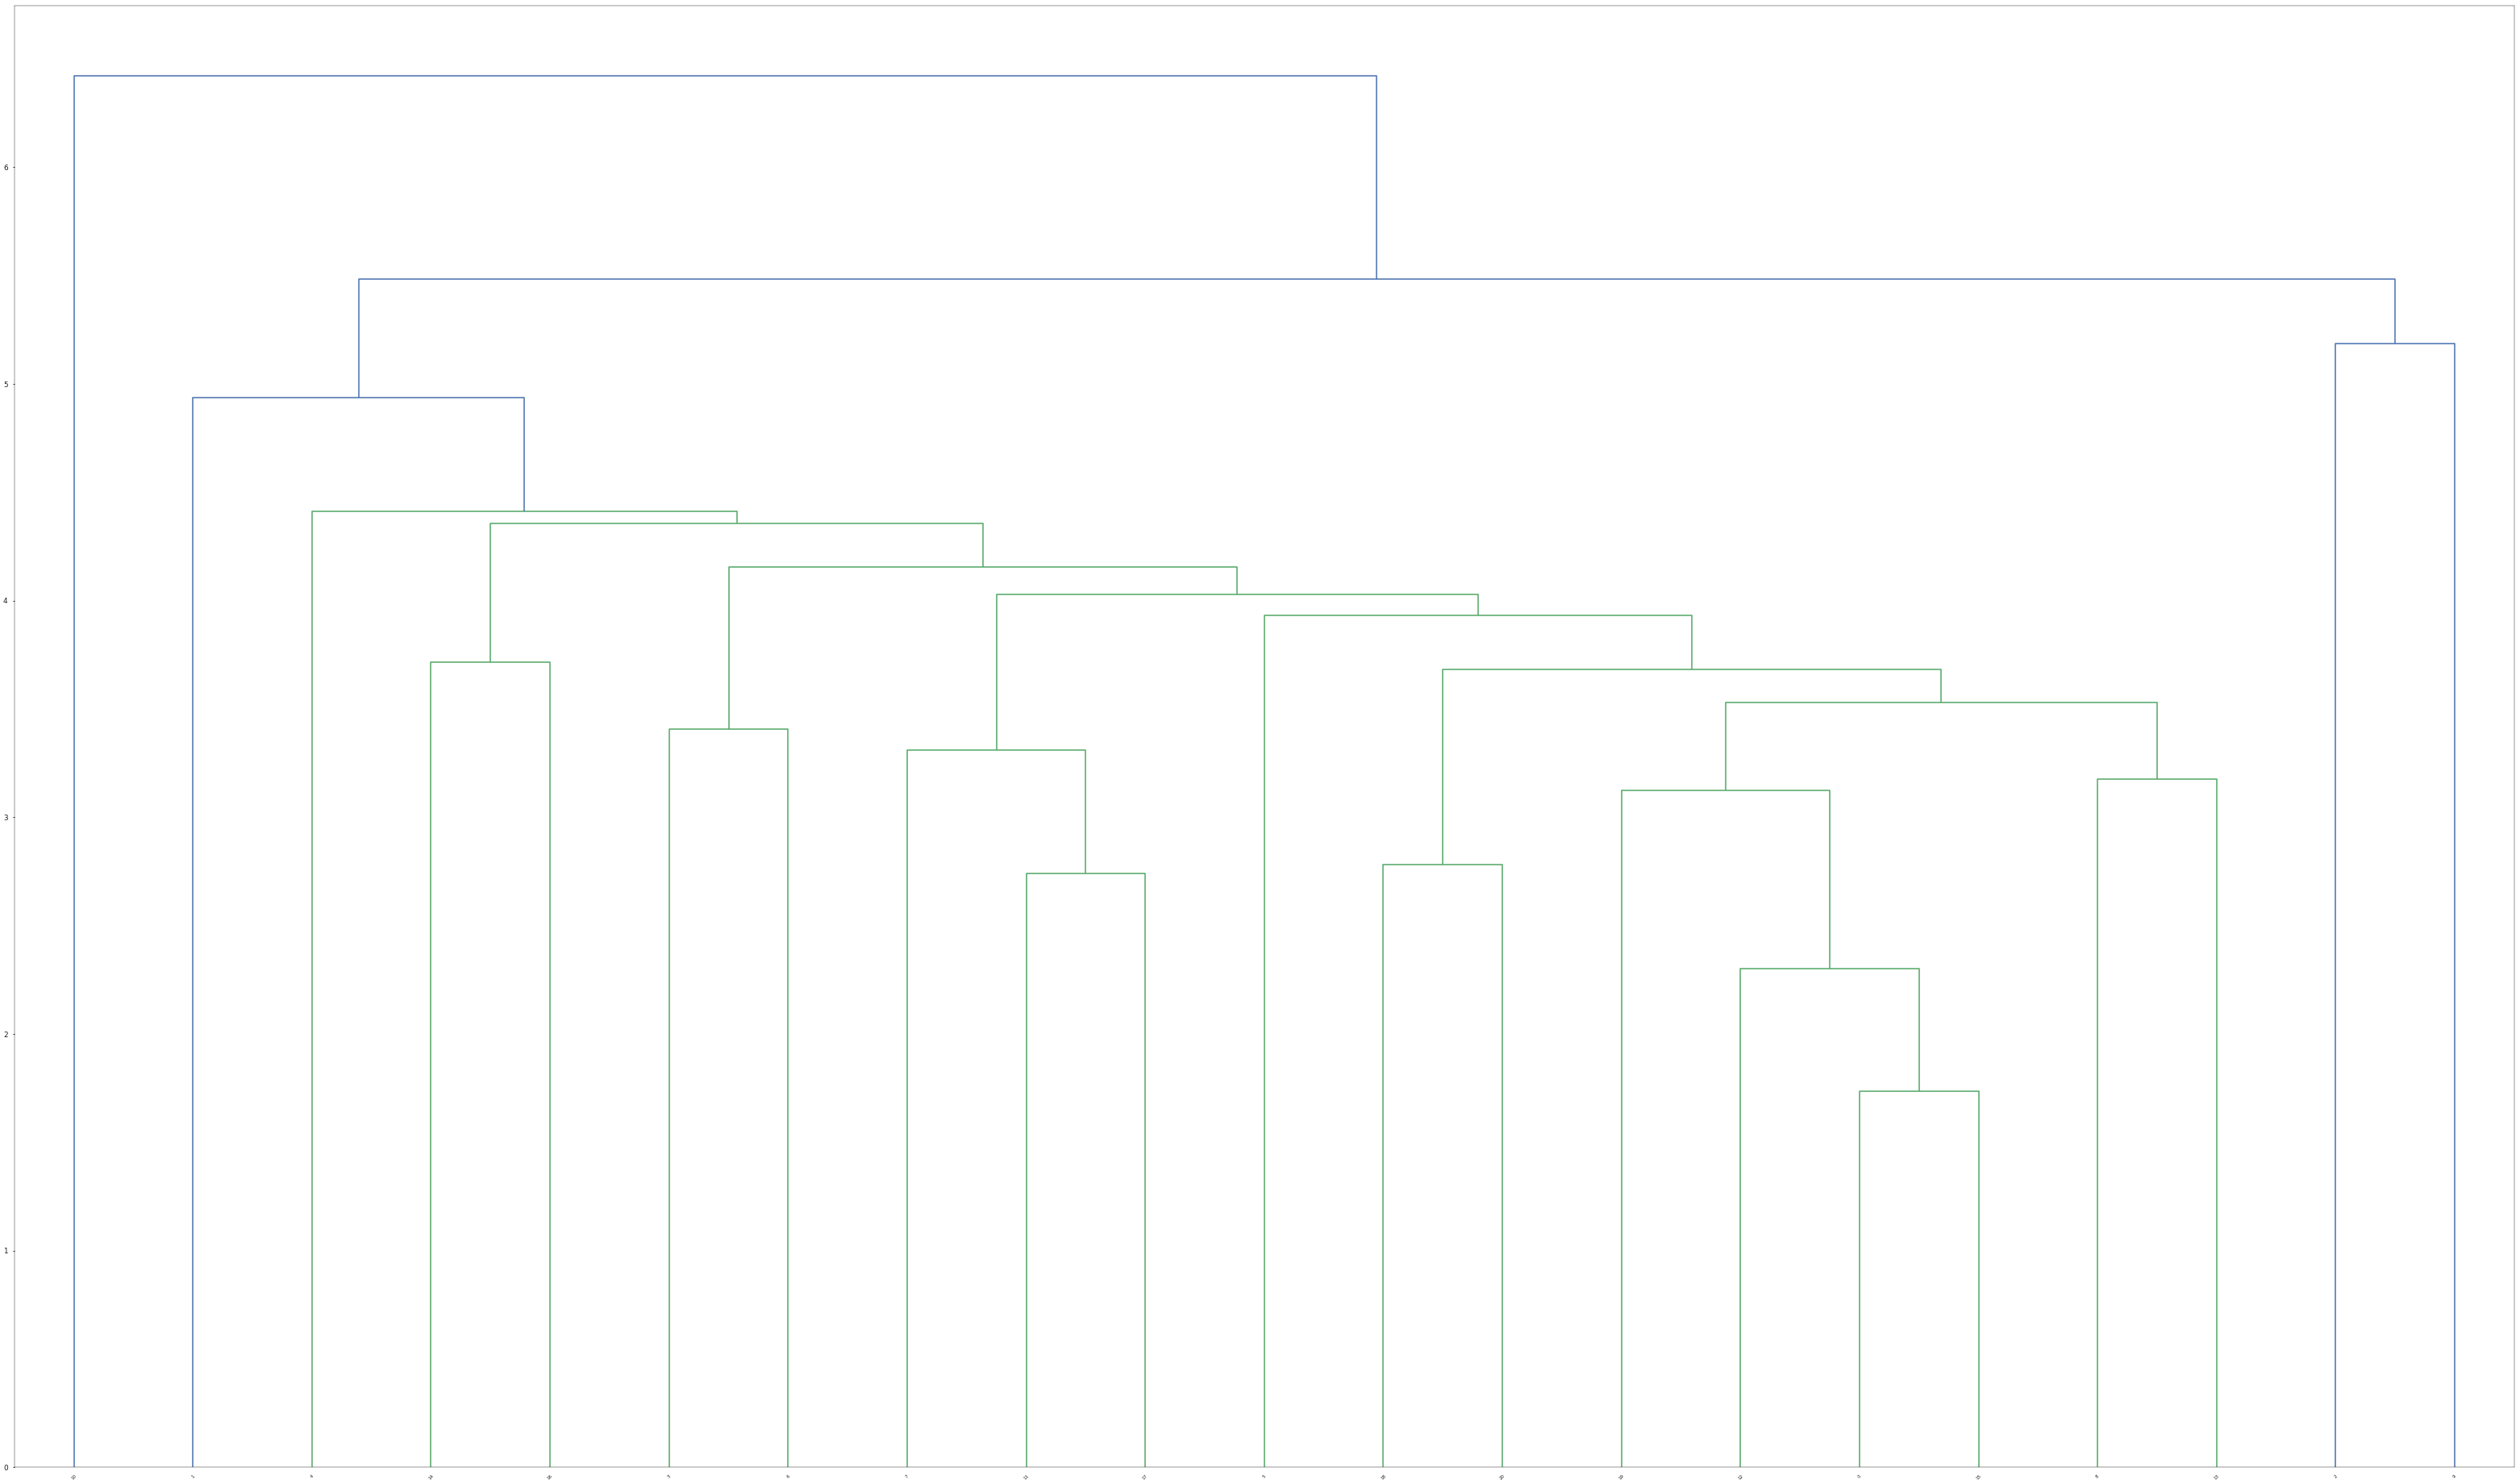

Weinstube Lamm,Mühlstr. 24,Stuttgart,BW
Mögle,Dieterlestr. 32,Stuttgart,BW
El Camino,Marbacher Str. 18,Stuttgart,BW
Reiterstüble Gasthaus,Furtwänglerstr. 190,Stuttgart,BW
Bar Vicino,Traubenstr. 45,Stuttgart,BW
Weinstube Am Stadtgraben,Am Stadtgraben 6,Stuttgart,BW
Nouvel,Köstlinstr. 2,Stuttgart,BW
Weinstube Vetter,Bopserstr. 18,Stuttgart,BW
Ulmers Besenwirtschaft,Langobardenstr. 30,Stuttgart,BW
Weinstube zum Tröpfle,Zabergäustr. 73,Stuttgart,BW
BO'TECA di vino,Beethovenstr. 30,Stuttgart,BW
Buschpilot,Karl-Schurz-Str. 28 C,Stuttgart,BW
Délice,Hauptstätter Str. 61,Stuttgart,BW
Heslacher Weinstube,Böcklerstr.18,Stuttgart,BW
Knausbira Stüble,Heumadener Str. 15,Stuttgart,BW
Weinstube Viertelesschlotzer,Forststr. 57,Stuttgart,BW
Running Mhhh,Kronprinzstr. 24,Stuttgart,BW
Weinstube Cafe Löwen,Trollingerstr. 4,Stuttgart,BW
Teehaus im Weißenburgpark,Hohenheimer Str. 119,Stuttgart,BW
Hit Ratio:  0.5
NDCG:  0.665306122449





Recommendation info summary for :  Mesa
number of valid user:  264
num

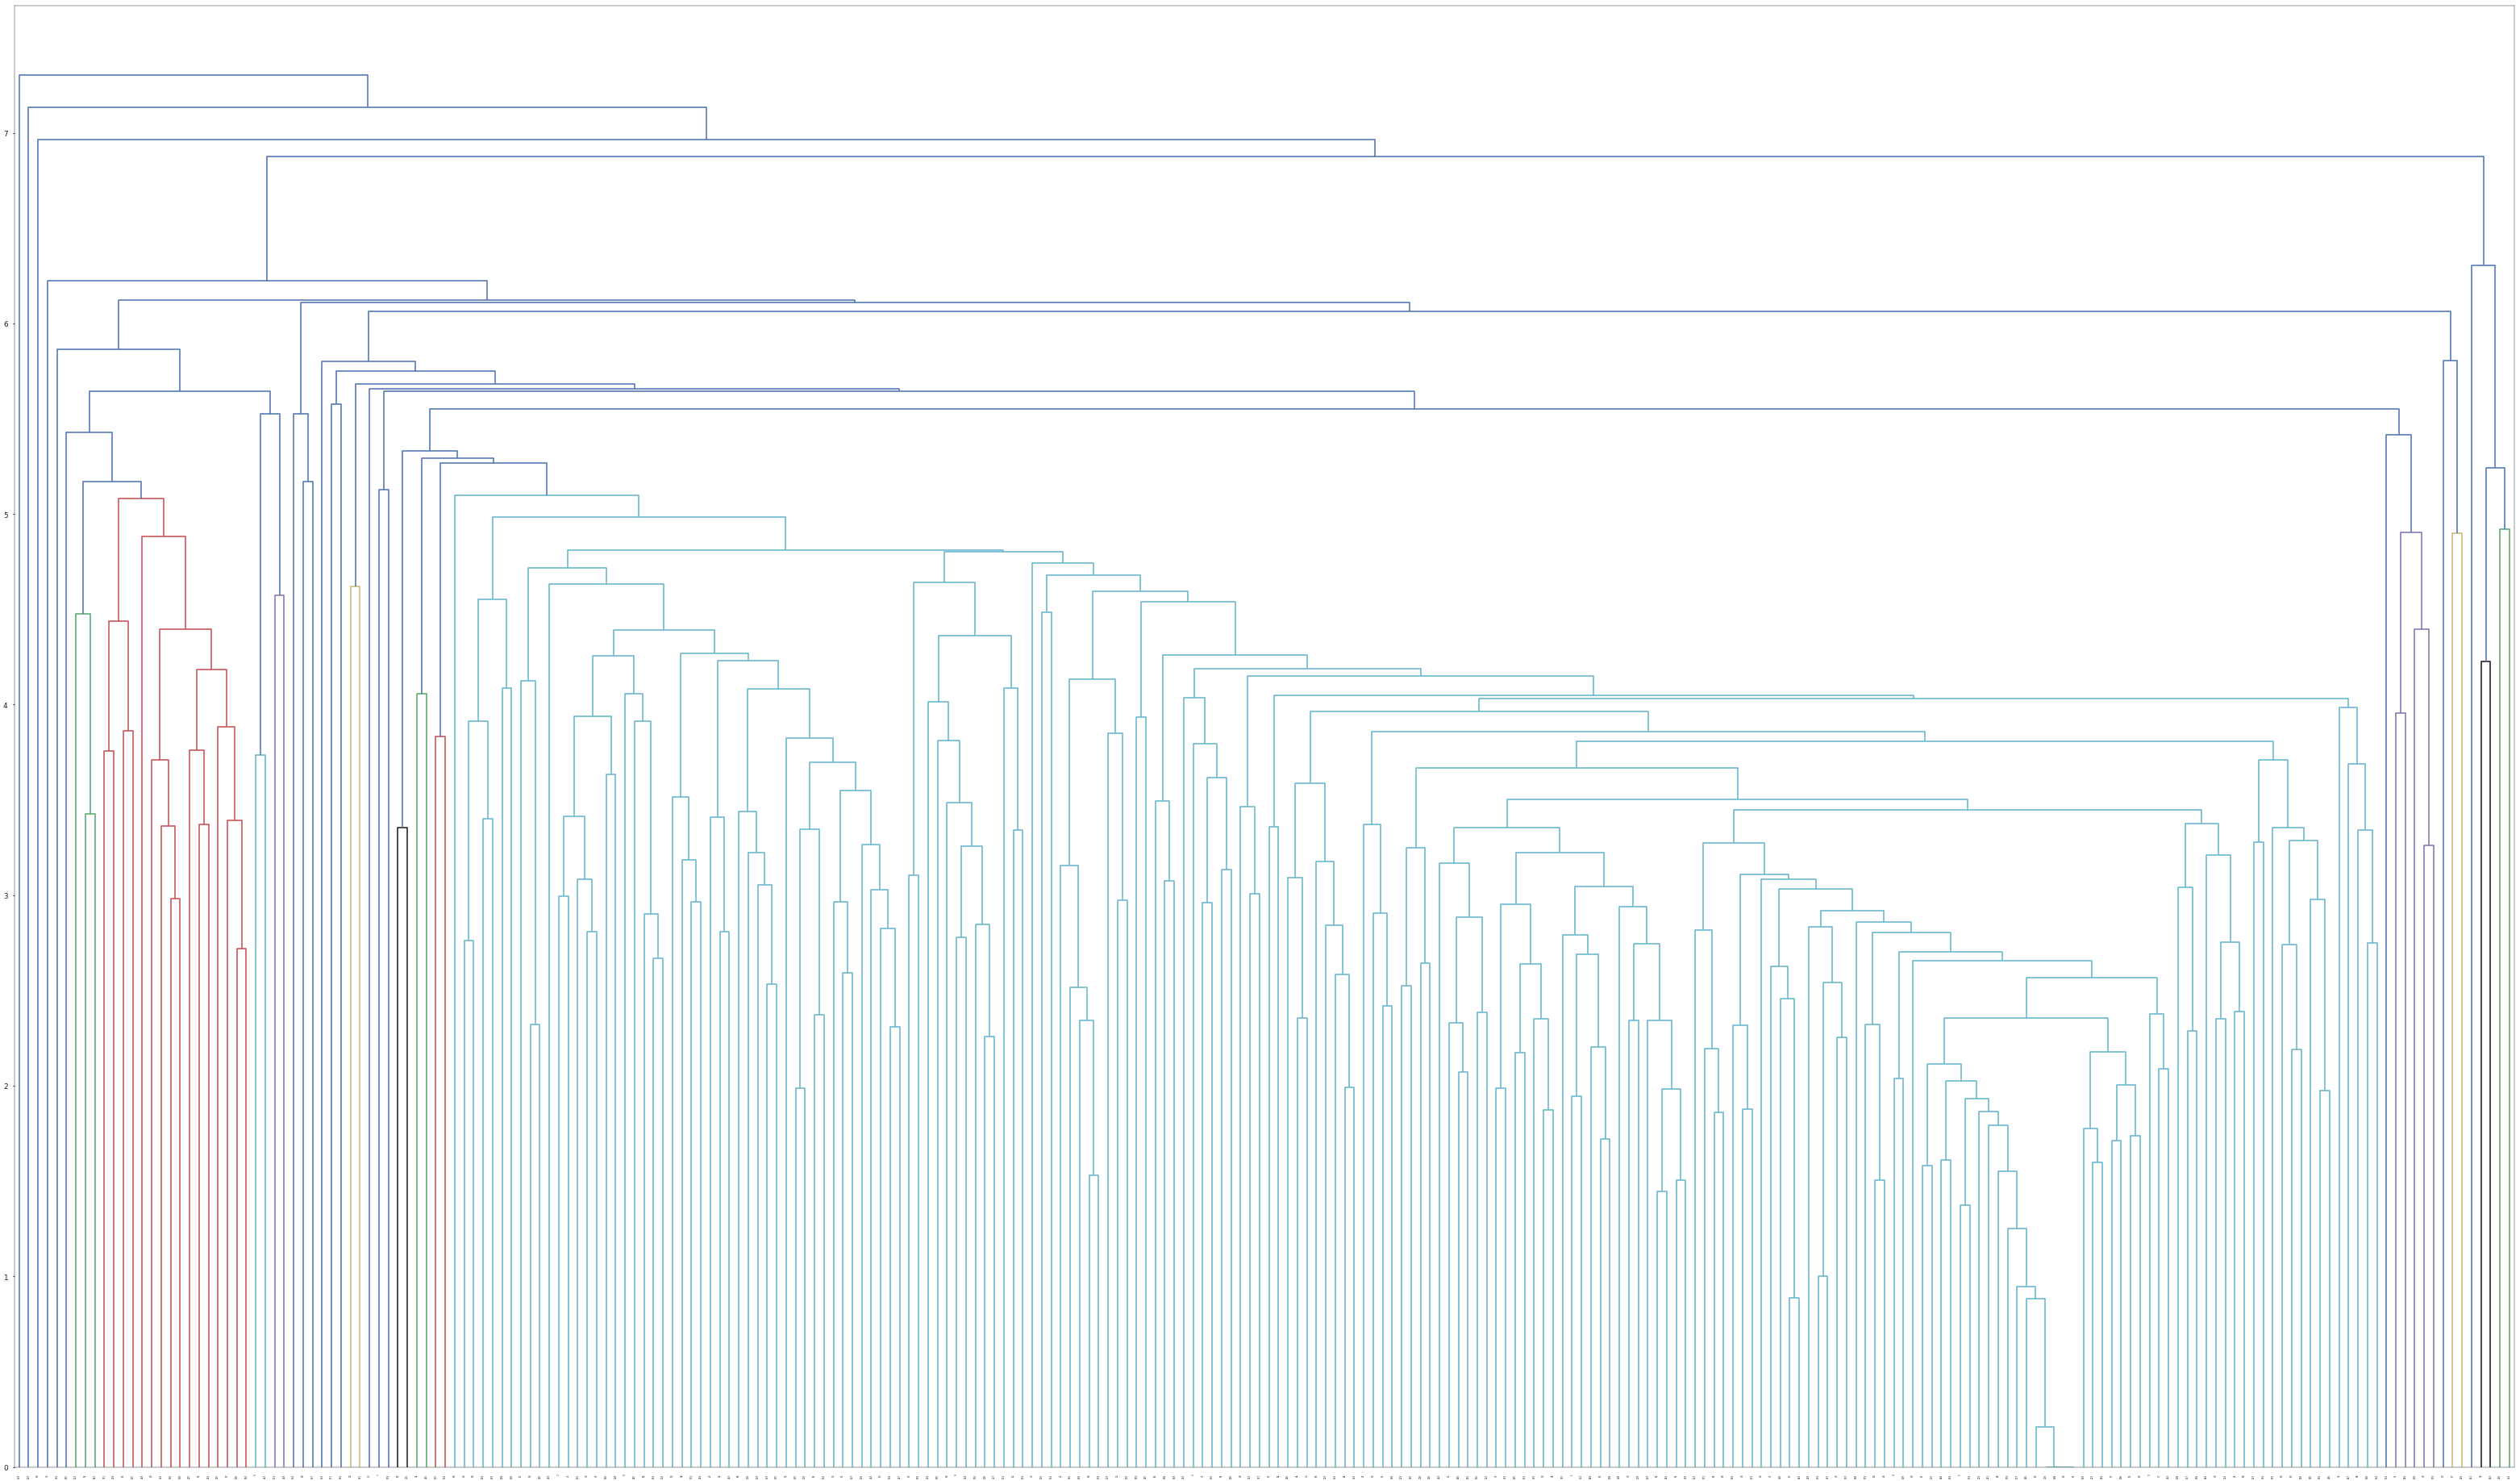

Donut Worry Coffee & Smoothies,9115 E Baseline Rd,Mesa,AZ
Lava Cafe Hookah Lounge,1038 W Southern Ave, Ste 2,Mesa,AZ
Big Daddy Vape Mesa,4446 E University Dr, Ste 112,Mesa,AZ
Salad and Go,5259 E Brown Rd,Mesa,AZ
Pineapple Grill,4545 E McKellips Rd, Ste C108,Mesa,AZ
Planet Sub Mesa-Grand,1641 S Stapley Dr, Ste 101,Mesa,AZ
Double Overtime Sports Grille,2235 S Power Rd,Mesa,AZ
Miele's Italian and Banquet Hall,2050 W Guadalupe Rd, Ste 9,Mesa,AZ
Eklectic Pie - Mesa,1859 S Stapley Dr, Ste 105-3,Mesa,AZ
Bricks Family Sports Grill,2235 S Power Rd, Ste 127,Mesa,AZ
Urban Heat,1749 W Main St,Mesa,AZ
Boca Taqueria,1249 N Greenfield Rd, Ste 104,Mesa,AZ
Mother's Authentic Mexican Tamales,1940 E Broadway Rd,Mesa,AZ
Mesa Drummer,1211 N Country Club, Ste 9,Mesa,AZ
Old Glory Cafe,American Discount Foods, 1360 W Southern Ave,Mesa,AZ
The Hub Grill and Bar,1925 S Sossaman Rd,Mesa,AZ
Fat Willy's,2250 S Buttercup Rd,Mesa,AZ
Downtown Rendezvous,20 E Main St,Mesa,AZ
Worth Takeaway,218 W Main St,Mesa,AZ
Hit Rat

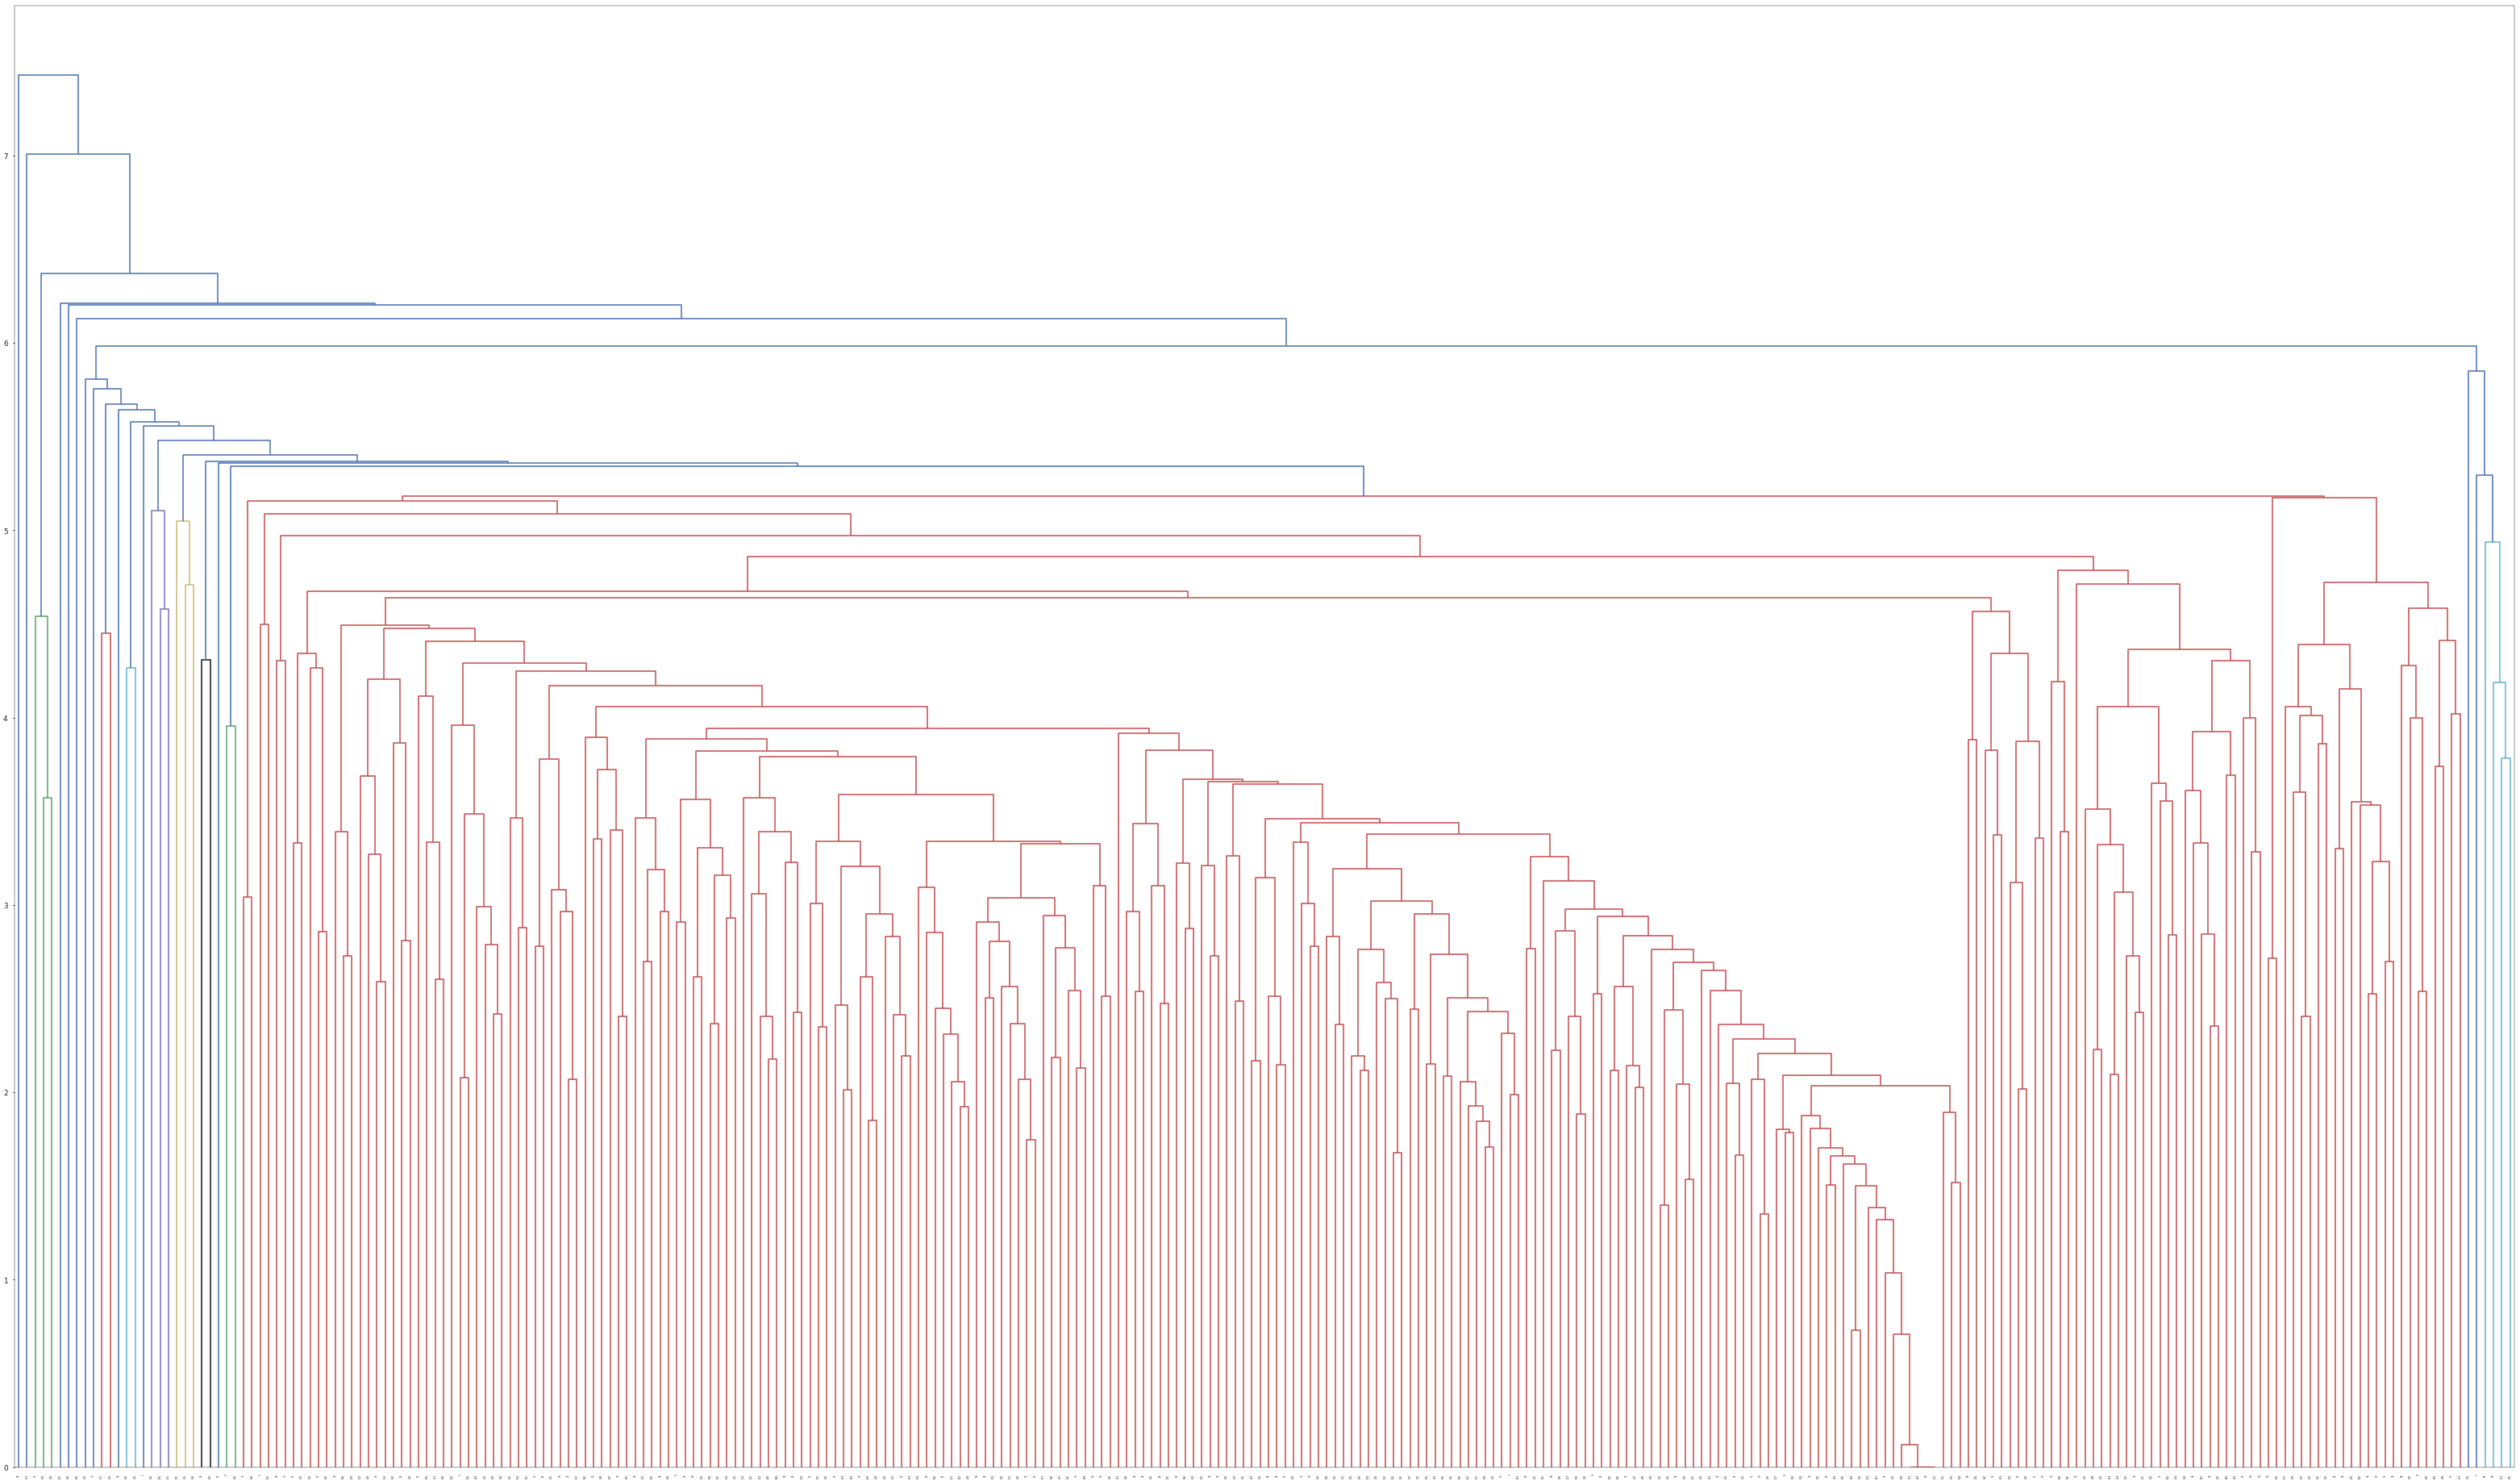

1865 Coffee,40 E University Dr,Tempe,AZ
LaGattara Cat Cafe,1301 E University Dr, Ste 136,Tempe,AZ
Sweet Dessert Café,715 W Baseline Rd, Ste 2,Tempe,AZ
Perfect Pear Bistro,9845 S Priest Dr,Tempe,AZ
Salut Kitchen Bar,1435 E University Dr, Ste 12,Tempe,AZ
Metro Espresso & Sandwiches,2070 E Apache Blvd, Ste 103,Tempe,AZ
Around the Board A Board Game Cafe,5004 S. Price Rd,Tempe,AZ
Lucy's Fountainhead Cafe,1501 W Fountainhead Pkwy, Ste 140,Tempe,AZ
Snooze An AM Eatery,615 S College Ave, Ste 103,Tempe,AZ
Panera Bread,1707 W Warner Rd,Tempe,AZ
Vertigo Hookah Lounge & Cafe,1320 E Broadway Rd, Ste 102,Tempe,AZ
Postino Annex,615 S College Ave,Tempe,AZ
Infusion Coffee & Tea,1300 E 8th St, Ste 100,Tempe,AZ
Crêpe Bar,7520 S Rural Rd, Ste A12,Tempe,AZ
Subway,1849 E Guadalupe Rd,Tempe,AZ
Detroit Coney Grill,930 W Broadway Rd,Tempe,AZ
Steve's Espresso,1801 E Baseline Rd, Ste 102,Tempe,AZ
Moroccan Paradise,1212 E Apache Blvd,Tempe,AZ
Pitchforks & Corks,660 S College Ave, Fl 2,Tempe,AZ
Hit Ratio:  0.4848

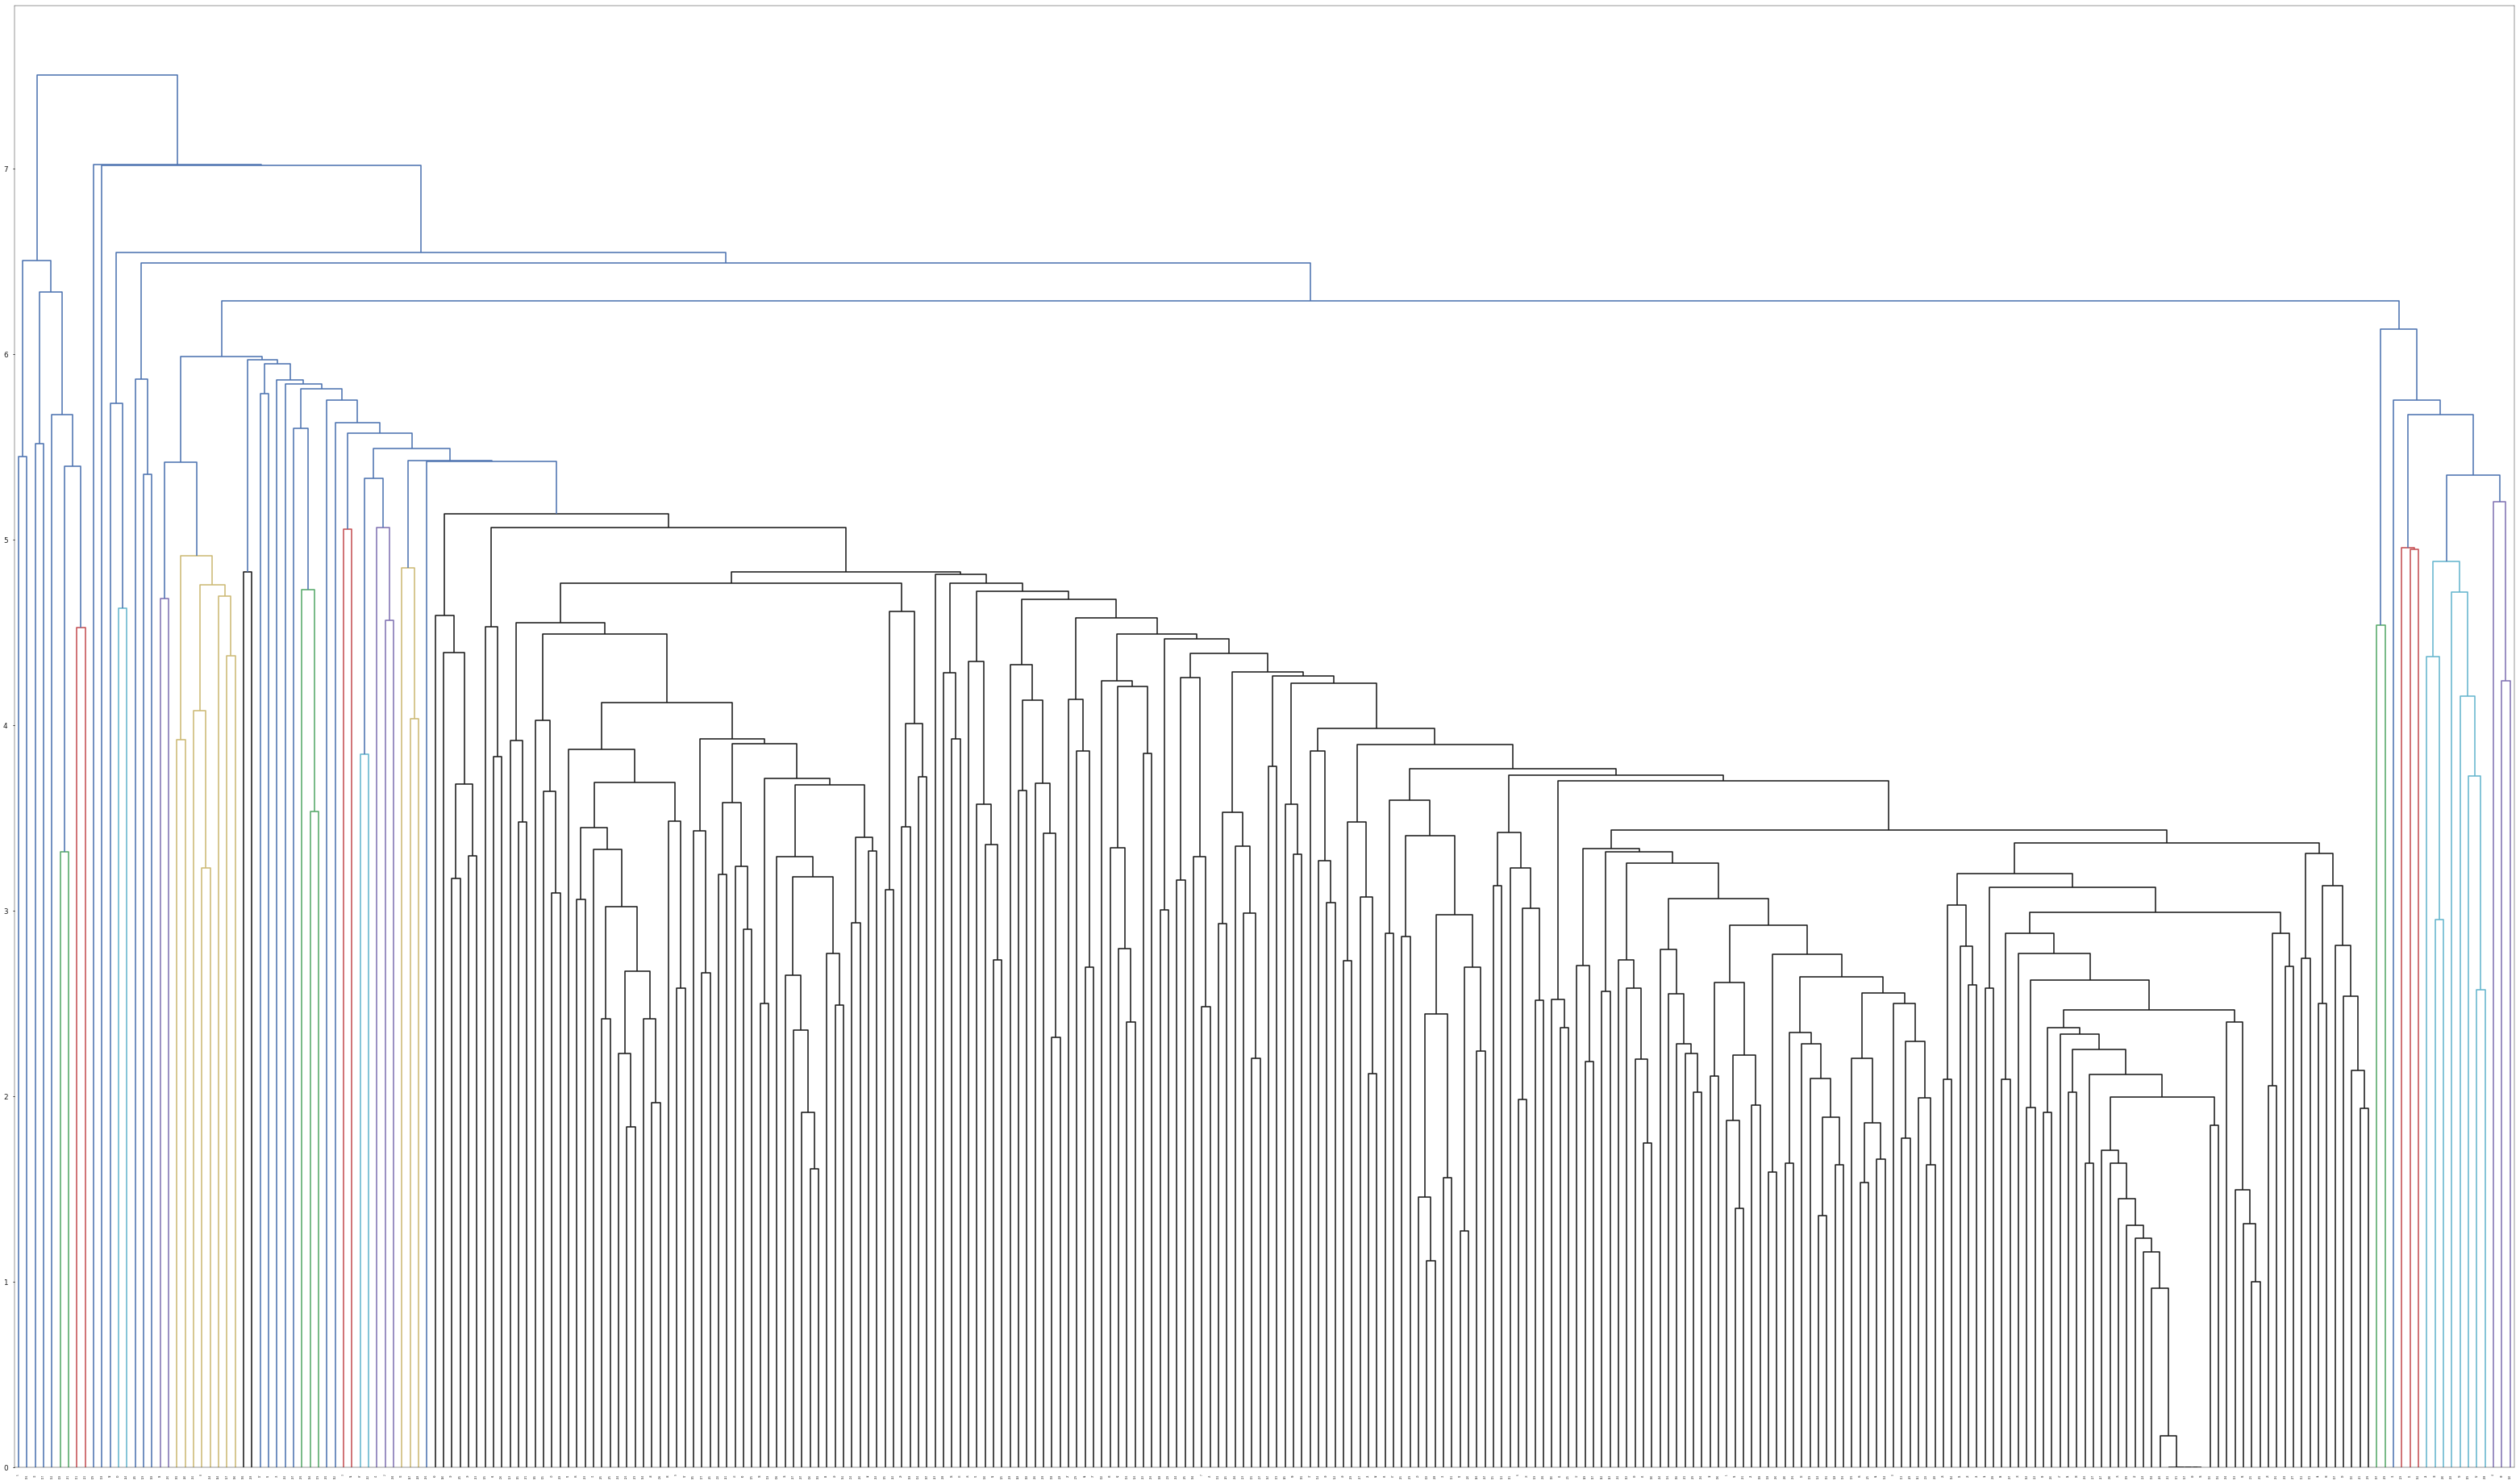

Costa Del Sol At Sunset Station,1301 W Sunset Road,Henderson,NV
Served,1770 W Horizon Ridge, Ste 100,Henderson,NV
Woods Family Sandwiches,931 American Pacific Dr, Ste 106,Henderson,NV
HoneyBaked Ham,1533 W Sunset Rd,Henderson,NV
Egg Works,10839 S Eastern Ave,Henderson,NV
Dylans Grill and Pub,4401 E Sunset Rd,Henderson,NV
KIT's Kitchen,2021 W Sunset Rd,Henderson,NV
Chefery,,Henderson,NV
Sin City Brew Tours,,Henderson,NV
Akropolis Gyro & Pizza,1690 W Sunset Rd, Ste 104,Henderson,NV
The Coffee Press,280 S Green Valley Pkwy,Henderson,NV
Buddha Belly Deli,50 N Valle Verde Dr, Ste 110,Henderson,NV
Purple Potato by Yonaka,10090 S Eastern Ave, Ste 110,Henderson,NV
The Players Club LV,75 S, Ste phanie,Henderson,NV
Straight From Philly Steakout,1659 W Warm Springs Rd, Ste 100,Henderson,NV
Straight From Philly,65 W Lake Mead Pkwy,Henderson,NV
Burger Joint,10890 S Eastern Ave, Ste 108,Henderson,NV
Me Gusta Tacos,2235 Village Walk Dr, Ste 153,Henderson,NV
Fix8 Fitness Cafe,72 W Horizon Ridge Pkwy, 

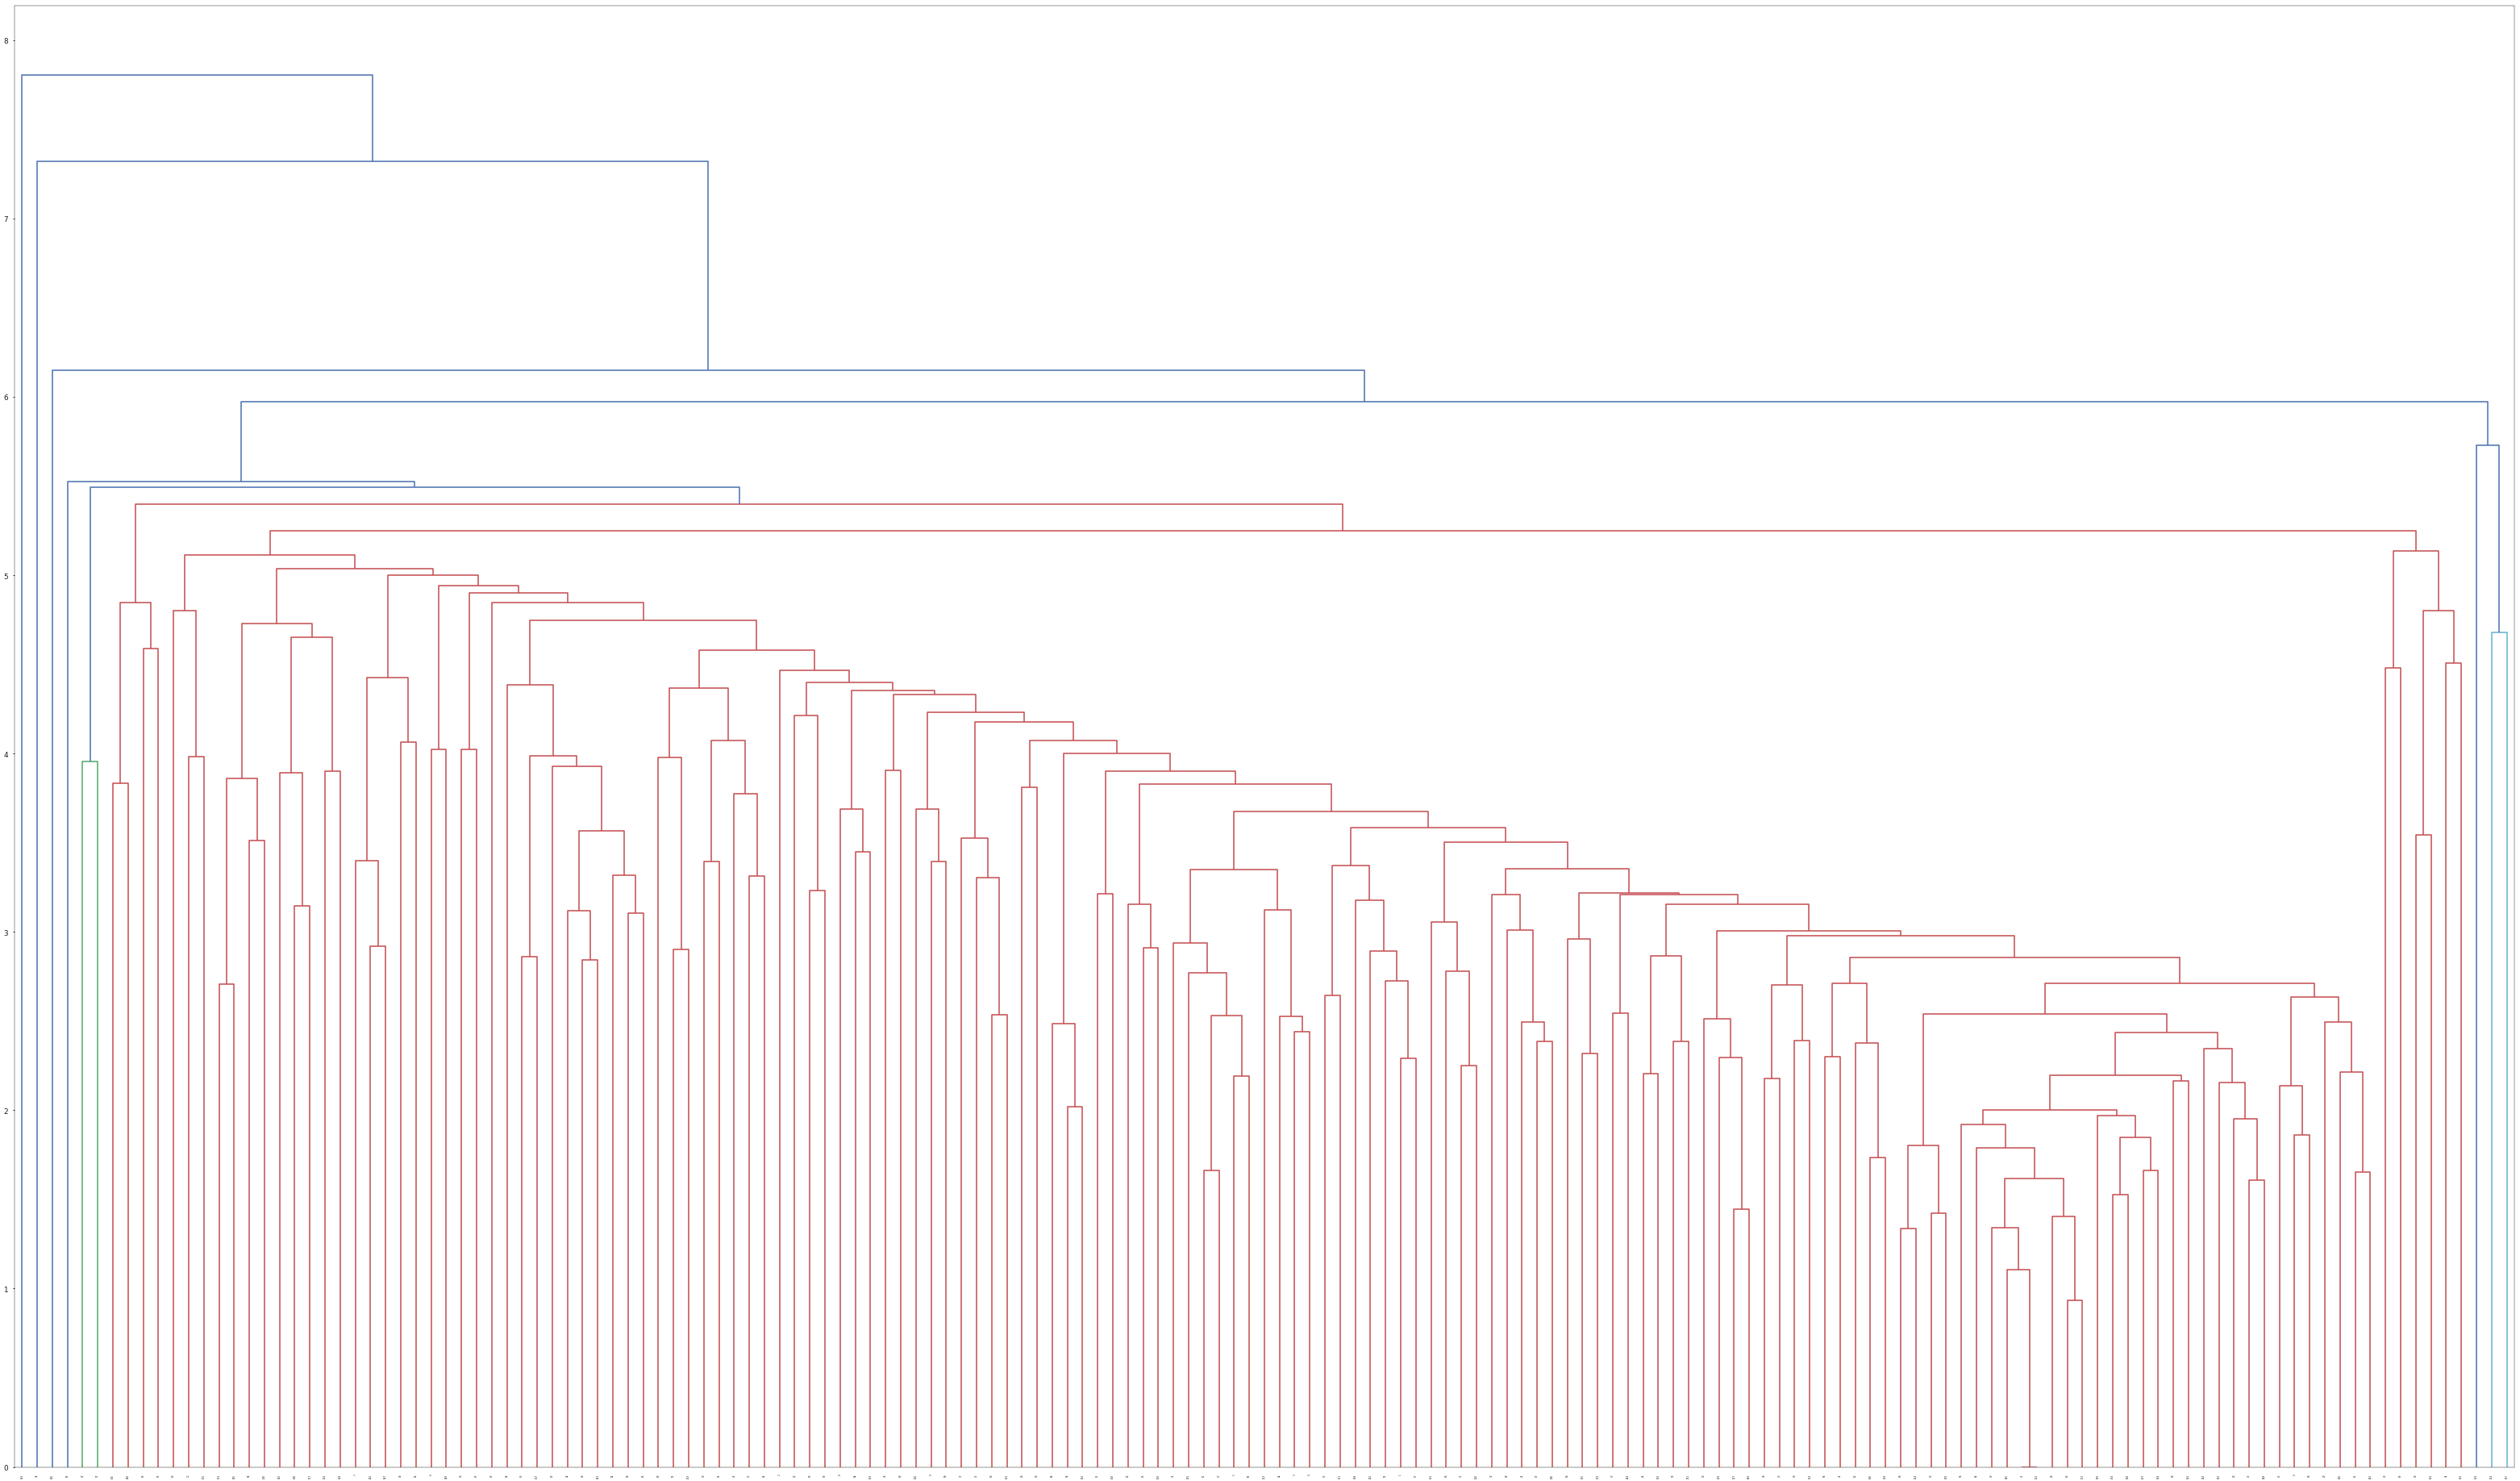

The Maharaja,4646 Heritage Hills Boulevard, Unit 3,Mississauga,ON
Roosters Edge,812 Britannia Road W, Unit 104,Mississauga,ON
Kelseys Original Roadhouse,3970 Grand Park Drive,Mississauga,ON
Desi Bar & Grill,925 Rathburn Road E,Mississauga,ON
Ya Hala,1969 Lakeshore Road W,Mississauga,ON
St. Louis Bar & Grill,29 Aventura Court,Mississauga,ON
Pak Sweets,400 Dundas Street E,Mississauga,ON
Oliver's Ale House,6155 Tomken Road,Mississauga,ON
Ricks Good Eats,6660 Kennedy Road, Unit 1,Mississauga,ON
Manchurian Madurai,1855 Dundas Street E, Unit 3,Mississauga,ON
Union Social Eatery,6986 Financial Drive, Unit 6,Mississauga,ON
Al-Omda Lounge,33-3100 Ridgeway Drive,Mississauga,ON
Tim Horton,910 Lakeshore Road E,Mississauga,ON
Rehevot Shawarma,4870 Tomken Road, Unit 2,Mississauga,ON
The Clarkson Pump & Patio,1744 Lakeshore Road W,Mississauga,ON
Bamboo Legend,380 Lakeshore Road E,Mississauga,ON
Chopan Grill,2155 Leanne Boulevard,Mississauga,ON
Hani Fine Foods and Bakery,223 Ceremonial Drive,Mississau

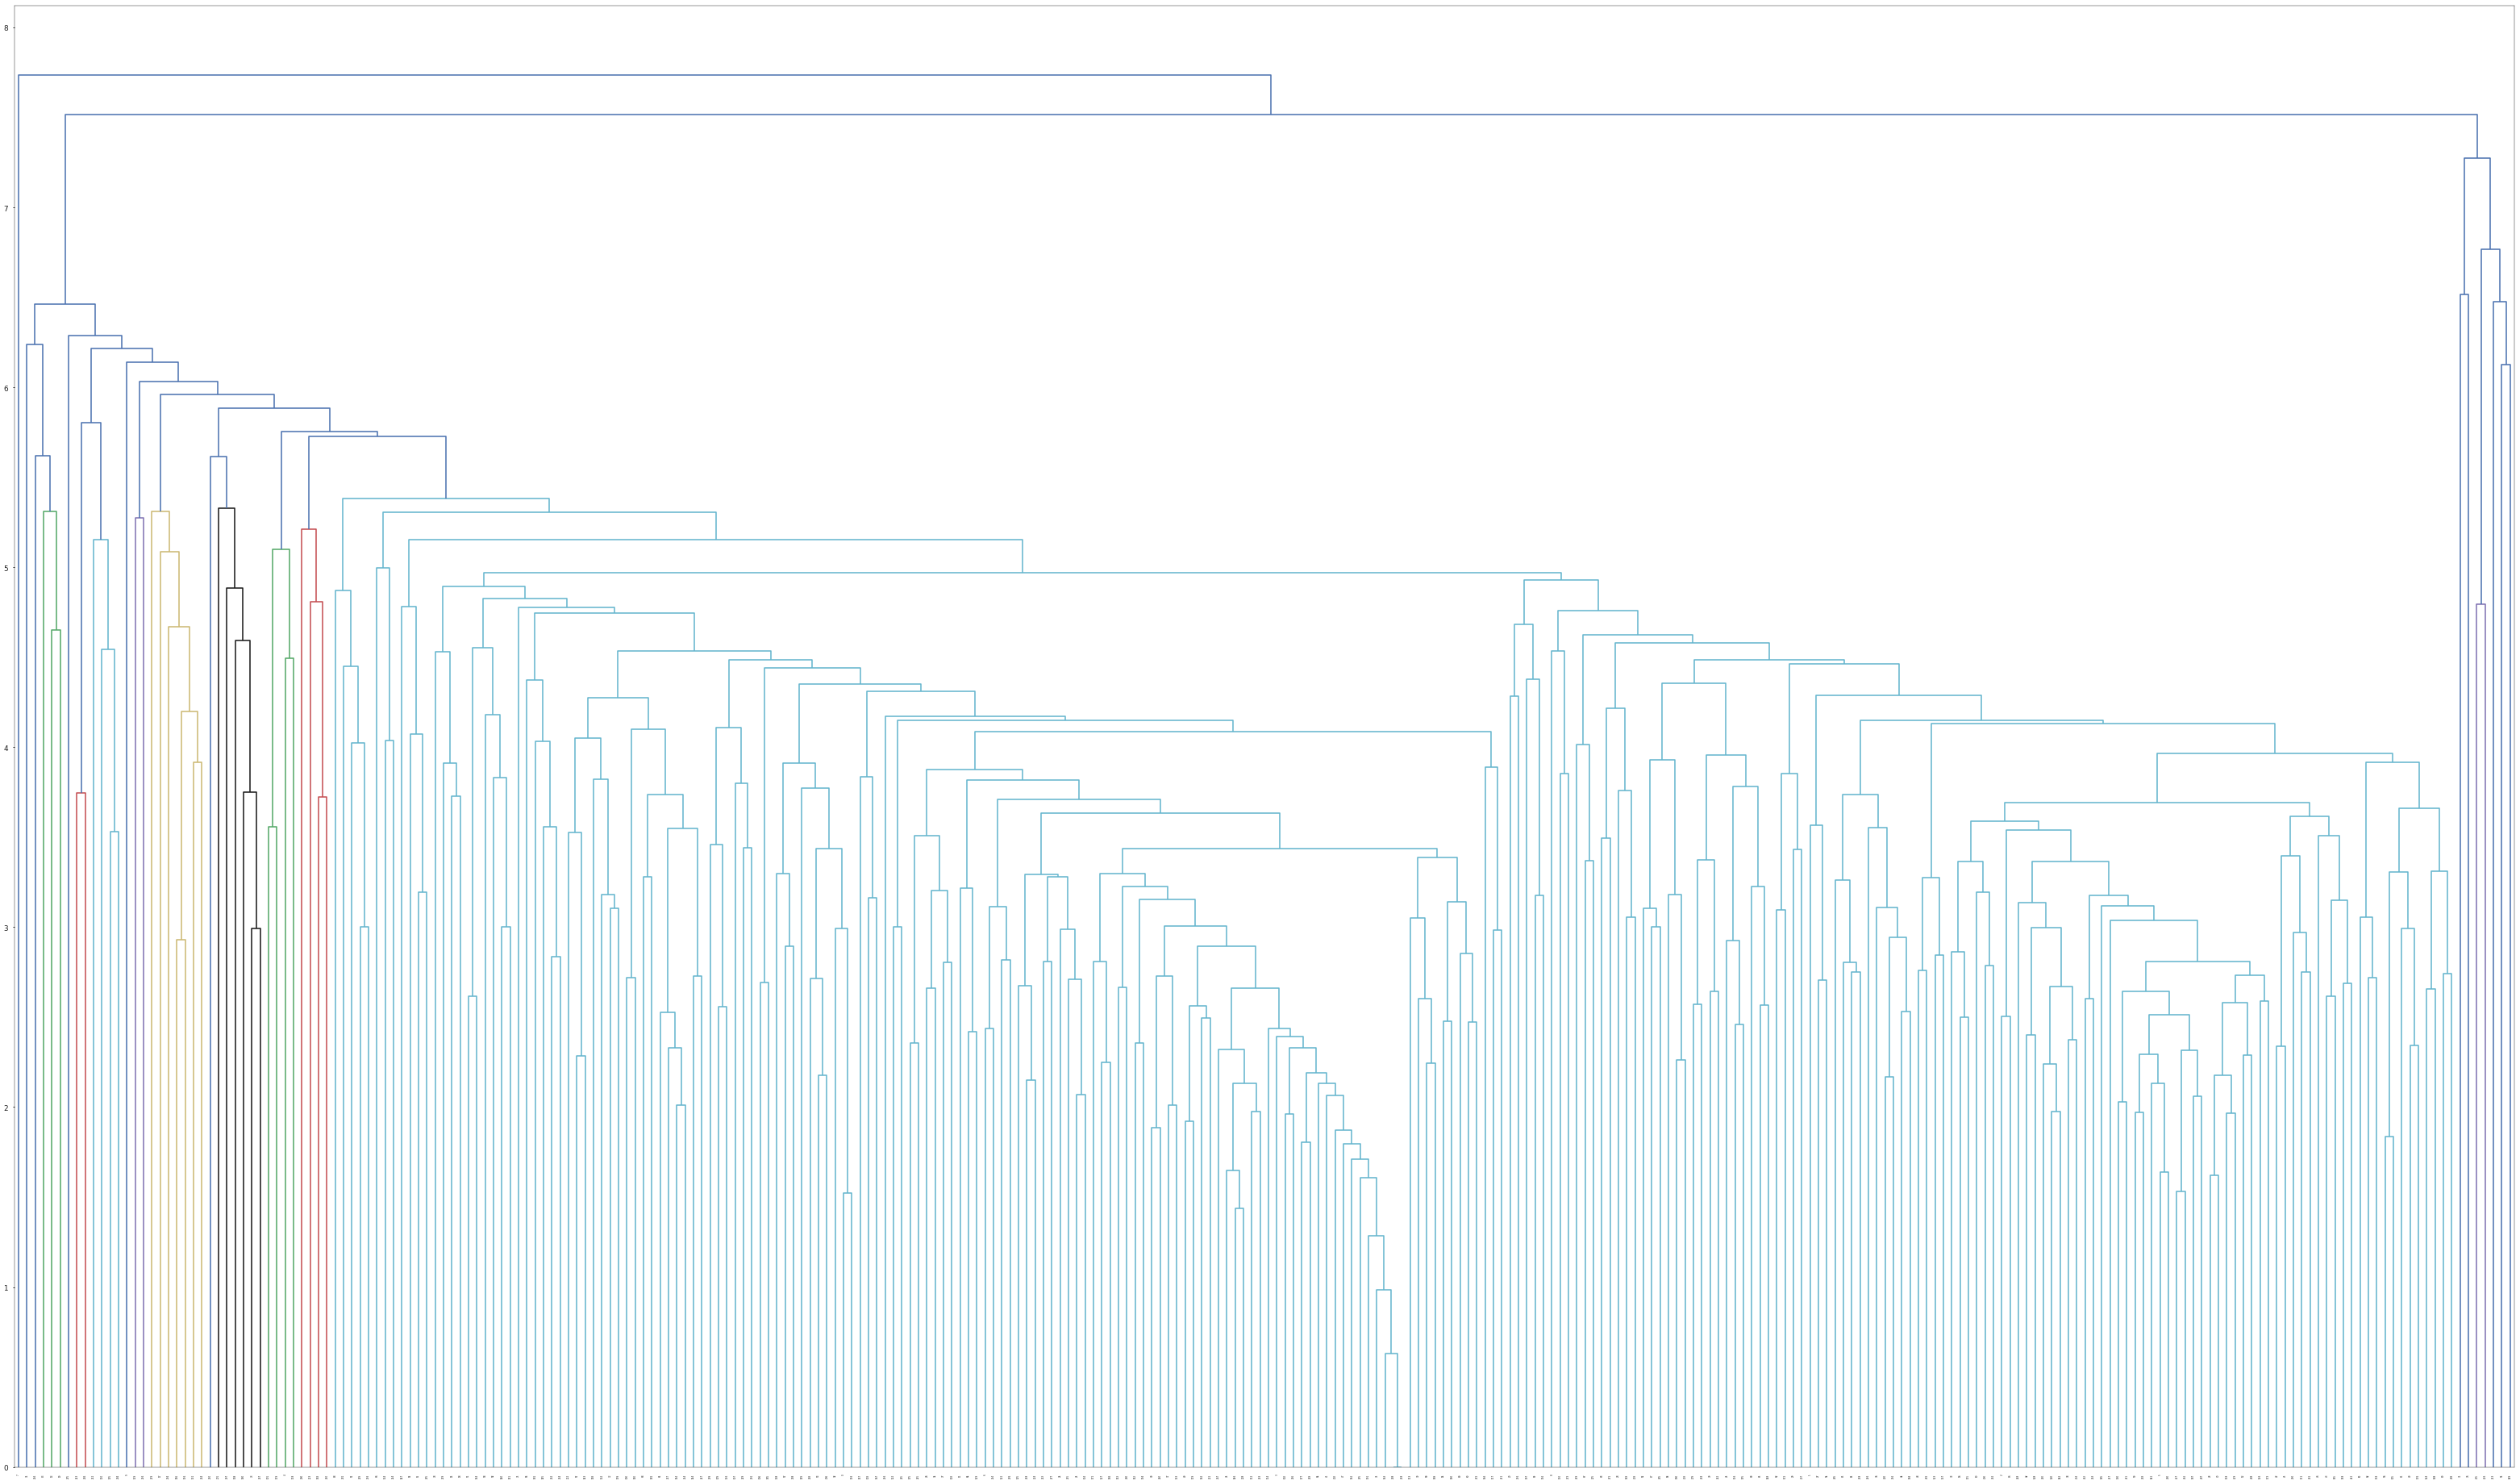

SanTan Brewing Company,8 S San Marcos Pl,Chandler,AZ
American Way Market,1509 N Arizona Ave,Chandler,AZ
GRAZ Kitchen Fresh,1005 S Arizona Ave, Ste 6,Chandler,AZ
Press Coffee,2577 W Queen Creek Rd, Ste 100,Chandler,AZ
Kiwi Juice Bar,3985 S Arizona Ave,Chandler,AZ
Mozza Hookah Lounge,1964 N Alma School Rd, Unit 10, Zorba's Greek Cafe,Chandler,AZ
Arizona Mead Company,6503 W Frye Rd, Ste 12,Chandler,AZ
AZ Food Crafters,961 W Ray Rd, Ste 1,Chandler,AZ
Cuisine & Wine Bistro - Chandler,4991 S Alma School Rd St 101,Chandler,AZ
Twisted Cactus Brewing Company,4080 W Ray Rd, Ste 26,Chandler,AZ
Sawtooth Bar & Grill,4929 W Ray Rd, Ste 3,Chandler,AZ
Slice of Chicago,478 N Arizona Ave,Chandler,AZ
Rocket Burger & Subs,2100 W Chandler Blvd, Ste 38,Chandler,AZ
Rick's Pub and Grub,4910 W Ray Rd,Chandler,AZ
Bella Gusto Urban Pizzeria,1964 N Alma School Rd, Ste 1,Chandler,AZ
VB Lounge,81 W Boston St,Chandler,AZ
Smokin Fins,900 N 54th St, Ste 1,Chandler,AZ
Yolis Café,241 S Oregon St,Chandler,AZ
Wimpy's Para

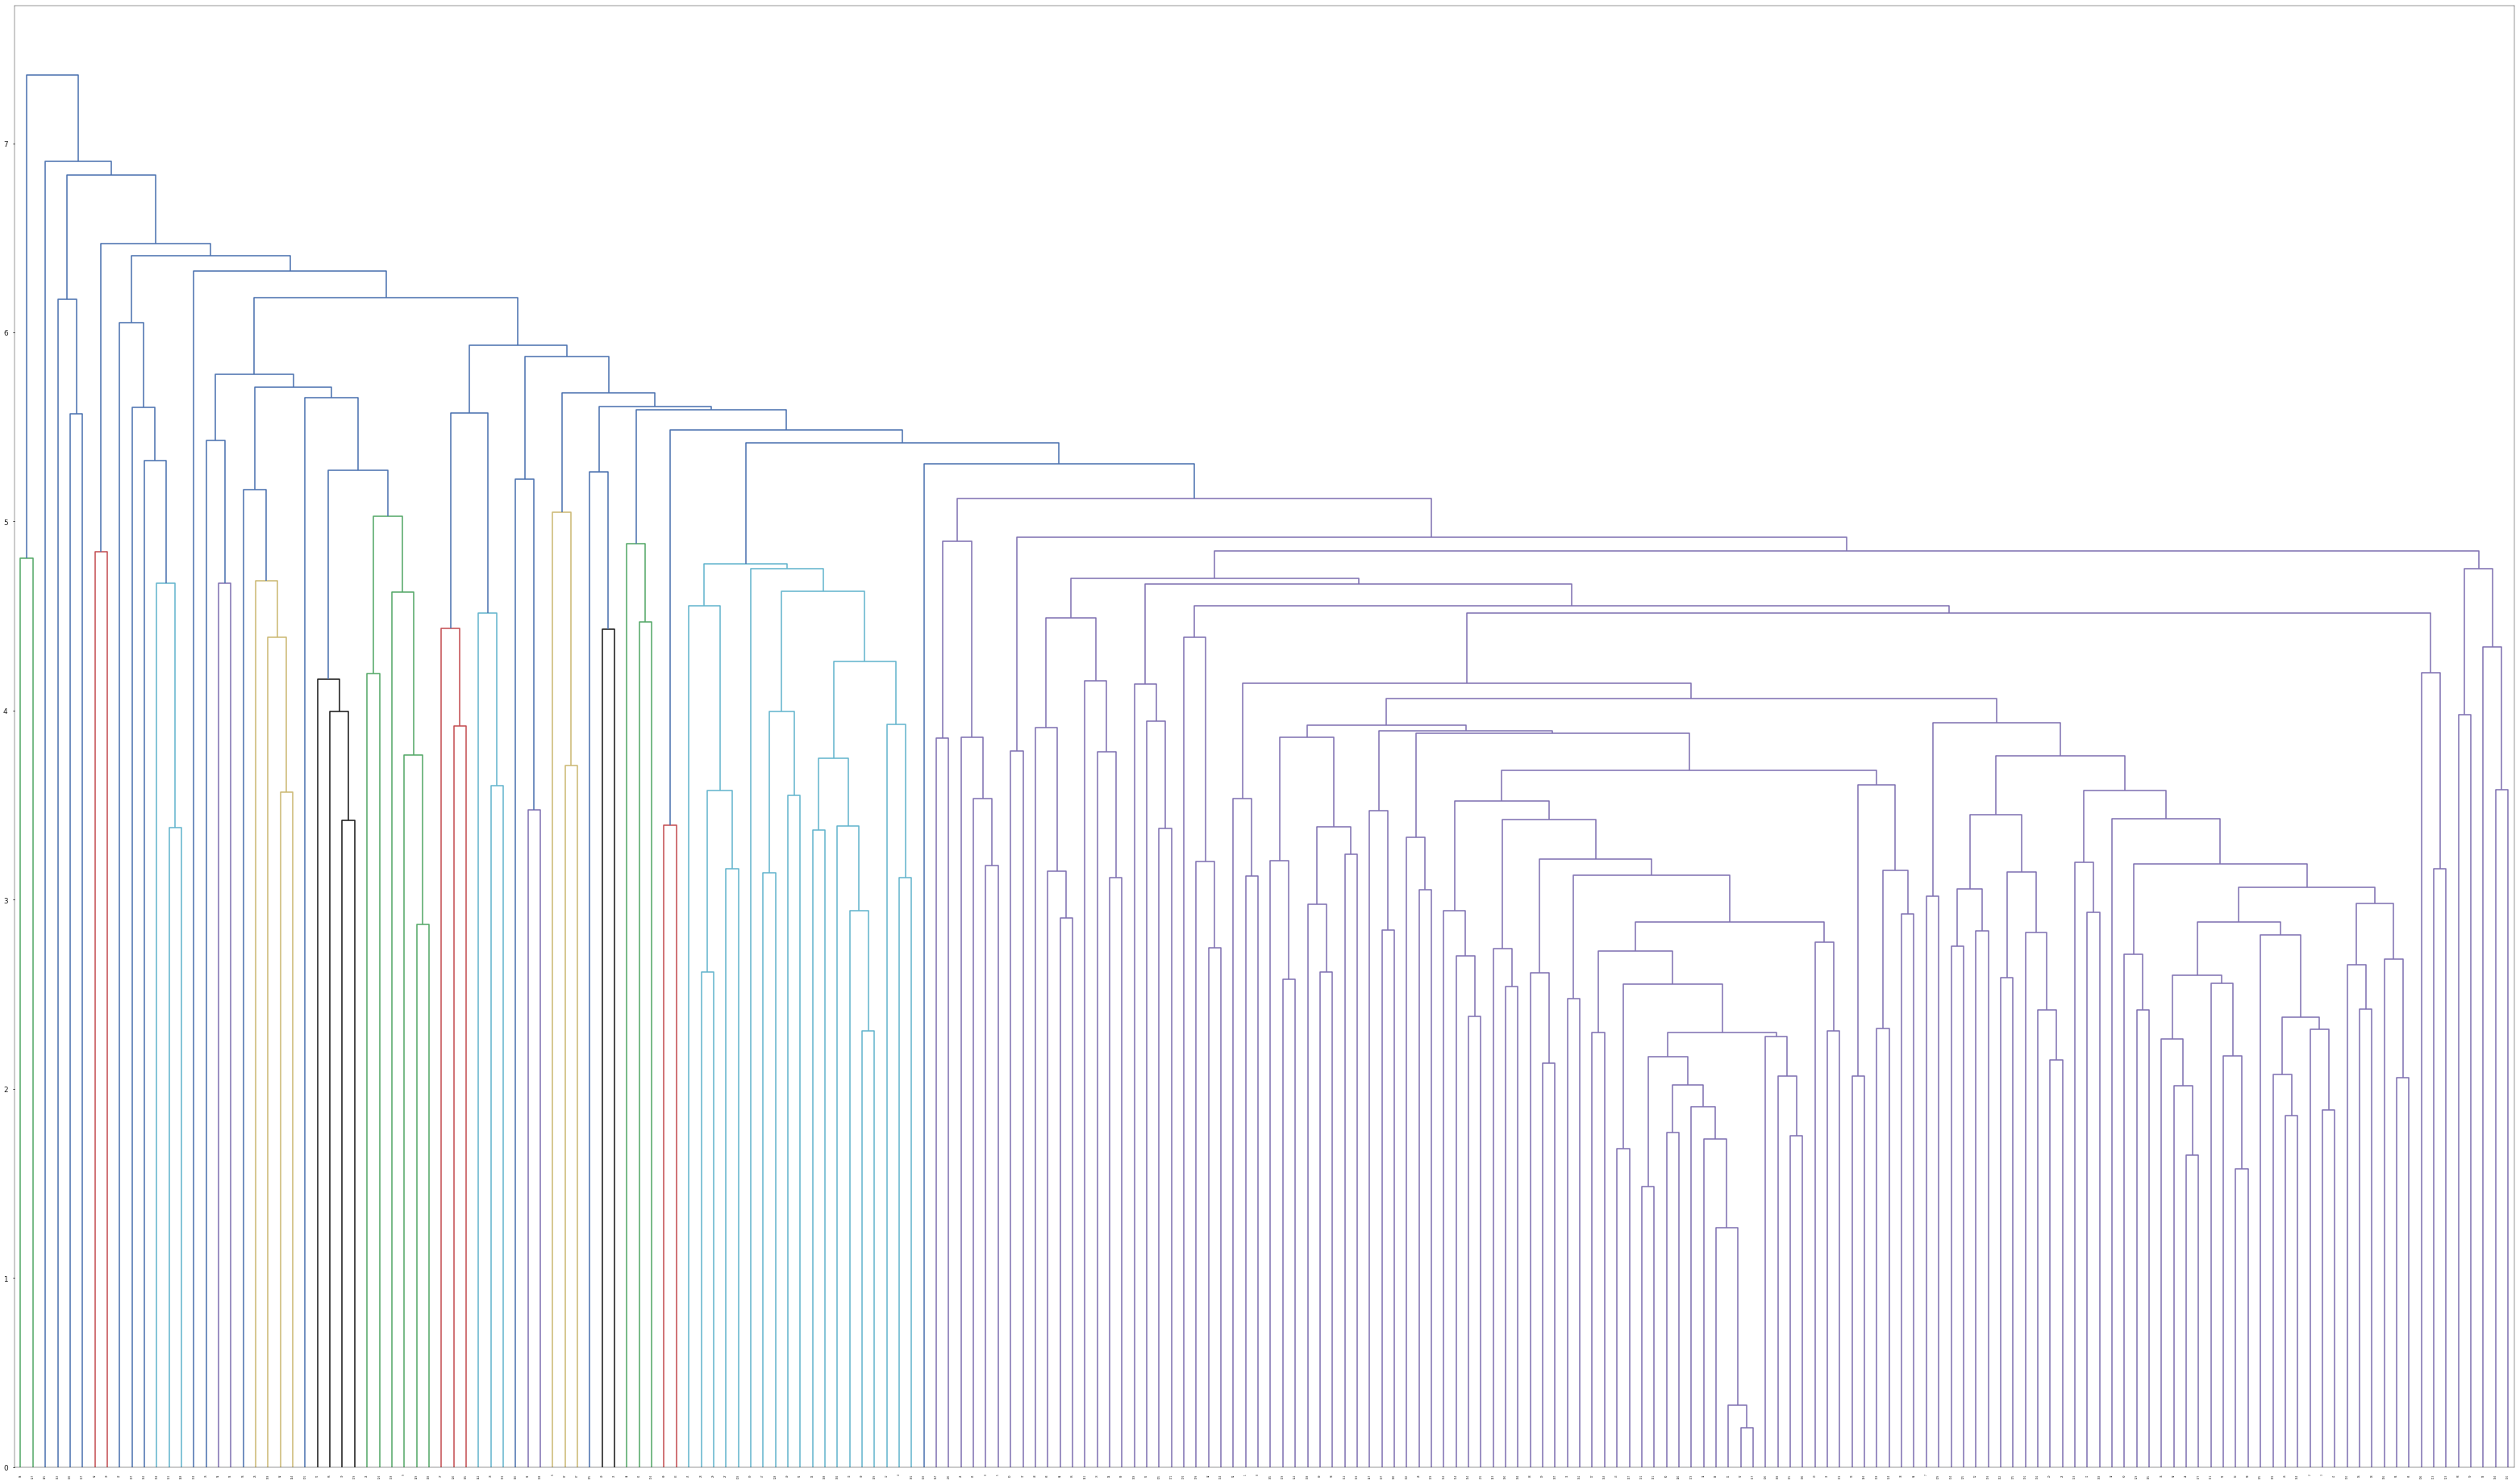

Triple 2's Tavern,1686 N  Higley Rd, Ste 101,Gilbert,AZ
Frost Gelato,2150 E Williams Field Rd, Ste 120,Gilbert,AZ
Casanova Brothers Pizza,929 N Val Vista Dr, Ste 101,Gilbert,AZ
Fire and Brimstone,3000 E Ray Rd,Gilbert,AZ
Four Silos Cafe,143 S Higley Rd,Gilbert,AZ
Everybody Loves Fondue,3244 E Guadalupe Rd,Gilbert,AZ
Postino East,302 N Gilbert Rd,Gilbert,AZ
Local Eats,6348 S Higley Rd,Gilbert,AZ
Salad and Go,743 N Gilbert Rd,Gilbert,AZ
Wild Ginger,861 N Higley Rd, Ste 111,Gilbert,AZ
Zappone's Italian Bistro,1652 N Higley Rd, Ste 103,Gilbert,AZ
1455 American Grill,1455 W Elliot Rd, Ste 101,Gilbert,AZ
Lesley's Creative Cakes,2401 E Baseline Rd,Gilbert,AZ
Tropical Sno,2268 E Williams Field Rd, Bldg 7, Ste108,Gilbert,AZ
Bruster's Real Ice Cream,709 W Ray Rd,Gilbert,AZ
Menchie's Frozen Yogurt,3757 S Gilbert Rd, Ste 108,Gilbert,AZ
Water and Ice Discount Superstore,785 W Warner Rd, Ste A113,Gilbert,AZ
The Soda Shop,4311 E Baseline Rd, Ste 101A,Gilbert,AZ
Baskin-Robbins,1939 E Baseline Rd, Ste 

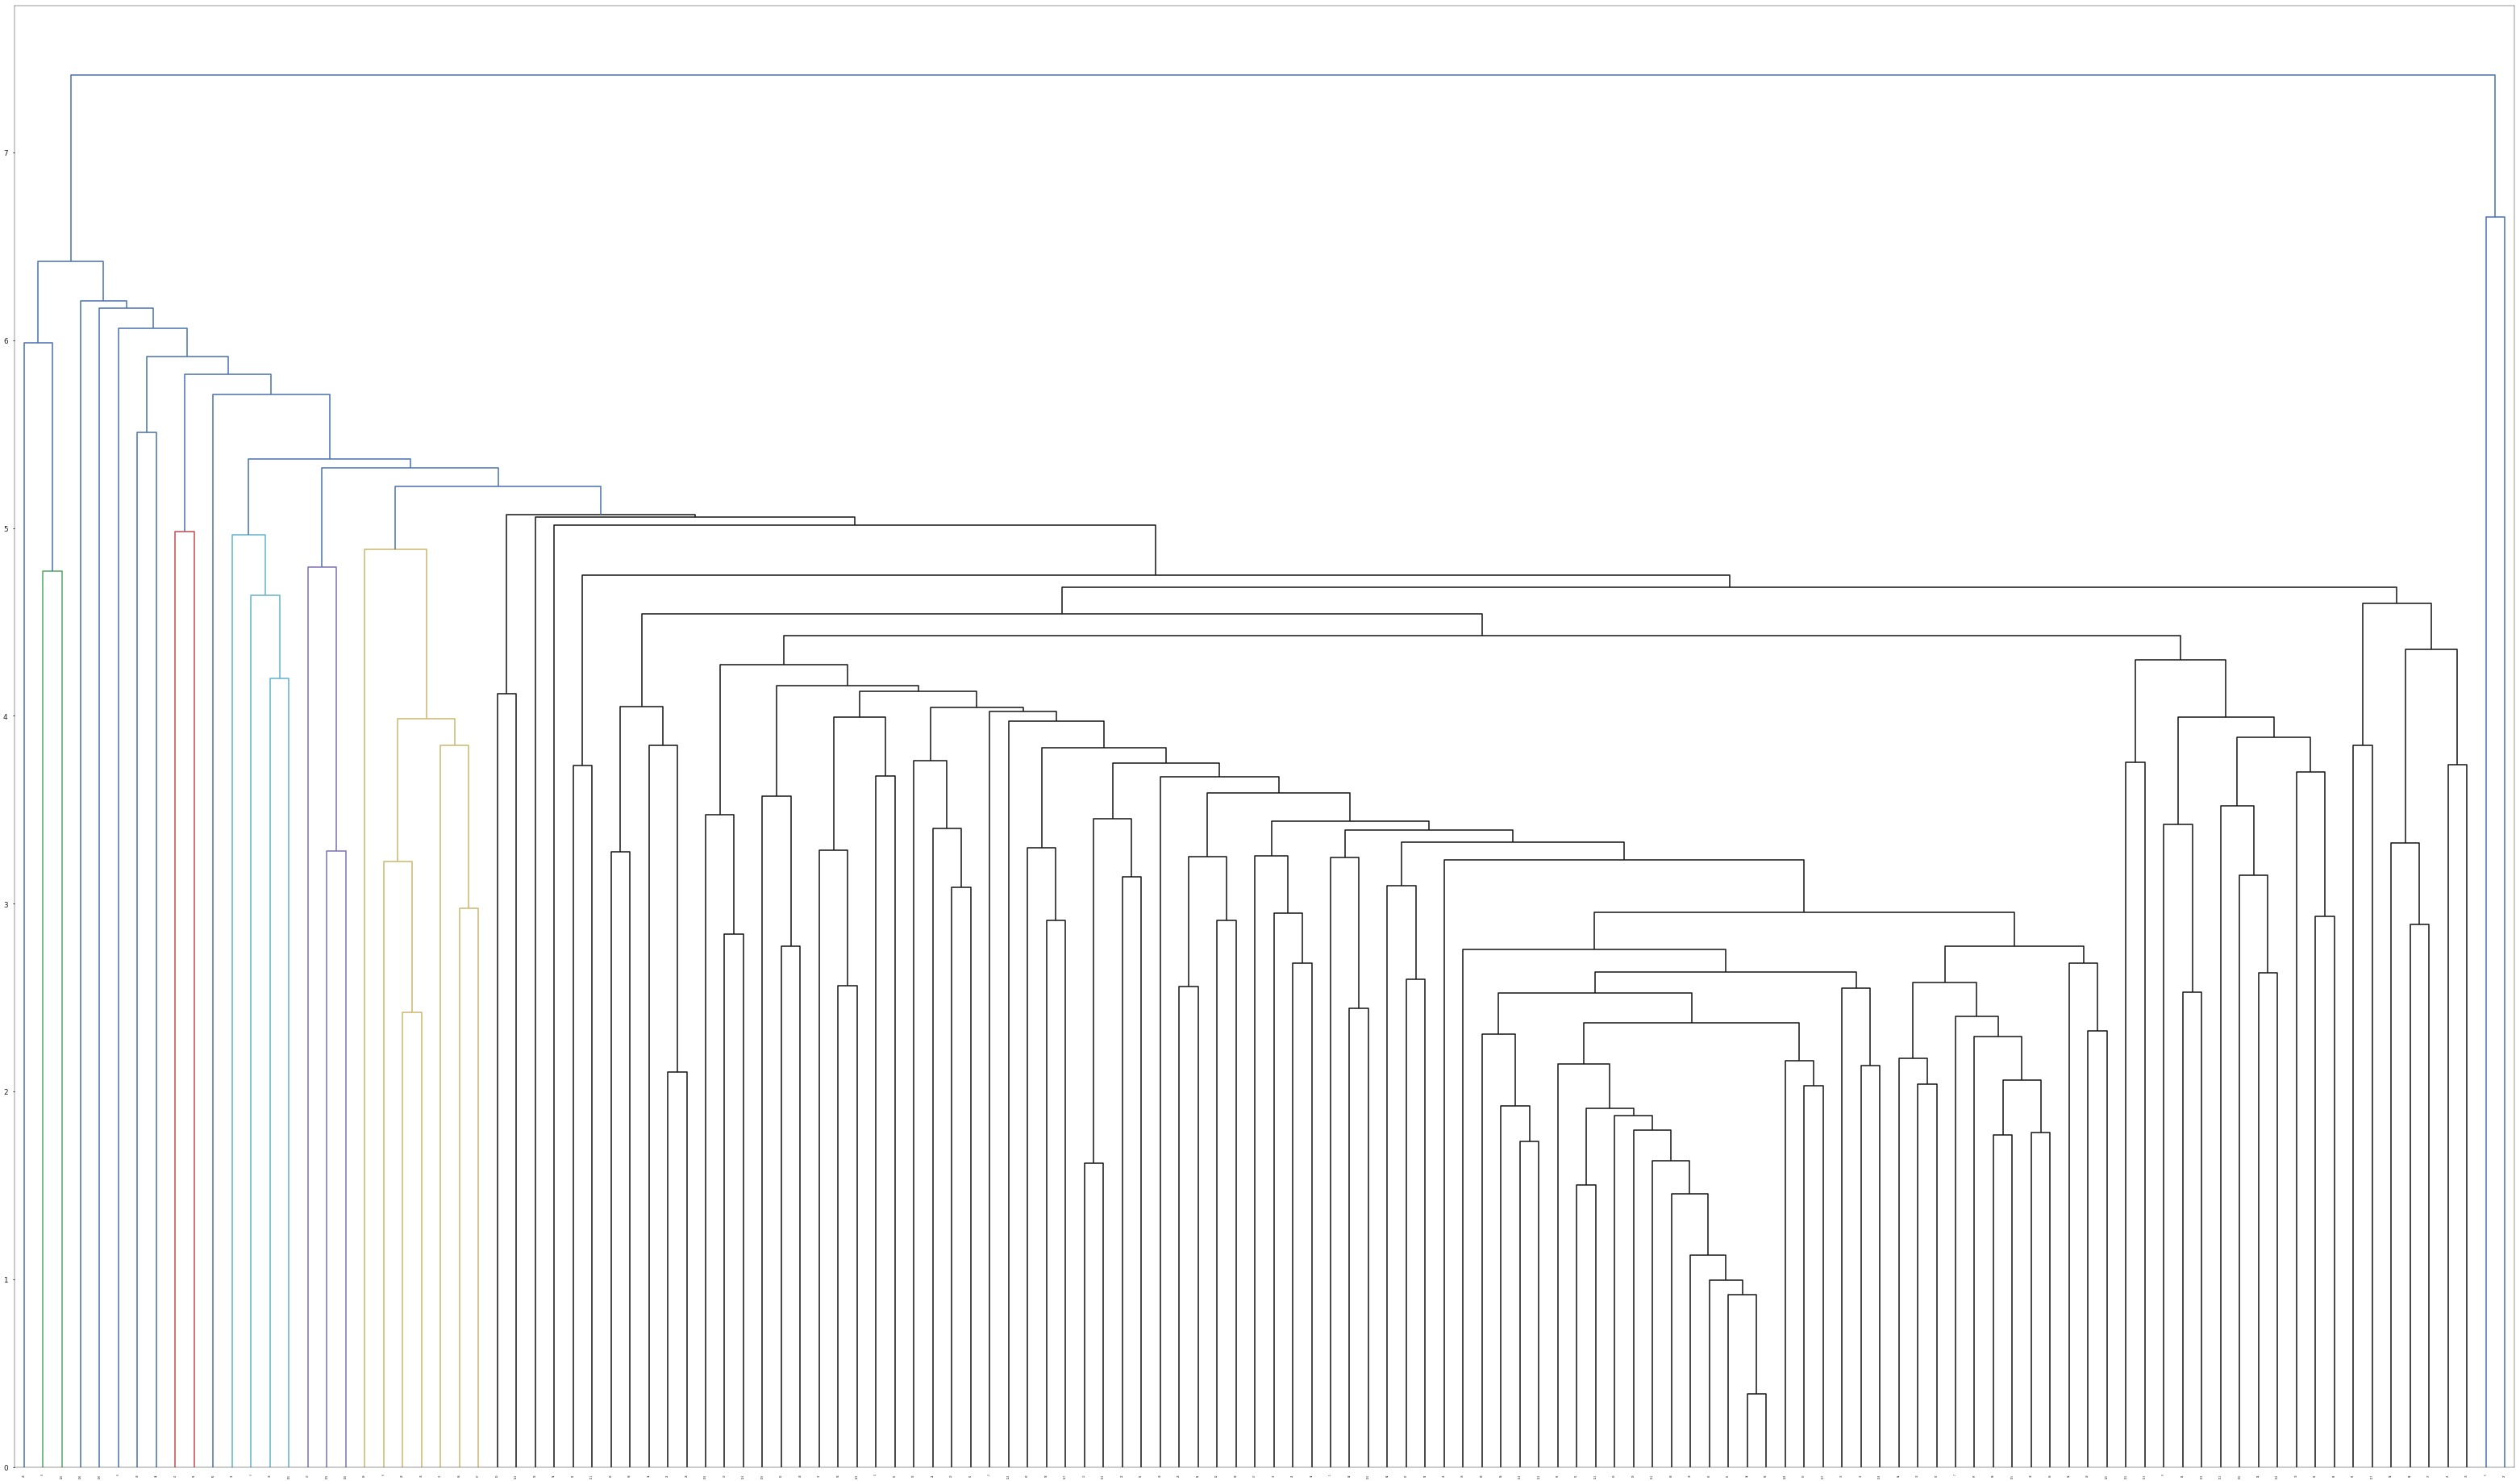

Braistas Coffee Bar,6409 W Glendale Ave,Glendale,AZ
Panini Bread & Grill,3510 W Bell Rd,Glendale,AZ
Tavern+Bowl,9380 W Westgate Blvd,Glendale,AZ
Flora House Cafe,6922 N 95th Ave, Ste 200,Glendale,AZ
My Hidden Bistro,19805 N 51st Ave,Glendale,AZ
Olde Towne Glendale Wine and Beer Bar,5745 W Glendale Ave,Glendale,AZ
Lucky's Pizza,6630 W Cactus Rd, Ste B108,Glendale,AZ
Venice Pizza,4645 W Maryland Ave,Glendale,AZ
Doglicious Hot Dogs,5060 W Bell Rd, Ste A,Glendale,AZ
A Taste of Buffalo,17045 N 59th Ave, Ste 103,Glendale,AZ
Gaslight Cafe,5747 W Glendale Ave,Glendale,AZ
Wildflower Bread Company,17530 N 75th Ave,Glendale,AZ
La Santisima,5932 W Glendale Ave,Glendale,AZ
Rainbow Donuts,4729 W Olive Ave,Glendale,AZ
Small Town Coffeehouse,19420 N 59th Ave, Ste D-415,Glendale,AZ
Kimmyz on Greenway Rock & Roll Bar & Grill,5930 W Greenway Rd,Glendale,AZ
Playgrounds Fun Zone & Cafe,8190 W Union Hills Dr, Ste 110,Glendale,AZ
Rayner's Chocolate & Coffee Shop,14021 N 51st Ave,Glendale,AZ
Cafe Lito,7155 W 

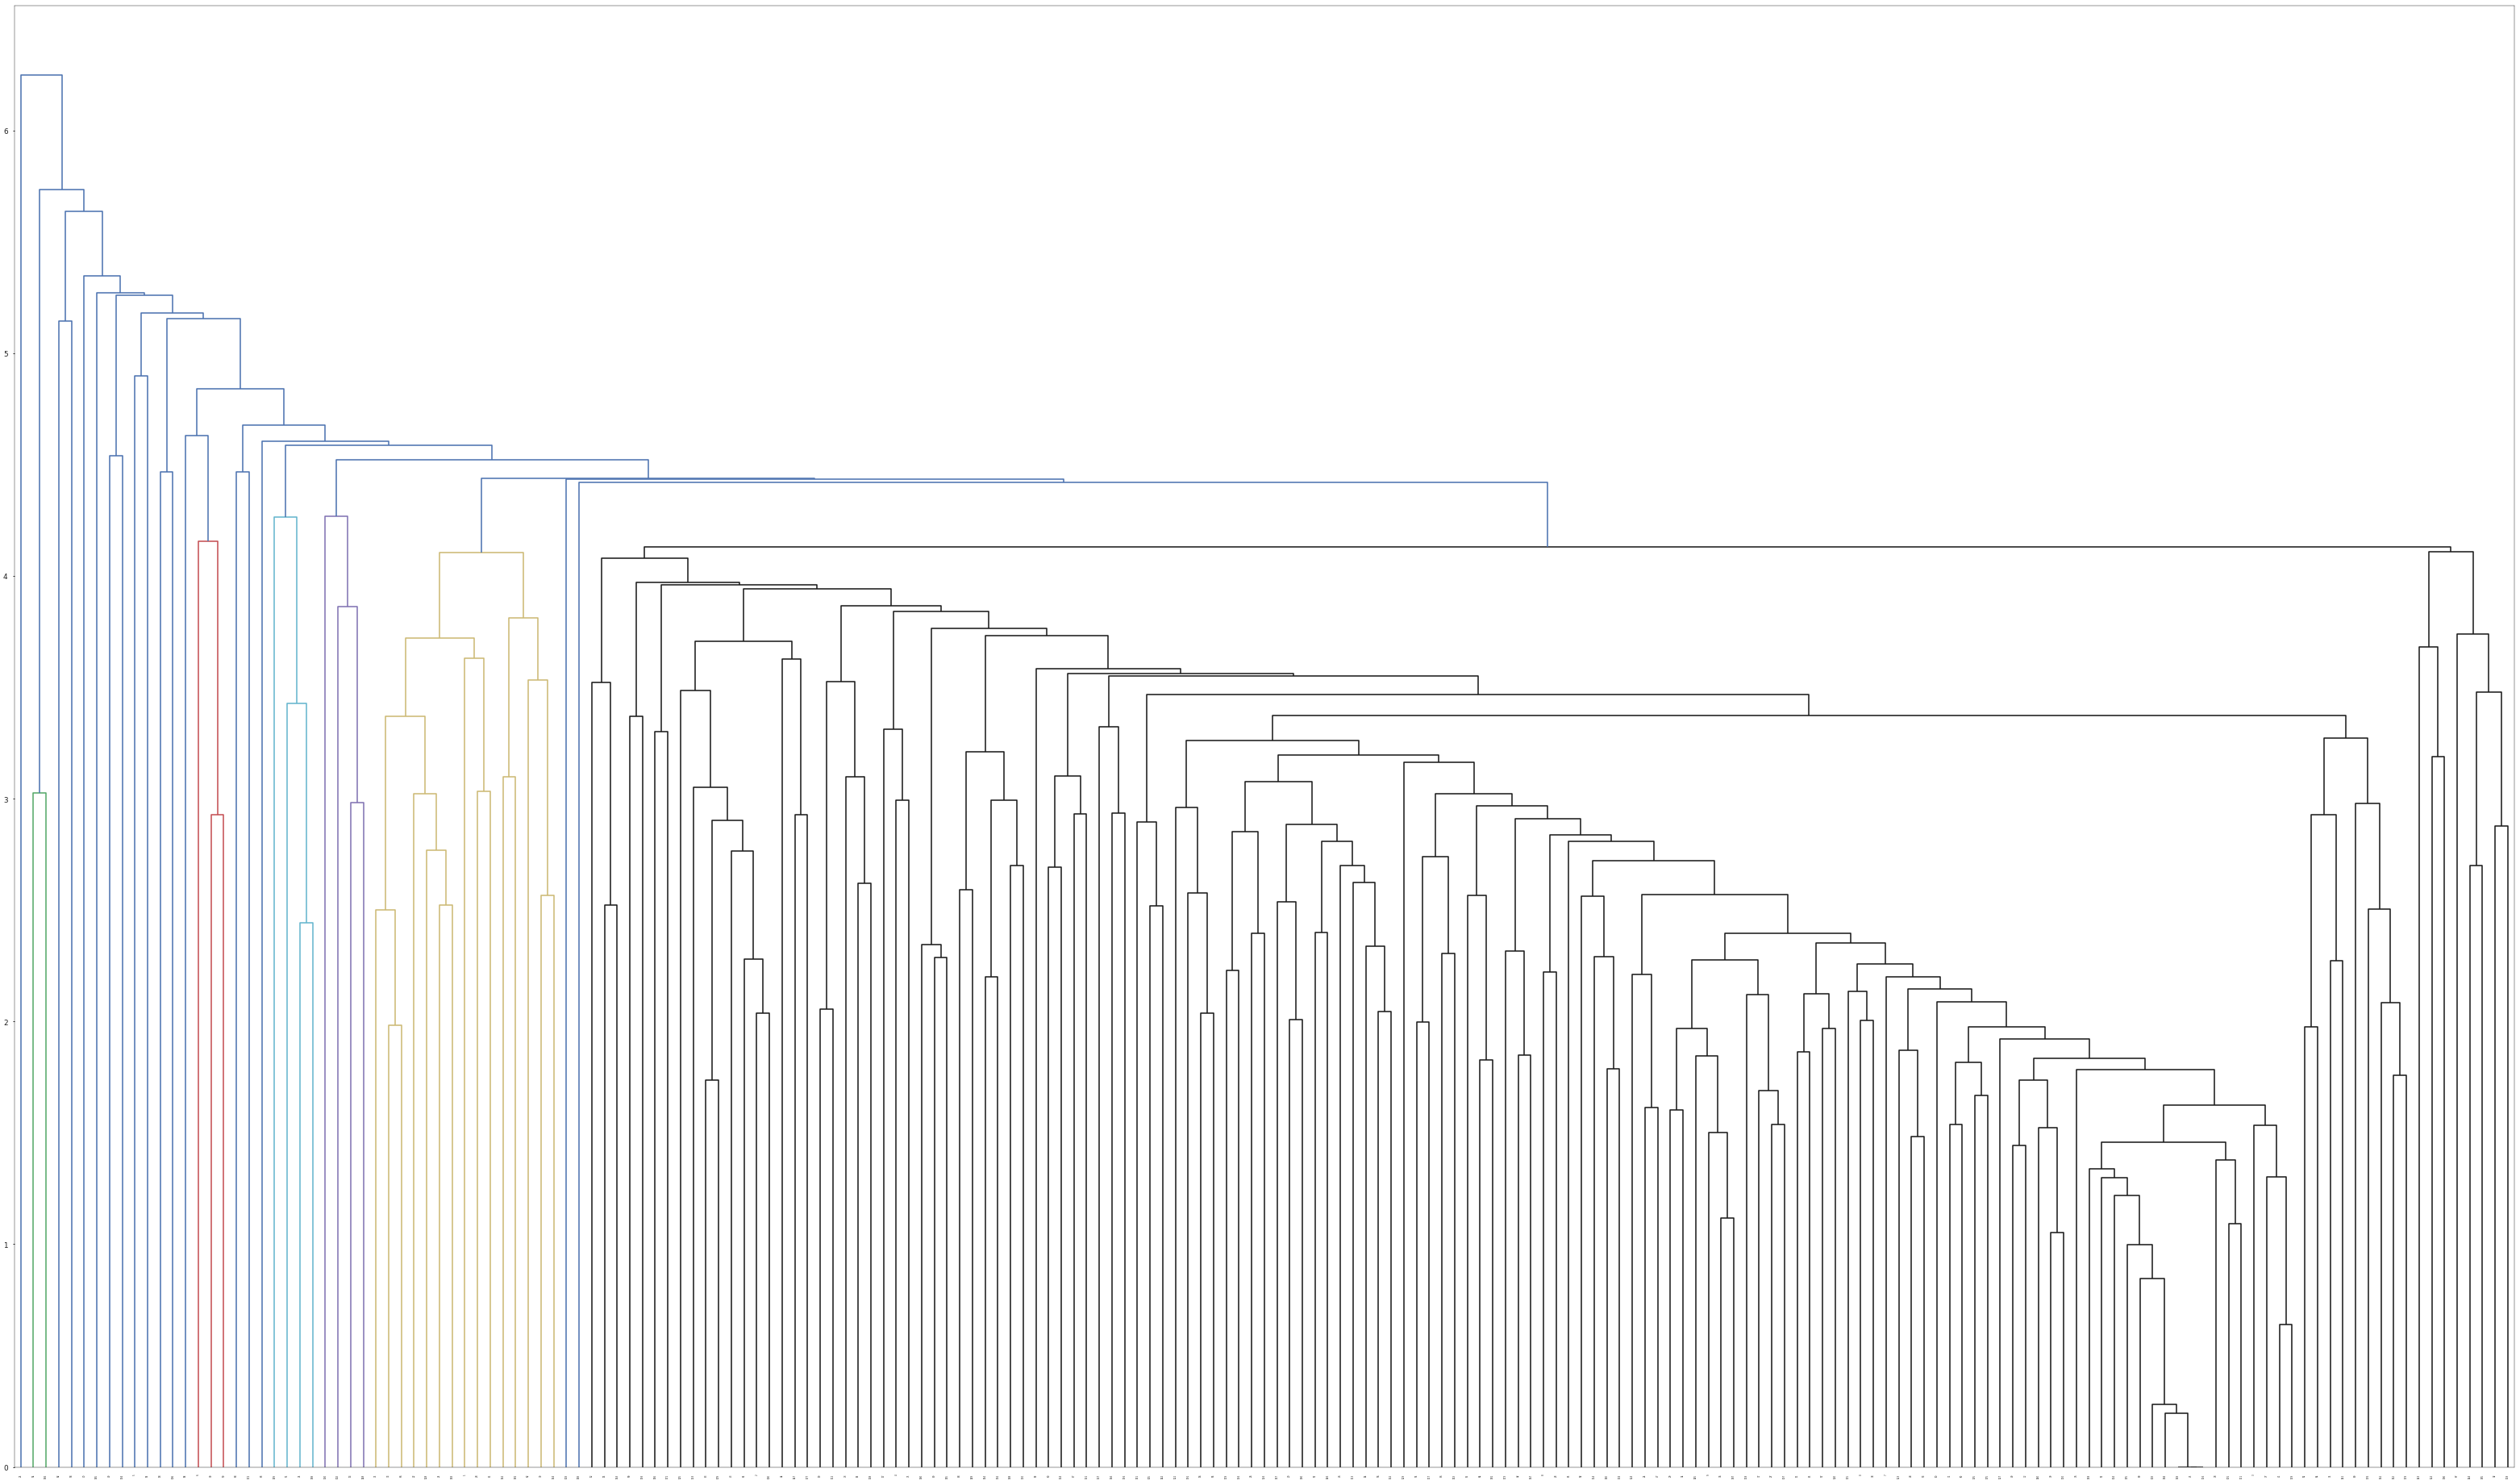

Golf Wing Virtual Golf & Restaurant,7500 Woodbine Avenue, Unit G,Markham,ON
Eini & Co,3229 Hwy 7 E,Markham,ON
Matcha Tea & Dessert,505 Highway 7 E, Unit 15, Commerce Gate,Markham,ON
Paintlounge,118 Main Street N,Markham,ON
Raw-More Cafe,8110 Birchmount Road, Suite 10,Markham,ON
Duo Patisserie & Cafe,230 Commerce Valley Drive E, Unit 4,Markham,ON
The Old Curiosity Tea Shop,91 Main Street N,Markham,ON
The Bake House,250 Cochrane Drive, Unit 9,Markham,ON
Food Jungle,4300 Steeles Avenue E,Markham,ON
Funky Munky Cafe,9275 Markham Road, Unit 7,Markham,ON
Cultural Cafe,105 Gibson Drive,Markham,ON
Bodira Cafe and Fine Foods,6899 14th Avenue, Unit 3,Markham,ON
Ocean Palate,7181 Yonge Street, Unit  243,Markham,ON
Alden Coffee Shop,431 Alden Road,Markham,ON
Sweet Esc,30 Gibson Drive, Unit 120,Markham,ON
Tasty House,3255 Highway 7 E,Markham,ON
Toast Delight,8339 Kennedy Road, Unit 2659,Markham,ON
Graceful Vegetarian Restaurant,Market Village, 7131 Kennedy Road, Suite 8,Markham,ON
Alchemy Coffee,43

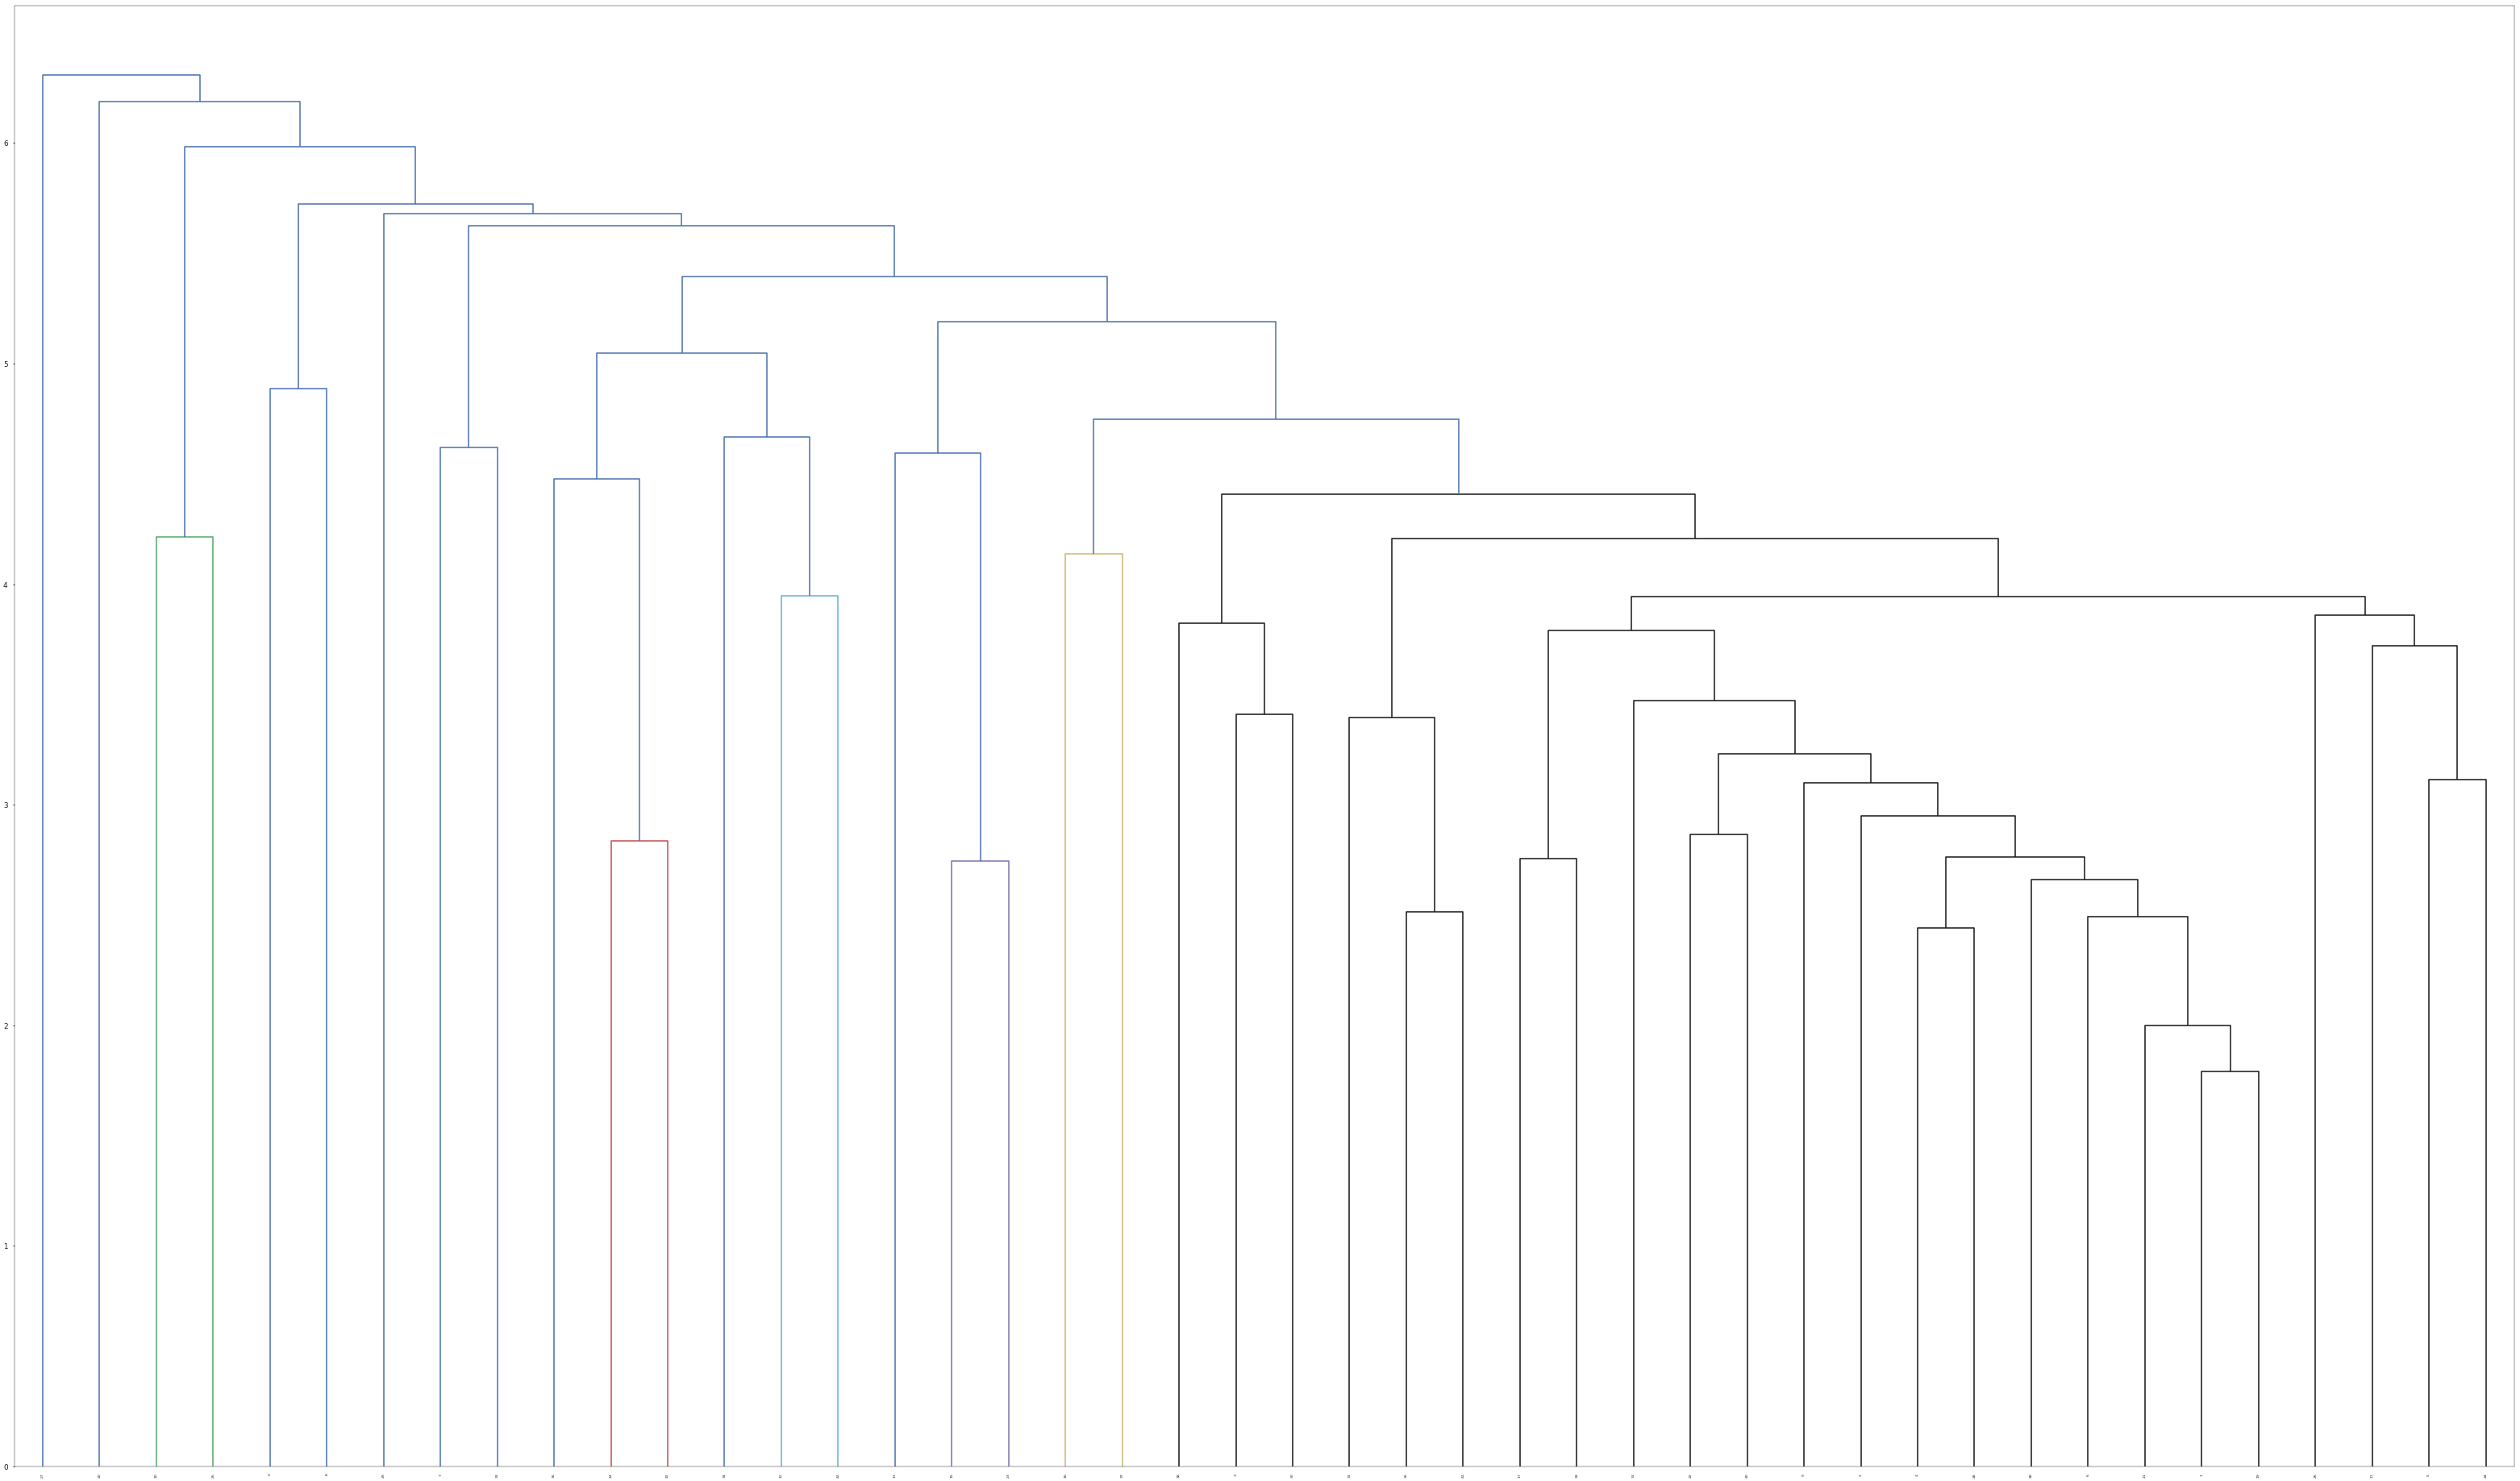

What's Fresh?,8650 W Peoria Ave, Ste 1038,Peoria,AZ
K Star BBQ,,Peoria,AZ
Winery 101,9299 W Olive Ave, Ste 101,Peoria,AZ
Chick-fil-A,16657 N 83rd Ave,Peoria,AZ
Jamburritos Cajun Grille - Express,8200 W Peoria Ave,Peoria,AZ
Sardella's Pizza & Wings,8278 W Lake Pleasant Pkwy,Peoria,AZ
Dash Grill,7557 W Greenway Rd, Ste 104,Peoria,AZ
Pizza Near Me,8525 W Grand Ave,Peoria,AZ
Firebirds Wood Fired Grill,16067 N Arrowhead Fountains Ctr Dr,Peoria,AZ
Headquarters Grill Bar Sushi,16041 N Arrowhead Fountains Center Dr,Peoria,AZ
Brunos Pizza,6750 W Olive Ave,Peoria,AZ
JJ's Louisiana BBQ,5601 W Glendale Ave,Peoria,AZ
BoSa Donuts,7446 W Cactus Rd,Peoria,AZ
Crispy Crust Pizza,7558 W Thunderbird Rd,Peoria,AZ
Deli Sports Bar,9635 W Peoria Ave,Peoria,AZ
Revolu Modern Taqueria + Bar,15703 N 83rd Ave, Ste 110,Peoria,AZ
Coop's Bar & Grill,8455 W Peoria Ave,Peoria,AZ
Modern Round,8320 W Mariners Way,Peoria,AZ
TRU Burger Company,9828 W Northern Ave,Peoria,AZ
Hit Ratio:  0.777777777778
NDCG:  0.884834626178



In [12]:
hr_list = []
ndcg_list = []
for state in list_city[:20]:
    result = recommend_based_on_state(state)
    hr_list.append(result[0])
    ndcg_list.append(result[1])

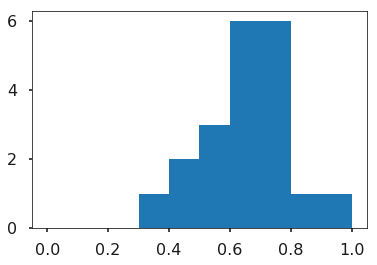

In [13]:
plt.hist(hr_list, bins=[x for x in np.arange(0., 1.01, 0.1)])
plt.show()

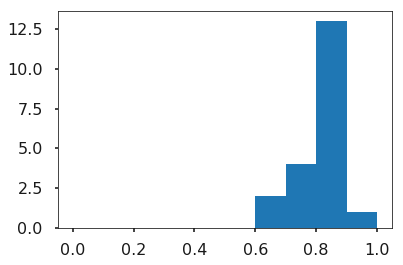

In [14]:
plt.hist(ndcg_list, bins=[x for x in np.arange(0., 1.01, 0.1)])
plt.show()

In [15]:
print("Average Hit Ratio is :")


statistics.mean(hr_list)

Average Hit Ratio is :


0.64539796755137346

In [16]:
print("Average NDCG is :")


statistics.mean(ndcg_list)

Average NDCG is :


0.82880826761449555